In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import json 
import sys
#sys.modules.pop('../dataloader')
sys.path.append('../dataloader/')
sys.path.append('../utils/')


from dataloader import DataLoader 

import plotting

In [25]:
! ls ../utils

find_compatible_hits_dev.py  geometry.py  noise.py     __pycache__
find_compatible_hits.py      hits.py	  plotting.py


In [15]:
f = open("/home/lhv14/mapping_CMS_nocut_1000.json")
mappings = json.load(f)

In [3]:
md = pd.read_csv('/home/lhv14/new_md_hitbased.csv',  header=[0], index_col=[0, 1,2])
md = md.reset_index()
md.rename(columns = {'level_1':'volume_id', 'level_2':'layer_id'}, inplace = True)

In [2]:
dl = DataLoader() 
hits, allowed_pids = dl.load_data(4)
hits

../dataloader/dataloader.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  background['particle_id'] = create_unique_label_background_tracks(background['particle_id'], background['sim_pt'])
../dataloader/dataloader.py:120: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hits[['next_mod_id', 'connecting_layer_id']] = hits.groupby('particle_id')['discrete_module_id', 'unique_layer_id'].shift(-1)


run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     8025        1    52  5105  310104  310104    4649  -1.945225  -1.943862   
      5707        1    52  5105  310104  310104    2281  -0.711496   2.656365   
      8184        1    52  5105  310104  310104    4809  -1.944519  -1.944568   
      10622       1    52  5105  310104  310104    7315   2.656270  -0.711851   
      4643        1    52  5105  310104  310104    1202   1.944061   1.945026   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      205044      1    52  5105  310104  310104  203720  27.413033  20.850473   
      197095      1    52  5105  310104  310104  195678  34.383175  10.267204   
      197055      1    52  5105  310104  310104  195638  35.371029   7.527621   
      197116      1    52  5105  310104  310104  195699  34.792999  11.538926   
      197074      1    52  5105  310104  310104  195657  36.144032   6.563105   

                         z  particle_id  ...    sim_pt   sim_eta   sim_phi  \
entry subentry                           ...                                 
4     8025       -2.514950       -21684  ...  1.344249 -0.522033 -2.371882   
      5707       -0.525605       -19959  ...  0.814288  0.015682  1.746123   
      8184        5.445179        -2801  ...  0.153517  1.975594 -2.269836   
      10622       6.926171        -4616  ...  0.190140  1.226896 -0.211766   
      4643        8.124049       -20902  ...  1.012576  2.218619  1.257427   
...                    ...          ...  ...       ...       ...       ...   
      205044    224.132004            0  ...  0.003184  5.648093  2.976746   
      197095    186.378006            0  ...  0.003184  5.648093  2.976746   
      197055    187.453003            0  ...  0.003184  5.648093  2.976746   
      197116    185.977997            0  ...  0.003184  5.648093  2.976746   
      197074    187.852997            0  ...  0.003184  5.648093  2.976746   

                volume_id  layer_id  module_id          r  unique_layer_ids  \
entry subentry                                                                
4     8025              2         1          4   2.750000                 1   
      5707              2         1          5   2.750000                 1   
      8184              2         1          6   2.750000                 1   
      10622             2         1          7   2.750000                 1   
      4643              2         1          7   2.750000                 1   
...                   ...       ...        ...        ...               ...   
      205044            6         4          3  34.441494                43   
      197095            6         3          2  35.883400                42   
      197055            6         3          1  36.163170                42   
      197116            6         3          2  36.656509                42   
      197074            6         3          1  36.735069                42   

                unique_layer_id  discrete_module_id  
entry subentry                                       
4     8025                    1                 214  
      5707                    1                 215  
      8184                    1                 216  
      10622                   1                 217  
      4643                    1                 217  
...                         ...                 ...  
      205044                 43                6433  
      197095                 42                6422  
      197055                 42                6421  
      197116                 42                6422  
      197074                 42                6421  

[310104 rows x 27 columns]

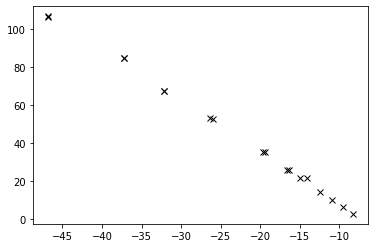

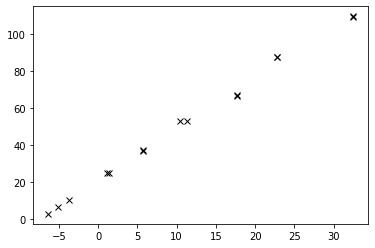

In [20]:
for pid in [0, 1]: 
    p = hits[hits['particle_id']==pid]
    plt.plot(p.z, p.r, "kx")
    plt.show()

In [4]:
def calc_distance(m, b, point_z, point_r): 
    d = np.abs(m*point_z - point_r +b )/np.sqrt(m**2+1)
    return d

In [5]:
def eval_line_at_point(m, b, z): 
    r = m * z +  b
    return r 

In [8]:
hits['z_2'] = hits.groupby('particle_id')['z'].shift(-1)


In [9]:
hits['diff_z'] = hits['z_2'] - hits['z']


In [10]:
z_0 = hits.groupby('particle_id').min().z
right = z_0[z_0 > 0]
left = z_0[z_0 < 0]

In [11]:
right_particles = hits[hits['particle_id'].isin(right.index)].reset_index()
left_particles = hits[hits['particle_id'].isin(left.index)].reset_index()

In [12]:
ix_right = np.where(right_particles['diff_z'] < 0)[0]
right_particles = right_particles.drop(ix_right + 1, axis = 0)

ix_left = np.where(left_particles['diff_z'] > 0)[0]
left_particles = left_particles.drop(ix_left + 1, axis = 0 )

In [13]:
f = right_particles.append(left_particles)

In [14]:
hits

run  lumi   evt    nhit   hit_n  hit_id          x          y  \
1668      1    89  8805  136545  136545     750   1.945139   1.943948   
1751      1    89  8805  136545  136545     835   1.944333   1.944754   
8226      1    89  8805  136545  136545    7397   2.656227  -0.712008   
5657      1    89  8805  136545  136545    4804  -1.943937  -1.945150   
2048      1    89  8805  136545  136545    1135   1.944278   1.944809   
...     ...   ...   ...     ...     ...     ...        ...        ...   
130819    1    89  8805  136545  136545  130804 -21.959251  12.808491   
65243     1    89  8805  136545  136545   64791  23.471235  -9.765703   
64975     1    89  8805  136545  136545   64523 -24.480110  -6.872338   
79536     1    89  8805  136545  136545   79125   3.377235  25.205433   
79911     1    89  8805  136545  136545   79500  -9.803713 -23.474817   

                 z  particle_id  ...   sim_eta   sim_phi  volume_id  layer_id  \
1668     -8.818335       -16156  ... -1.993133  0.768413          2         1   
1751     -2.842576        -3029  ...  0.007020 -0.066176          2         1   
8226     -0.715824       -14699  ...  0.176146 -0.284227          2         1   
5657      0.912315       -10617  ...  1.037463 -2.392608          2         1   
2048     10.710626       -11587  ...  1.840821  0.819509          2         1   
...            ...          ...  ...       ...       ...        ...       ...   
130819  230.968994        -6894  ...  1.308712  3.027997          3        27   
65243  -175.199997       -17576  ... -2.624437 -0.316705          1        13   
64975  -175.199997       -15286  ... -2.629861 -2.675143          1        13   
79536  -265.200012        -7024  ... -3.017693  1.935381          1        16   
79911  -265.200012        -6123  ... -2.941274 -1.460725          1        16   

        module_id          r  unique_layer_id  discrete_module_id        z_2  \
1668            3   2.750000                1                 213 -25.200001   
1751            4   2.750000                1                 214  -5.200835   
8226            5   2.750000                1                 215  -0.075086   
5657            5   2.750000                1                 215   5.437775   
2048            7   2.750000                1                 217  24.799999   
...           ...        ...              ...                 ...        ...   
130819         20  25.421764               43               32720        NaN   
65243          45  25.421799               17               11345        NaN   
64975          27  25.426458               17               11327        NaN   
79536          11  25.430681               20               11611        NaN   
79911          33  25.439730               20               11633        NaN   

           diff_z  
1668   -16.381666  
1751    -2.358260  
8226     0.640737  
5657     4.525459  
2048    14.089374  
...           ...  
130819        NaN  
65243         NaN  
64975         NaN  
79536         NaN  
79911         NaN  

[136545 rows x 28 columns]

In [156]:
hor_vol = [8, 13, 17]
ver_vol = [7, 9, 12, 14, 16, 18]


In [15]:
len(f)/len(hits)

0.8895821890219342

  0%|                                                                                                                               | 0/200 [00:00<?, ?it/s]

pid -22485.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     179441      1    52  5105  310104  310104  177774   5.134861  29.158421   
      179407      1    52  5105  310104  310104  177740   5.278473  30.249258   
      180161      1    52  5105  310104  310104  178498  24.267282 -16.963413   
      179542      1    52  5105  310104  310104  177875 -10.095335  27.834671   
      180245      1    52  5105  310104  310104  178582  29.144062  -5.243921   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      179534      1    52  5105  310104  310104  177867 -15.010374  25.798794   
      180163      1    52  5105  310104  310104  178500  21.034758 -21.176119   
      180251      1    52  5105  310104  310104  178588  28.802084  -7.841506   
      179405      1    52  5105  310104  310104  177738   6.829404  30.193041   
      179

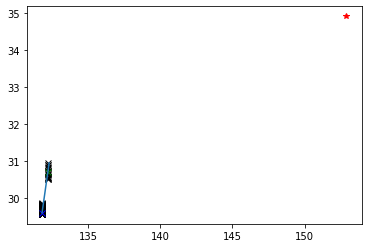

pid -22485.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     189826      1    52  5105  310104  310104  188312   5.917335  34.412388   
      199240      1    52  5105  310104  310104  197833  19.378571  36.976040   
      189994      1    52  5105  310104  310104  188480 -25.408979  23.959059   
      198468      1    52  5105  310104  310104  197057 -24.437101  33.055305   
      190076      1    52  5105  310104  310104  188564 -33.974564   8.119022   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      189745      1    52  5105  310104  310104  188231  20.008160  28.440611   
      189993      1    52  5105  310104  310104  188479 -28.419304  20.035927   
      190563      1    52  5105  310104  310104  189053  33.847393  -7.961072   
      190143      1    52  5105  310104  310104  188631 -34.591305  -7.368099   
      199

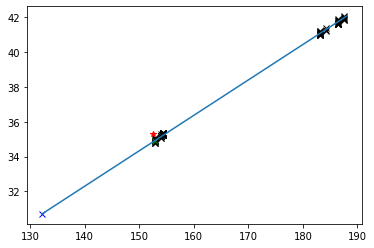

  0%|▌                                                                                                                      | 1/200 [00:00<01:21,  2.45it/s]

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     30537       1    52  5105  310104  310104   27605  4.586255 -0.464765   
      30580       1    52  5105  310104  310104   27650  4.391658 -1.400499   
      30391       1    52  5105  310104  310104   27454  2.779658 -3.607881   
      34296       1    52  5105  310104  310104   31410 -3.674707 -4.482576   
      29537       1    52  5105  310104  310104   26589 -0.193713  4.603067   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      30016       1    52  5105  310104  310104   27072 -3.717907 -2.712048   
      33635       1    52  5105  310104  310104   30743  1.018950  5.658311   
      34437       1    52  5105  310104  310104   31552  1.700455 -5.550372   
      30144       1    52  5105  310104  310104   27203 -2.231296 -3.977175   
      29539       1    52  5105  

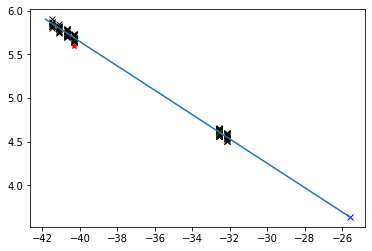

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     34728       1    52  5105  310104  310104   31848  5.818281 -0.584924   
      39327       1    52  5105  310104  310104   36502  4.251318  6.763046   
      35671       1    52  5105  310104  310104   32804 -0.902231 -5.605293   
      39891       1    52  5105  310104  310104   37070 -7.012793 -3.996454   
      34132       1    52  5105  310104  310104   31244 -5.516685 -1.657152   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      35749       1    52  5105  310104  310104   32882  1.177745 -5.466639   
      39314       1    52  5105  310104  310104   36489  5.558052  5.734112   
      39746       1    52  5105  310104  310104   36924 -8.028975  0.901319   
      34119       1    52  5105  310104  310104   31231 -5.699594 -1.334290   
      40254       1    52  5105  

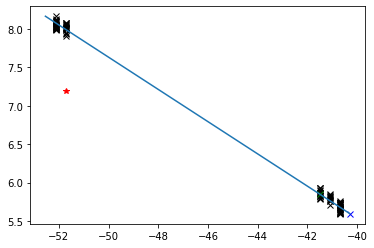

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     39071       1    52  5105  310104  310104   36242   7.396081 -0.734799   
      45726       1    52  5105  310104  310104   42956   7.329136 -7.393445   
      40132       1    52  5105  310104  310104   37314   1.313171 -7.147711   
      45778       1    52  5105  310104  310104   43010   8.241583 -6.232610   
      45767       1    52  5105  310104  310104   42999   7.262274 -7.335625   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      40060       1    52  5105  310104  310104   37242  -1.847211 -7.144438   
      45398       1    52  5105  310104  310104   42627 -10.345997 -1.915562   
      45384       1    52  5105  310104  310104   42613  -9.884002 -2.893627   
      38604       1    52  5105  310104  310104   35772  -4.871794 -5.352619   
      45112       1  

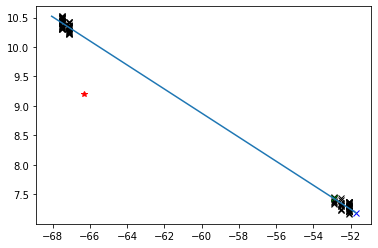

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     44883       1    52  5105  310104  310104   42107   9.166224 -0.896514   
      45855       1    52  5105  310104  310104   43089   9.336953 -0.912776   
      44784       1    52  5105  310104  310104   42008   7.985764 -4.576046   
      50398       1    52  5105  310104  310104   47673  13.282549  0.839711   
      915         1    52  5105  310104  310104   48423  11.118227 -7.160329   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      44510       1    52  5105  310104  310104   41733  -4.435063 -7.906902   
      50427       1    52  5105  310104  310104   47702  12.657767  4.265552   
      50473       1    52  5105  310104  310104   47748   9.786586  8.654209   
      45600       1    52  5105  310104  310104   42830  -1.761860 -9.063602   
      45521       1  

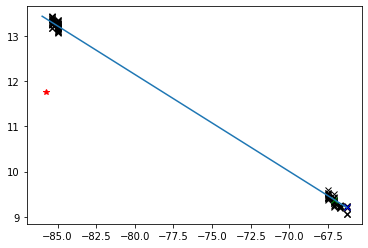

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     50355       1    52  5105  310104  310104   47629  11.701426  -1.131015   
      55125       1    52  5105  310104  310104   52434  12.611503   7.632357   
      50063       1    52  5105  310104  310104   47333  -6.426945  -9.839796   
      50507       1    52  5105  310104  310104   47783   8.165517   8.381331   
      49739       1    52  5105  310104  310104   47006  -7.376303   9.224901   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      55516       1    52  5105  310104  310104   52825 -12.015271  -8.306731   
      55661       1    52  5105  310104  310104   52971  -2.585955 -14.599433   
      50045       1    52  5105  310104  310104   47315  -7.328103  -9.366473   
      55757       1    52  5105  310104  310104   53067   6.502648 -13.382725   
      557

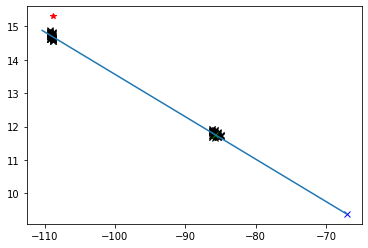

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     55873       1    52  5105  310104  310104   53183  15.237843  -1.415382   
      55122       1    52  5105  310104  310104   52431  12.675393   8.685817   
      55847       1    52  5105  310104  310104   53157  14.468268  -5.194855   
      55124       1    52  5105  310104  310104   52433  13.104911   8.052150   
      64542       1    52  5105  310104  310104   61892  24.522642   6.450631   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      55831       1    52  5105  310104  310104   53141  14.577659  -3.247768   
      55806       1    52  5105  310104  310104   53116  13.446338  -8.177952   
      55069       1    52  5105  310104  310104   52378  14.771238   2.111753   
      64580       1    52  5105  310104  310104   61930  20.663485  14.171522   
      550

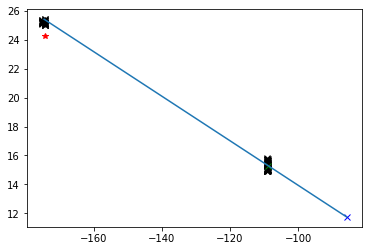

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     65162       1    52  5105  310104  310104   62515  24.175114  -2.069309   
      169107      1    52  5105  310104  310104  167366  17.391464  32.358570   
      169328      1    52  5105  310104  310104  167589 -27.694984  24.138205   
      169846      1    52  5105  310104  310104  168111  14.512180 -33.752617   
      169026      1    52  5105  310104  310104  167285  29.762228  21.523518   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      169657      1    52  5105  310104  310104  167922 -16.506638 -32.914543   
      168992      1    52  5105  310104  310104  167251  31.552628  19.087717   
      168949      1    52  5105  310104  310104  167208  35.664818   9.269503   
      169746      1    52  5105  310104  310104  168011  -0.561069 -36.820297   
      169

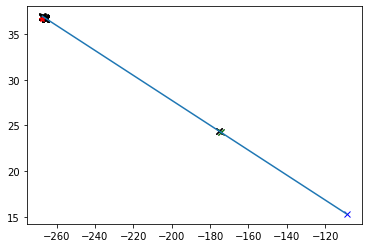

pid -22483.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     170062      1    52  5105  310104  310104  168330  36.573971  -2.747274   
      169699      1    52  5105  310104  310104  167964 -13.374792 -34.150608   
      169876      1    52  5105  310104  310104  168143  17.991724 -31.894773   
      169150      1    52  5105  310104  310104  167409  13.502216  34.106018   
      169698      1    52  5105  310104  310104  167963 -13.242649 -34.196846   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      170060      1    52  5105  310104  310104  168328  36.866199  -0.153685   
      169236      1    52  5105  310104  310104  167495  -0.153657  36.866203   
      169877      1    52  5105  310104  310104  168144  19.594423 -30.714476   
      169980      1    52  5105  310104  310104  168248  33.164577 -16.108707   
      169

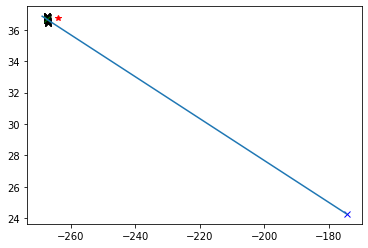

  2%|█▊                                                                                                                     | 3/200 [00:02<02:56,  1.12it/s]

pid -22480.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     15637       1    52  5105  310104  310104   12416   4.137370  -4.262071   
      13002       1    52  5105  310104  310104    9732  -4.882215   4.150523   
      13938       1    52  5105  310104  310104   10680  -5.781499  -2.766232   
      246412      1    52  5105  310104  310104  245625 -20.641294   8.917728   
      18972       1    52  5105  310104  310104   15829 -10.585490  -1.565094   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      14449       1    52  5105  310104  310104   11206  -4.183454  -4.856946   
      16331       1    52  5105  310104  310104   13150   6.299822  -1.180407   
      246415      1    52  5105  310104  310104  245628 -19.423796  11.026500   
      15403       1    52  5105  310104  310104   12169   2.361650  -5.949082   
      142

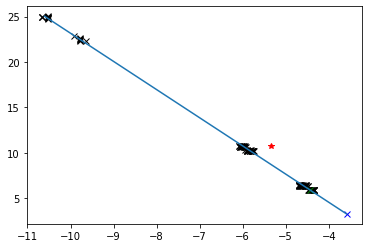

pid -22480.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     20356       1    52  5105  310104  310104   17237   4.209727  -9.863927   
      250029      1    52  5105  310104  310104  249271  22.782526   0.585418   
      23186       1    52  5105  310104  310104   20128 -14.402493   0.786556   
      19687       1    52  5105  310104  310104   16559  -5.144904  -8.826268   
      244076      1    52  5105  310104  310104  243250  17.048626  15.140411   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      246041      1    52  5105  310104  310104  245247 -18.611668  16.645771   
      19192       1    52  5105  310104  310104   16055  -9.410032  -3.999202   
      23313       1    52  5105  310104  310104   20258 -14.719230  -2.441145   
      17036       1    52  5105  310104  310104   13862   6.639637   8.492448   
      248

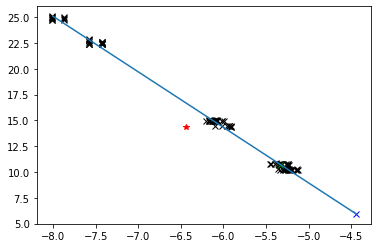

pid -22480.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     24642       1    52  5105  310104  310104   21615   7.914675 -12.033598   
      24509       1    52  5105  310104  310104   21479   4.233249 -14.304571   
      22713       1    52  5105  310104  310104   19651  -9.972425  11.099356   
      24202       1    52  5105  310104  310104   21168  -2.132568 -14.753998   
      246424      1    52  5105  310104  310104  245637 -17.498795  14.360698   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      243669      1    52  5105  310104  310104  242835  24.765120   1.876596   
      244526      1    52  5105  310104  310104  243704  17.297644  17.748367   
      25152       1    52  5105  310104  310104   22144  14.236444  -2.260283   
      24493       1    52  5105  310104  310104   21463   3.379711 -14.603237   
      224

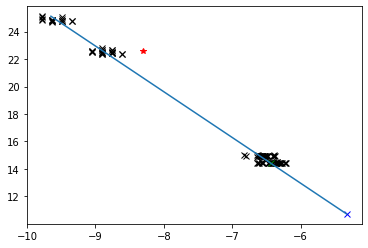

pid -22480.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     249425      1    52  5105  310104  310104  248653  11.619936 -19.405663   
      248368      1    52  5105  310104  310104  247591  -3.958704 -24.860037   
      269859      1    52  5105  310104  310104  269362 -23.448395 -28.838720   
      269371      1    52  5105  310104  310104  268872 -35.265583 -11.735177   
      269370      1    52  5105  310104  310104  268871 -35.254944 -11.763227   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      247200      1    52  5105  310104  310104  246416 -21.658962  -5.786619   
      244073      1    52  5105  310104  310104  243247  20.356127   9.411654   
      246826      1    52  5105  310104  310104  246042 -24.517731   3.279615   
      244949      1    52  5105  310104  310104  244140   3.290349  22.570557   
      247

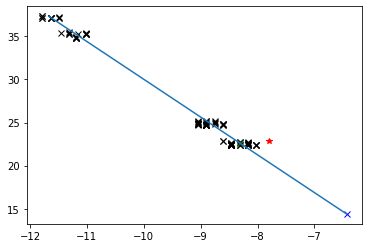

  2%|██▍                                                                                                                    | 4/200 [00:03<02:59,  1.09it/s]

pid -22479.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     44438       1    52  5105  310104  310104   41660 -4.185826 -3.672925   
      43062       1    52  5105  310104  310104   40276 -4.270363 -3.745336   
      44513       1    52  5105  310104  310104   41736 -2.730617 -4.851411   
      43173       1    52  5105  310104  310104   40391 -3.128252 -4.812315   
      48934       1    52  5105  310104  310104   46193 -4.764097 -6.709477   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      44010       1    52  5105  310104  310104   41230 -3.306344  4.634494   
      43097       1    52  5105  310104  310104   40313 -3.621633 -4.464858   
      50214       1    52  5105  310104  310104   47485  2.963689 -7.804994   
      43754       1    52  5105  310104  310104   40973  4.164958  3.587883   
      44471       1    52  5105  

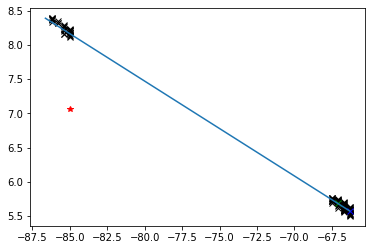

pid -22479.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     48920       1    52  5105  310104  310104   46179 -5.313562 -4.650180   
      47536       1    52  5105  310104  310104   44783 -5.392333 -4.718813   
      48655       1    52  5105  310104  310104   45914 -6.557706  2.617872   
      48958       1    52  5105  310104  310104   46218 -4.718655 -5.322124   
      48694       1    52  5105  310104  310104   45953 -6.609975  2.625581   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      47205       1    52  5105  310104  310104   44452 -4.562466  5.661948   
      54620       1    52  5105  310104  310104   51928 -9.504519 -4.066783   
      54939       1    52  5105  310104  310104   52248  7.798395 -6.620492   
      54475       1    52  5105  310104  310104   51783 -9.746714  3.272782   
      47821       1    52  5105  

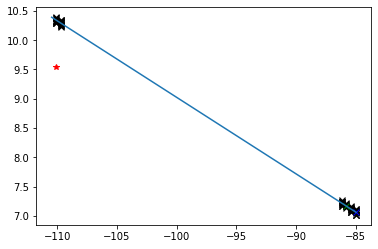

  2%|██▉                                                                                                                    | 5/200 [00:03<02:31,  1.29it/s]

pid -22478.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     262454      1    52  5105  310104  310104  261873  27.942097 -26.645096   
      281225      1    52  5105  310104  310104  280921 -45.117298  30.117281   
      281467      1    52  5105  310104  310104  281168  52.711002 -12.791176   
      281190      1    52  5105  310104  310104  280886 -21.710213  49.703526   
      281167      1    52  5105  310104  310104  280863   3.668680  54.131371   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      262039      1    52  5105  310104  310104  261456   5.355068  38.018257   
      281034      1    52  5105  310104  310104  280730  52.872643  12.223257   
      262417      1    52  5105  310104  310104  261834  16.707516 -34.213631   
      184731      1    52  5105  310104  310104  183127 -39.034733  52.336227   
      262

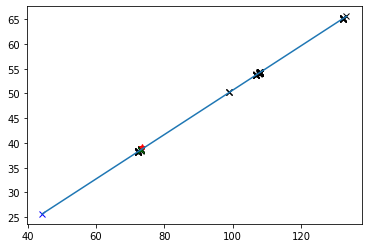

pid -22478.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     262454      1    52  5105  310104  310104  261873  27.942097 -26.645096   
      262480      1    52  5105  310104  310104  261899  28.274437 -27.005150   
      262367      1    52  5105  310104  310104  261784  -6.192220 -38.602898   
      333         1    52  5105  310104  310104  279560 -50.761539  15.907111   
      262170      1    52  5105  310104  310104  261587 -30.172041  24.877377   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      261967      1    52  5105  310104  310104  261384  32.017124  22.204315   
      262476      1    52  5105  310104  310104  261895  25.886688 -29.120510   
      262406      1    52  5105  310104  310104  261823   9.291453 -37.839008   
      262173      1    52  5105  310104  310104  261590 -32.066536  22.132727   
      262

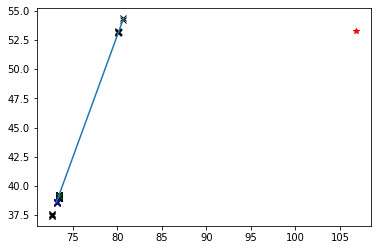

pid -22478.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     281444      1    52  5105  310104  310104  281144  38.494362 -36.890839   
      281196      1    52  5105  310104  310104  280892 -23.043102  48.204464   
      281265      1    52  5105  310104  310104  280961 -53.201370   3.496321   
      281418      1    52  5105  310104  310104  281115  23.499170 -47.864395   
      281400      1    52  5105  310104  310104  281096   5.854206 -52.989830   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      281247      1    52  5105  310104  310104  280943 -53.449005   8.605743   
      281254      1    52  5105  310104  310104  280950 -53.140797   0.156320   
      281248      1    52  5105  310104  310104  280944 -53.485474   8.398933   
      281047      1    52  5105  310104  310104  280743  46.360981  27.963163   
      281

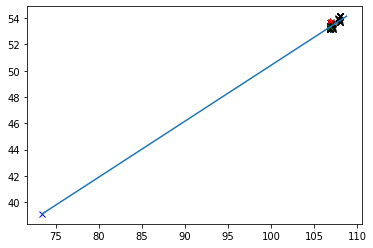

pid -22478.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     281444      1    52  5105  310104  310104  281144  38.494362 -36.890839   
      281435      1    52  5105  310104  310104  281134  38.830830 -37.186218   
      281265      1    52  5105  310104  310104  280961 -53.201370   3.496321   
      281418      1    52  5105  310104  310104  281115  23.499170 -47.864395   
      281400      1    52  5105  310104  310104  281096   5.854206 -52.989830   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      281183      1    52  5105  310104  310104  280879 -16.728197  52.257282   
      281086      1    52  5105  310104  310104  280782  28.616920  46.013321   
      281287      1    52  5105  310104  310104  280983 -51.601231 -16.571739   
      281240      1    52  5105  310104  310104  280936 -54.201958   8.342492   
      281

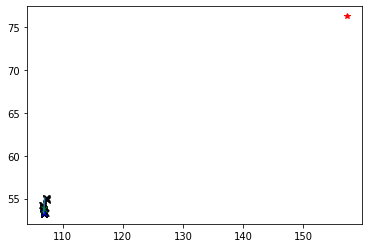

pid -22478.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     195991      1    52  5105  310104  310104  194545  55.589893 -52.261566   
      195999      1    52  5105  310104  310104  194553  55.589893 -52.261566   
      196015      1    52  5105  310104  310104  194570  60.714226 -46.206486   
      196016      1    52  5105  310104  310104  194571  60.671749 -46.258942   
      196073      1    52  5105  310104  310104  194632  74.992012 -14.023506   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      196025      1    52  5105  310104  310104  194581  63.523422 -50.722221   
      196084      1    52  5105  310104  310104  194644  81.140060  -4.941798   
      196055      1    52  5105  310104  310104  194614  71.978249 -37.785835   
      196047      1    52  5105  310104  310104  194606  71.925133 -37.890083   
      196

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide


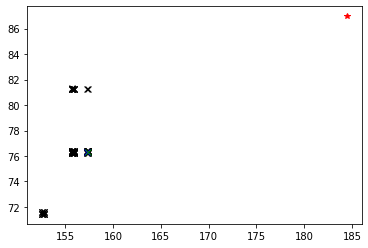

pid -22478.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     204202      1    52  5105  310104  310104  202854  63.795849 -59.114826   
      204207      1    52  5105  310104  310104  202859  63.795849 -59.114826   
      204199      1    52  5105  310104  310104  202851  58.964783 -63.931843   
      204194      1    52  5105  310104  310104  202846  58.911434 -63.980194   
      204188      1    52  5105  310104  310104  202840  51.261398 -70.258705   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      204254      1    52  5105  310104  310104  202906  79.602768 -19.452335   
      204249      1    52  5105  310104  310104  202901  79.572151 -19.574558   
      204250      1    52  5105  310104  310104  202902  79.551376 -19.657495   
      204255      1    52  5105  310104  310104  202907  79.539345 -19.705513   
      204

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: divide by zero encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide


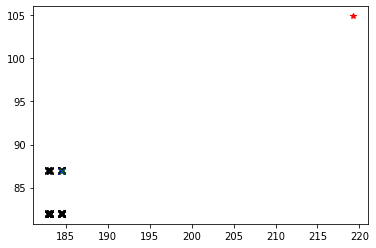

  3%|███▌                                                                                                                   | 6/200 [00:05<03:05,  1.04it/s]

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     11617       1    52  5105  310104  310104    8323   3.669078   5.251641   
      245190      1    52  5105  310104  310104  244388   7.266876  20.644871   
      14978       1    52  5105  310104  310104   11741  -0.941930  -6.331218   
      249319      1    52  5105  310104  310104  248547   4.401671 -24.220463   
      14017       1    52  5105  310104  310104   10769  -5.655777  -3.069751   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      19755       1    52  5105  310104  310104   16628  -5.787020  -8.499093   
      248962      1    52  5105  310104  310104  248187  -1.307668 -21.885250   
      17166       1    52  5105  310104  310104   13995   7.607895   7.524190   
      243945      1    52  5105  310104  310104  243117  23.231997   7.982802   
      183

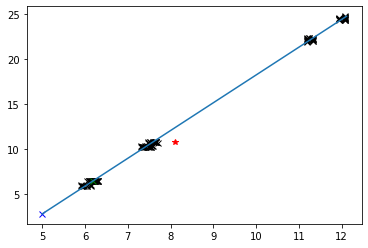

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     17176       1    52  5105  310104  310104   14005   8.179859   6.952226   
      244868      1    52  5105  310104  310104  244049  13.827457  19.734013   
      244873      1    52  5105  310104  310104  244054  17.002712  17.069658   
      24908       1    52  5105  310104  310104   21888  11.832365  -8.234936   
      243984      1    52  5105  310104  310104  243156  23.271149   6.263481   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      249348      1    52  5105  310104  310104  248576   5.304122 -23.615311   
      25071       1    52  5105  310104  310104   22060  13.630458  -6.159755   
      247120      1    52  5105  310104  310104  246336 -23.100048   7.233848   
      23072       1    52  5105  310104  310104   20014 -14.291628   4.270240   
      247

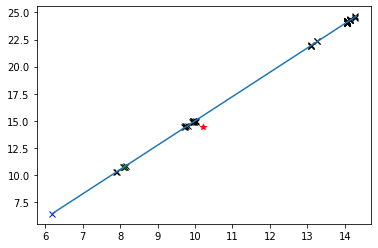

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     21716       1    52  5105  310104  310104   18639  11.104559   9.260117   
      232775      1    52  5105  310104  310104  231720 -20.870747  15.608310   
      21285       1    52  5105  310104  310104   18206  14.835314   1.410868   
      246738      1    52  5105  310104  310104  245953 -17.154348  14.058296   
      232456      1    52  5105  310104  310104  231398  27.260052   1.513471   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      233168      1    52  5105  310104  310104  232119  25.174185  -6.877759   
      21884       1    52  5105  310104  310104   18809   6.967080  13.219523   
      23363       1    52  5105  310104  310104   20310 -14.668285  -2.893284   
      248978      1    52  5105  310104  310104  248203  -0.152668 -21.885250   
      248

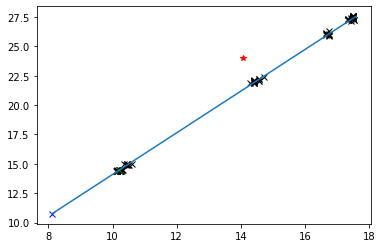

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     244870      1    52  5105  310104  310104  244051  15.286773  18.509502   
      244871      1    52  5105  310104  310104  244052  15.328905  18.474150   
      245572      1    52  5105  310104  310104  244770   0.247668  24.005251   
      249930      1    52  5105  310104  310104  249170  20.750322 -12.069888   
      249346      1    52  5105  310104  310104  248574   8.170184 -22.572149   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      247891      1    52  5105  310104  310104  247110 -19.222990 -14.715304   
      249932      1    52  5105  310104  310104  249172  19.220322 -14.719926   
      243977      1    52  5105  310104  310104  243149  23.091423   7.282757   
      246340      1    52  5105  310104  310104  245550 -12.992211  20.434868   
      247

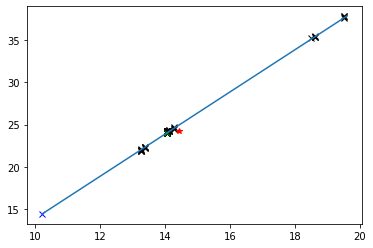

pid -22476.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     244870      1    52  5105  310104  310104  244051  15.286773  18.509502   
      244847      1    52  5105  310104  310104  244027  15.450067  18.711889   
      258793      1    52  5105  310104  310104  258135  23.703207 -29.828665   
      244871      1    52  5105  310104  310104  244052  15.328905  18.474150   
      245572      1    52  5105  310104  310104  244770   0.247668  24.005251   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      258614      1    52  5105  310104  310104  257951 -35.627129 -13.348001   
      246303      1    52  5105  310104  310104  245510 -16.847839  17.539019   
      258795      1    52  5105  310104  310104  258137  25.334961 -28.383057   
      258692      1    52  5105  310104  310104  258034  -9.214490 -36.912655   
      258

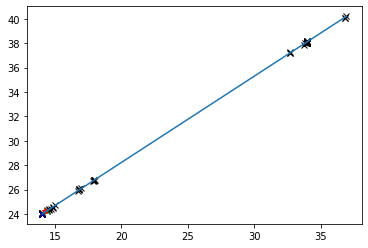

  4%|████▊                                                                                                                  | 8/200 [00:06<02:28,  1.29it/s]

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     85228       1    52  5105  310104  310104   82736   4.696200   3.051658   
      85263       1    52  5105  310104  310104   82771   4.798038   3.116317   
      85346       1    52  5105  310104  310104   82854   3.942100   3.977871   
      242468      1    52  5105  310104  310104  241627  25.123707  -7.664861   
      85599       1    52  5105  310104  310104   83108  -3.128259   4.788238   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      90566       1    52  5105  310104  310104   88155   5.926393  -5.749850   
      241473      1    52  5105  310104  310104  240620  17.579266  20.212315   
      89953       1    52  5105  310104  310104   87525  -7.635906   3.446593   
      91257       1    52  5105  310104  310104   88851  -4.583662  -7.380088   
      241

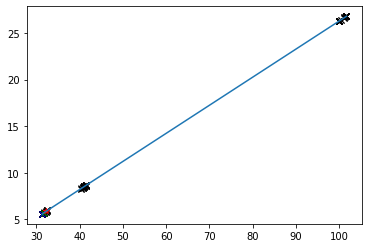

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     85263       1    52  5105  310104  310104   82771   4.798038  3.116317   
      83796       1    52  5105  310104  310104   81281   4.932115  3.201865   
      85599       1    52  5105  310104  310104   83108  -3.128259  4.788238   
      85399       1    52  5105  310104  310104   82907   1.011925  5.467398   
      84672       1    52  5105  310104  310104   82171  -2.698717 -5.222190   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      241245      1    52  5105  310104  310104  240390  26.188890 -5.913218   
      84183       1    52  5105  310104  310104   81670  -3.240349  5.018656   
      86196       1    52  5105  310104  310104   83715   2.884680 -4.678247   
      85416       1    52  5105  310104  310104   82924   1.610864  5.254326   
      85687       1  

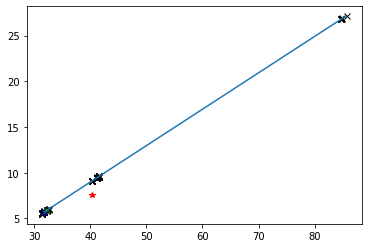

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     89480       1    52  5105  310104  310104   87048   6.382861   4.123325   
      89866       1    52  5105  310104  310104   87436  -5.254049   5.608012   
      243345      1    52  5105  310104  310104  242509  -3.760727 -23.816734   
      243599      1    52  5105  310104  310104  242765  24.115513  -0.389254   
      243226      1    52  5105  310104  310104  242390 -18.232117 -15.791977   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      95718       1    52  5105  310104  310104   93364   1.511328  -9.995299   
      242671      1    52  5105  310104  310104  241830  16.086830  18.519260   
      243413      1    52  5105  310104  310104  242577   8.807570 -22.895384   
      243499      1    52  5105  310104  310104  242663  22.935942  -8.120136   
      242

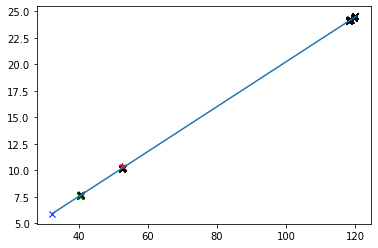

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     95090       1    52  5105  310104  310104   92732   8.781465   5.627463   
      100965      1    52  5105  310104  310104   98660 -12.702582  -5.186964   
      243238      1    52  5105  310104  310104  242402 -11.308107 -23.293571   
      95494       1    52  5105  310104  310104   93137 -10.355675  -1.228446   
      243310      1    52  5105  310104  310104  242474  -2.545727 -25.548687   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      95133       1    52  5105  310104  310104   92775   5.627183   9.027500   
      100602      1    52  5105  310104  310104   98297  10.016049   9.550795   
      243240      1    52  5105  310104  310104  242404  -7.939310 -24.519714   
      100554      1    52  5105  310104  310104   98249  11.458910   7.596415   
      956

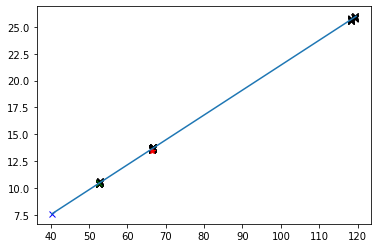

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     100557      1    52  5105  310104  310104   98252  11.315448   7.194877   
      100583      1    52  5105  310104  310104   98278  11.418778   7.257659   
      101030      1    52  5105  310104  310104   98726  -7.372366 -11.199940   
      180461      1    52  5105  310104  310104  178798  -5.149262  32.294018   
      335         1    52  5105  310104  310104  240935 -20.172457  12.773247   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      180421      1    52  5105  310104  310104  178758   5.894888  31.751957   
      242194      1    52  5105  310104  310104  241353  -1.035728 -23.816734   
      242187      1    52  5105  310104  310104  241346   1.089272 -23.816734   
      100904      1    52  5105  310104  310104   98599 -13.092944  -2.475766   
      241

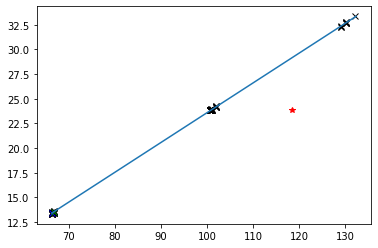

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     242607      1    52  5105  310104  310104  241766  20.263762  12.535607   
      178137      1    52  5105  310104  310104  176466   7.761155  24.998308   
      243126      1    52  5105  310104  310104  242290 -23.578323  -3.435804   
      243125      1    52  5105  310104  310104  242289 -23.568773  -3.489968   
      242726      1    52  5105  310104  310104  241886   7.399430  22.652067   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      243603      1    52  5105  310104  310104  242769  23.769953  -2.349022   
      242724      1    52  5105  310104  310104  241884   6.436245  23.002638   
      242613      1    52  5105  310104  310104  241772  21.558762  10.292601   
      178132      1    52  5105  310104  310104  176461   5.525493  25.649460   
      179

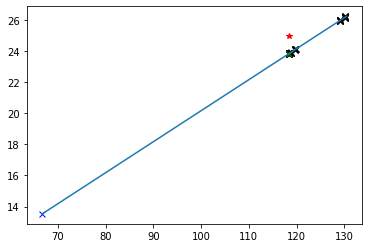

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     242607      1    52  5105  310104  310104  241766  20.263762  12.535607   
      242579      1    52  5105  310104  310104  241738  21.275179  13.119550   
      243126      1    52  5105  310104  310104  242290 -23.578323  -3.435804   
      243125      1    52  5105  310104  310104  242289 -23.568773  -3.489968   
      242726      1    52  5105  310104  310104  241886   7.399430  22.652067   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      242614      1    52  5105  310104  310104  241773  21.831263   9.820618   
      243129      1    52  5105  310104  310104  242293 -23.876129  -1.746858   
      242603      1    52  5105  310104  310104  241762  19.401262  14.029501   
      242738      1    52  5105  310104  310104  241898  -0.480726  27.730637   
      243

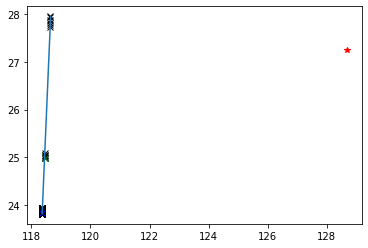

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     177984      1    52  5105  310104  310104  176308  23.216171  14.242236   
      178254      1    52  5105  310104  310104  176583  -2.114044  27.155216   
      190087      1    52  5105  310104  310104  188575 -32.309772   3.905678   
      190256      1    52  5105  310104  310104  188744 -19.561102 -26.009981   
      190330      1    52  5105  310104  310104  188818  -4.971481 -32.169456   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      178096      1    52  5105  310104  310104  176424  14.932758  22.864334   
      177987      1    52  5105  310104  310104  176311  24.566793  11.591492   
      178247      1    52  5105  310104  310104  176576  -5.027724  26.693733   
      178861      1    52  5105  310104  310104  177192   1.328831 -27.279581   
      178

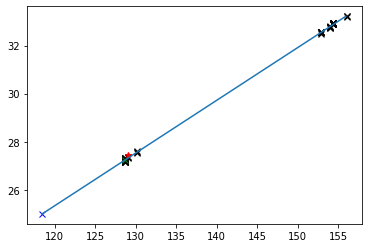

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     177968      1    52  5105  310104  310104  176292  23.409967  14.346592   
      177984      1    52  5105  310104  310104  176308  23.216171  14.242236   
      178254      1    52  5105  310104  310104  176583  -2.114044  27.155216   
      191416      1    52  5105  310104  310104  189906  41.132187  -0.174189   
      178608      1    52  5105  310104  310104  176939 -21.357069 -18.182152   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      178370      1    52  5105  310104  310104  176700 -18.711182  19.686981   
      178388      1    52  5105  310104  310104  176719 -25.278893  11.971160   
      178580      1    52  5105  310104  310104  176911 -24.491884 -11.738508   
      179145      1    52  5105  310104  310104  177478  26.911961  -3.649890   
      192

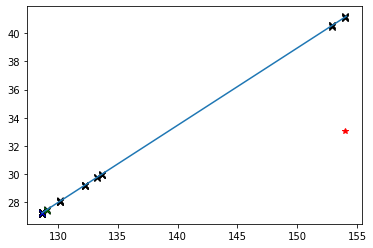

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     189714      1    52  5105  310104  310104  188200  28.288189  17.074045   
      189732      1    52  5105  310104  310104  188218  28.352470  17.110765   
      190155      1    52  5105  310104  310104  188643 -32.146713  -7.954029   
      189666      1    52  5105  310104  310104  188152  32.148670   7.939157   
      190128      1    52  5105  310104  310104  188616 -32.964737  -2.302452   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      190153      1    52  5105  310104  310104  188641 -32.439091  -5.733192   
      190149      1    52  5105  310104  310104  188637 -32.816963  -2.862959   
      198512      1    52  5105  310104  310104  197101 -30.018690  24.630552   
      190238      1    52  5105  310104  310104  188726 -26.955362 -18.931511   
      198

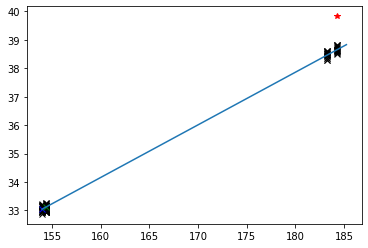

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     207884      1    52  5105  310104  310104  206575  41.469795  24.076653   
      207894      1    52  5105  310104  310104  206585  41.793240  24.249537   
      208424      1    52  5105  310104  310104  207119  45.731197 -15.596668   
      208357      1    52  5105  310104  310104  207052  21.330378 -43.353561   
      208423      1    52  5105  310104  310104  207118  45.702168 -15.692362   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      208713      1    52  5105  310104  310104  207408 -42.504818  27.931051   
      208558      1    52  5105  310104  310104  207253  22.754126  45.483654   
      208630      1    52  5105  310104  310104  207325 -14.510252  48.743877   
      208629      1    52  5105  310104  310104  207324 -14.452297  48.759407   
      208

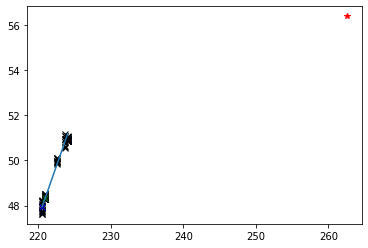

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     217708      1    52  5105  310104  310104  216486  49.071117  27.754511   
      217903      1    52  5105  310104  310104  216681 -41.556671  38.096596   
      217805      1    52  5105  310104  310104  216583   2.436632  56.324154   
      218214      1    52  5105  310104  310104  216994  44.096016 -35.123409   
      218213      1    52  5105  310104  310104  216993  44.157711 -35.051170   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      217959      1    52  5105  310104  310104  216739 -53.920055  16.755362   
      217960      1    52  5105  310104  310104  216740 -53.938732  16.677572   
      217833      1    52  5105  310104  310104  216611  -7.934631  55.891449   
      217879      1    52  5105  310104  310104  216657 -39.210590  40.605232   
      217

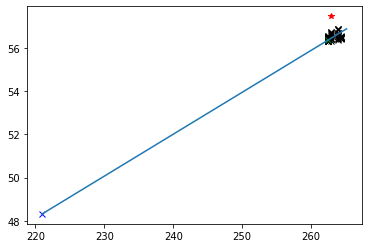

pid -22475.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     217708      1    52  5105  310104  310104  216486  49.071117  27.754511   
      217705      1    52  5105  310104  310104  216483  50.004009  28.337915   
      217903      1    52  5105  310104  310104  216681 -41.556671  38.096596   
      217805      1    52  5105  310104  310104  216583   2.436632  56.324154   
      218214      1    52  5105  310104  310104  216994  44.096016 -35.123409   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      218133      1    52  5105  310104  310104  216913  12.406116 -54.737915   
      217759      1    52  5105  310104  310104  216537  21.134970  51.991245   
      218050      1    52  5105  310104  310104  216830 -36.718025 -42.444698   
      217799      1    52  5105  310104  310104  216577   4.069265  55.974930   
      217

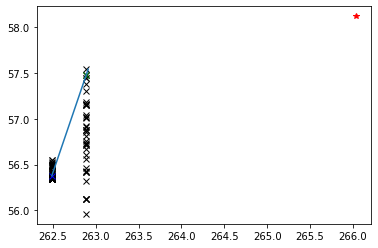

  4%|█████▎                                                                                                                 | 9/200 [00:09<04:26,  1.39s/it]

pid -22474.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     88776       1    52  5105  310104  310104   86329 -3.018255 -0.959808   
      88705       1    52  5105  310104  310104   86255 -3.055382 -0.971174   
      88071       1    52  5105  310104  310104   85617  2.514718  1.989691   
      93253       1    52  5105  310104  310104   90872 -1.353515 -4.095011   
      93187       1    52  5105  310104  310104   90801 -1.340658 -4.060184   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      88757       1    52  5105  310104  310104   86310 -2.898689 -1.425048   
      93474       1    52  5105  310104  310104   91097  3.369470 -2.734841   
      89075       1    52  5105  310104  310104   86639  0.090266 -3.230776   
      88556       1    52  5105  310104  310104   86103 -3.121617  0.977472   
      88642       1    52  5105  

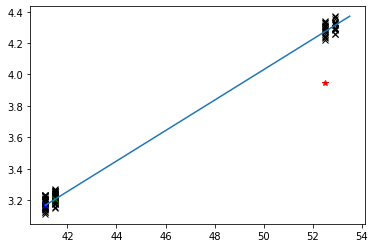

pid -22474.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     93092       1    52  5105  310104  310104   90703 -3.761273 -1.199578   
      93014       1    52  5105  310104  310104   90623 -3.793056 -1.212037   
      98413       1    52  5105  310104  310104   96081  0.890079  5.044031   
      93429       1    52  5105  310104  310104   91052  2.021161 -3.432546   
      93585       1    52  5105  310104  310104   91209  3.679699 -1.525576   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      99011       1    52  5105  310104  310104   96689 -3.433911 -3.715319   
      93105       1    52  5105  310104  310104   90716 -3.752653 -0.995973   
      92577       1    52  5105  310104  310104   90182  0.678022  3.857363   
      93390       1    52  5105  310104  310104   91013  1.182569 -3.871066   
      99362       1    52  5105  

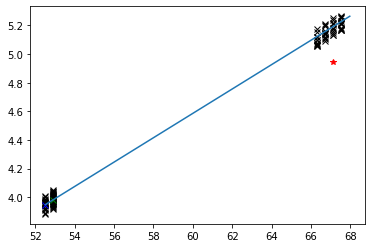

pid -22474.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     97575       1    52  5105  310104  310104   95238 -4.705834 -1.506896   
      97486       1    52  5105  310104  310104   95148 -4.747747 -1.520177   
      102472      1    52  5105  310104  310104  100181  0.658481 -6.962171   
      97199       1    52  5105  310104  310104   94860 -2.792803  4.129285   
      102619      1    52  5105  310104  310104  100328  4.631151 -5.239303   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      97447       1    52  5105  310104  310104   95109 -4.999192 -0.734131   
      98950       1    52  5105  310104  310104   96622 -4.205974 -2.638375   
      97355       1    52  5105  310104  310104   95017 -4.999491  0.314717   
      103141      1    52  5105  310104  310104  100854 -1.167114  6.876081   
      98788       1    52  5105  

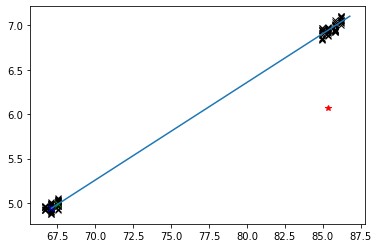

pid -22474.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     103526      1    52  5105  310104  310104  101243 -5.775373 -1.859053   
      108256      1    52  5105  310104  310104  106041 -4.622260 -5.892334   
      108248      1    52  5105  310104  310104  106032 -4.174576 -6.215940   
      102085      1    52  5105  310104  310104   99791 -6.074516 -0.695071   
      101605      1    52  5105  310104  310104   99309  1.372541  5.957079   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      103995      1    52  5105  310104  310104  101724  4.622164 -3.977651   
      108638      1    52  5105  310104  310104  106426  6.582622 -3.505728   
      102992      1    52  5105  310104  310104  100704  4.342165  4.122505   
      536         1    52  5105  310104  310104  106130 -2.495593 -7.120196   
      101483      1    52  5105  

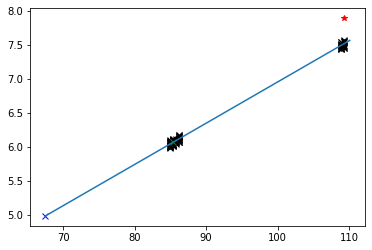

pid -22474.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     108130      1    52  5105  310104  310104  105912  -7.504860 -2.434630   
      113974      1    52  5105  310104  310104  111802  -9.205217 -4.580071   
      108547      1    52  5105  310104  310104  106335   5.040124 -6.068505   
      113491      1    52  5105  310104  310104  111316   8.262887  6.072493   
      107889      1    52  5105  310104  310104  105669  -5.208254  5.930524   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      107901      1    52  5105  310104  310104  105681  -5.469677  5.547612   
      114034      1    52  5105  310104  310104  111863  -7.266074 -7.132523   
      113939      1    52  5105  310104  310104  111765 -10.348865 -0.318499   
      114255      1    52  5105  310104  310104  112089   7.767828 -6.578099   
      113914      1  

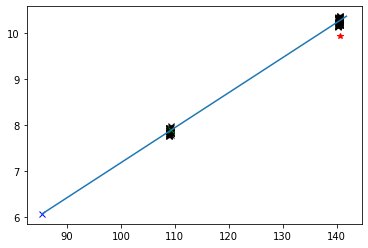

pid -22474.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     113959      1    52  5105  310104  310104  111786 -9.453766  -3.090536   
      116695      1    52  5105  310104  310104  114556  3.114658  11.785044   
      117296      1    52  5105  310104  310104  115162  8.372225  -8.934278   
      116860      1    52  5105  310104  310104  114721 -7.860394   9.382356   
      116647      1    52  5105  310104  310104  114508  6.718953  10.230624   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      116706      1    52  5105  310104  310104  114567  2.650019  11.990055   
      114202      1    52  5105  310104  310104  112036  4.658306  -8.891065   
      117320      1    52  5105  310104  310104  115186  9.477928  -7.512843   
      114119      1    52  5105  310104  310104  111950 -1.924111  -9.855491   
      117183      1  

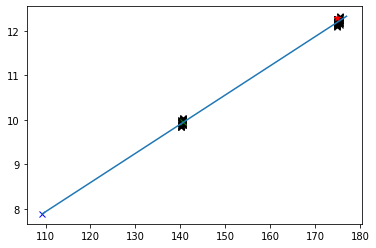

  5%|█████▉                                                                                                                | 10/200 [00:11<04:26,  1.40s/it]

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     14545       1    52  5105  310104  310104   11303  -3.657120  -5.260817   
      234364      1    52  5105  310104  310104  233356 -21.973269   9.836262   
      17673       1    52  5105  310104  310104   14512   0.236890  10.795856   
      13132       1    52  5105  310104  310104    9863  -5.198377   3.738492   
      20454       1    52  5105  310104  310104   17345   3.927230 -10.007867   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      17440       1    52  5105  310104  310104   14277   4.871084   8.965786   
      20668       1    52  5105  310104  310104   17573   8.235839  -6.189139   
      14552       1    52  5105  310104  310104   11310  -3.926318  -5.054254   
      19582       1    52  5105  310104  310104   16454  -6.969767  -8.162318   
      133

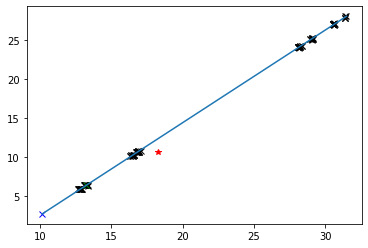

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     19593       1    52  5105  310104  310104   16465  -8.089114  -7.042971   
      236072      1    52  5105  310104  310104  235114 -25.619926  -7.085161   
      83645       1    52  5105  310104  310104   81129  11.765962 -10.841375   
      18626       1    52  5105  310104  310104   15478  -8.867316   6.165687   
      20886       1    52  5105  310104  310104   17797   9.427202  -5.066849   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      18134       1    52  5105  310104  310104   14977  -4.757082   9.585036   
      236483      1    52  5105  310104  310104  235539  25.462223  -7.247913   
      235901      1    52  5105  310104  310104  234939 -12.880568  23.200695   
      236481      1    52  5105  310104  310104  235537  25.768023  -6.976897   
      206

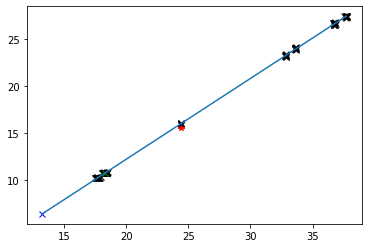

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     83495       1    52  5105  310104  310104   80966 -10.274242 -11.620461   
      236235      1    52  5105  310104  310104  235279  -9.191080 -24.583706   
      83696       1    52  5105  310104  310104   81181  15.753487  -1.593409   
      2016        1    52  5105  310104  310104   81087   8.759868 -13.156034   
      83372       1    52  5105  310104  310104   80842 -14.157336   7.021028   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      235852      1    52  5105  310104  310104  234890  -3.091332  25.863522   
      236027      1    52  5105  310104  310104  235067 -25.975277   1.628975   
      236387      1    52  5105  310104  310104  235432  13.137250 -21.694645   
      83227       1    52  5105  310104  310104   80697  10.540977  10.840335   
      834

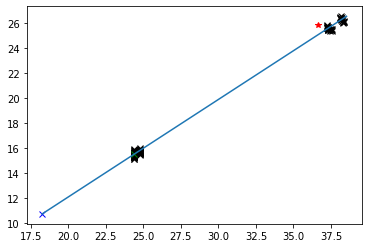

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     236205      1    52  5105  310104  310104  235249 -17.357676 -19.136055   
      260138      1    52  5105  310104  310104  259520  -5.143136  36.689255   
      235933      1    52  5105  310104  310104  234971  -7.860582  24.612186   
      235739      1    52  5105  310104  310104  234773  21.840796  13.803366   
      260137      1    52  5105  310104  310104  259519  -9.177032  35.818764   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      236150      1    52  5105  310104  310104  235194 -22.691195 -14.730433   
      235874      1    52  5105  310104  310104  234912  -1.406332  27.016367   
      236009      1    52  5105  310104  310104  235048 -21.216965  14.883875   
      236404      1    52  5105  310104  310104  235451  18.343832 -18.308571   
      236

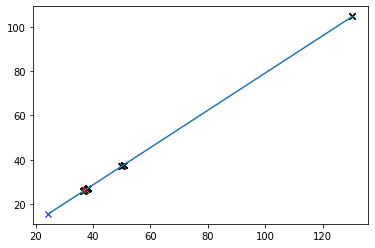

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     236205      1    52  5105  310104  310104  235249 -17.357676 -19.136055   
      236172      1    52  5105  310104  310104  235216 -17.624050 -19.422392   
      235933      1    52  5105  310104  310104  234971  -7.860582  24.612186   
      235739      1    52  5105  310104  310104  234773  21.840796  13.803366   
      235823      1    52  5105  310104  310104  234861   7.848991  24.616405   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      259544      1    52  5105  310104  310104  258904  20.524185  32.104683   
      259708      1    52  5105  310104  310104  259068 -37.290352   7.855604   
      236408      1    52  5105  310104  310104  235455  14.073135 -21.892111   
      259615      1    52  5105  310104  310104  258975  -7.657136  36.317146   
      259

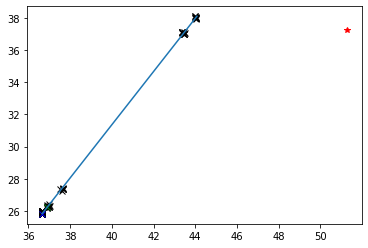

pid -22471.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     260395      1    52  5105  310104  310104  259781 -25.409319 -27.205639   
      260223      1    52  5105  310104  310104  259605 -30.030270  22.002388   
      260585      1    52  5105  310104  310104  259973  34.403660 -14.227751   
      260083      1    52  5105  310104  310104  259465  16.309631  33.467213   
      260537      1    52  5105  310104  310104  259925  24.068027 -28.393919   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      260438      1    52  5105  310104  310104  259824 -11.414106 -35.513596   
      260056      1    52  5105  310104  310104  259438  32.096291  19.009239   
      260536      1    52  5105  310104  310104  259924  22.731936 -29.577593   
      260082      1    52  5105  310104  310104  259464  19.599102  31.740765   
      279

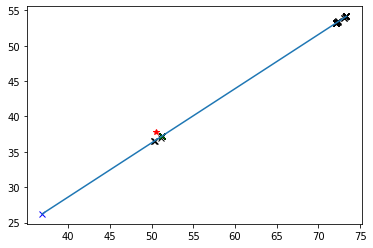

  6%|███████                                                                                                               | 12/200 [00:12<03:42,  1.18s/it]

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     80050       1    52  5105  310104  310104   77470  0.398384  3.977572   
      83714       1    52  5105  310104  310104   81199  4.601840 -0.054535   
      84766       1    52  5105  310104  310104   82266 -0.363186 -4.586362   
      84397       1    52  5105  310104  310104   81888 -4.425181  1.124850   
      79986       1    52  5105  310104  310104   77406  2.340247  3.202546   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      84190       1    52  5105  310104  310104   81677 -2.751872  3.768110   
      83956       1    52  5105  310104  310104   81443  1.864180  4.101950   
      83828       1    52  5105  310104  310104   81313  4.126246  1.806414   
      79925       1    52  5105  310104  310104   77344  2.396954  3.282605   
      84627       1    52  5105  

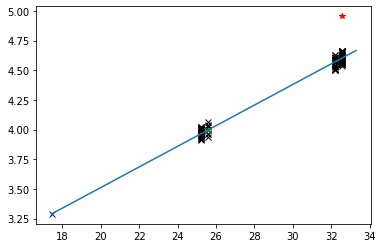

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     89689       1    52  5105  310104  310104   87258  0.614139  5.980423   
      88239       1    52  5105  310104  310104   85785  0.633775  6.150959   
      94060       1    52  5105  310104  310104   91685 -4.022494  7.345242   
      93978       1    52  5105  310104  310104   91602 -1.131720  8.298021   
      95231       1    52  5105  310104  310104   92874 -2.126332  8.278471   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      90257       1    52  5105  310104  310104   87838 -3.510244 -4.968233   
      94580       1    52  5105  310104  310104   92218 -2.268240 -8.136223   
      88027       1    52  5105  310104  310104   85573  5.230719  2.990710   
      90351       1    52  5105  310104  310104   87937 -1.096138 -5.836835   
      95879       1    52  5105  

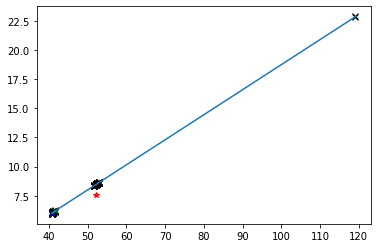

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     93944       1    52  5105  310104  310104   91568  0.788809  7.537058   
      99620       1    52  5105  310104  310104   97306  8.393790  4.545346   
      99767       1    52  5105  310104  310104   97454 -0.656744  9.522129   
      99668       1    52  5105  310104  310104   97354  2.250581  9.272390   
      100369      1    52  5105  310104  310104   98063  6.706809 -6.858983   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      99796       1    52  5105  310104  310104   97483 -3.263741  9.176130   
      100224      1    52  5105  310104  310104   97917 -2.060760 -9.236307   
      100155      1    52  5105  310104  310104   97847 -4.923883 -8.078090   
      99939       1    52  5105  310104  310104   97626 -8.344054  4.345135   
      100479      1    52  5105  

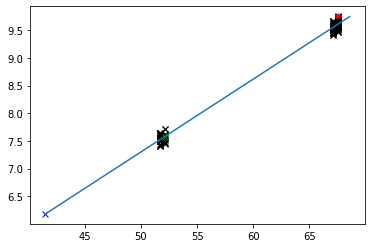

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     99727       1    52  5105  310104  310104   97414   1.042920   9.693441   
      105647      1    52  5105  310104  310104  103396 -10.283632  -6.691220   
      99738       1    52  5105  310104  310104   97425  -0.130138   9.746899   
      104257      1    52  5105  310104  310104  101986   6.159201  10.739302   
      100001      1    52  5105  310104  310104   97688  -9.745184  -0.347219   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      104134      1    52  5105  310104  310104  101863  12.387314   0.794919   
      99895       1    52  5105  310104  310104   97582  -8.311759   5.260743   
      100032      1    52  5105  310104  310104   97719  -9.779286   0.146046   
      104132      1    52  5105  310104  310104  101861  12.368993   1.045921   
      104

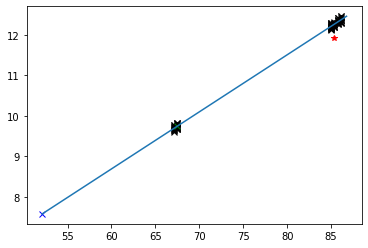

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     104304      1    52  5105  310104  310104  102033   1.328875  12.018705   
      105325      1    52  5105  310104  310104  103072   1.306378  11.848311   
      187405      1    52  5105  310104  310104  185881  -6.081794  25.709879   
      187670      1    52  5105  310104  310104  186146 -26.319193   2.234737   
      2862        1    52  5105  310104  310104  186678  20.897167 -16.152472   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      104633      1    52  5105  310104  310104  102366 -12.141021  -0.553204   
      187086      1    52  5105  310104  310104  185562  26.799639   0.139094   
      104174      1    52  5105  310104  310104  101903  11.008103   5.355145   
      187672      1    52  5105  310104  310104  186148 -26.178991   2.182157   
      104

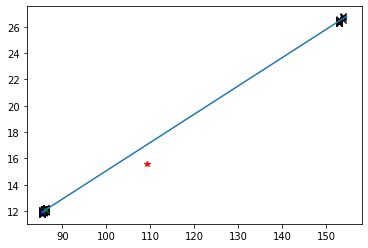

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     109895      1    52  5105  310104  310104  107696   1.777493  15.483856   
      110005      1    52  5105  310104  310104  107806 -12.863110   8.685549   
      110046      1    52  5105  310104  310104  107847 -12.951557   8.678862   
      110127      1    52  5105  310104  310104  107928 -15.575516   0.080807   
      109846      1    52  5105  310104  310104  107647   7.733274  13.547800   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      109862      1    52  5105  310104  310104  107663   2.958107  14.617487   
      109875      1    52  5105  310104  310104  107676   5.056709  14.018460   
      109716      1    52  5105  310104  310104  107517  14.620574   2.882010   
      110011      1    52  5105  310104  310104  107812 -12.110695   8.671275   
      109

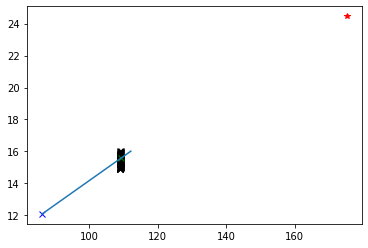

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     119172      1    52  5105  310104  310104  117063   3.047409  24.266947   
      213344      1    52  5105  310104  310104  212097   8.153069  35.964886   
      213613      1    52  5105  310104  310104  212369 -35.725506   8.312247   
      3410        1    52  5105  310104  310104  117355  -9.353374 -22.596718   
      213428      1    52  5105  310104  310104  212181 -15.979883  33.239044   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      213611      1    52  5105  310104  310104  212367 -36.597153   0.576198   
      214202      1    52  5105  310104  310104  212964  36.494370  -2.798665   
      213753      1    52  5105  310104  310104  212510 -32.781528 -16.718325   
      213133      1    52  5105  310104  310104  211884  33.932621  13.997747   
      213

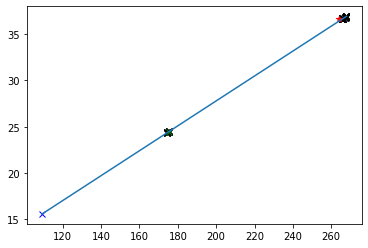

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     214507      1    52  5105  310104  310104  213269   5.065560  36.249817   
      214879      1    52  5105  310104  310104  213644 -30.478073 -20.266687   
      213327      1    52  5105  310104  310104  212080   5.143436  36.673061   
      214726      1    52  5105  310104  310104  213491 -34.251751  12.896352   
      213144      1    52  5105  310104  310104  211895  35.810257   8.631771   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      213685      1    52  5105  310104  310104  212441 -33.677933 -15.391862   
      213989      1    52  5105  310104  310104  212751   7.699193 -36.369717   
      214144      1    52  5105  310104  310104  212906  31.908993 -18.106960   
      213709      1    52  5105  310104  310104  212465 -35.134838 -10.562012   
      213

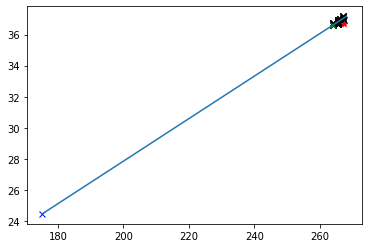

pid -22470.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     213345      1    52  5105  310104  310104  212098   5.092436  36.309734   
      213596      1    52  5105  310104  310104  212352 -34.938316  11.123632   
      214189      1    52  5105  310104  310104  212951  34.906940 -11.213302   
      213929      1    52  5105  310104  310104  212689  -5.032813 -36.316452   
      213165      1    52  5105  310104  310104  211916  29.702801  21.480227   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      213192      1    52  5105  310104  310104  211944  29.389826  22.116192   
      213755      1    52  5105  310104  310104  212512 -32.677784 -16.883436   
      213349      1    52  5105  310104  310104  212102   0.988404  36.772148   
      213754      1    52  5105  310104  310104  212511 -32.701725 -16.845333   
      214

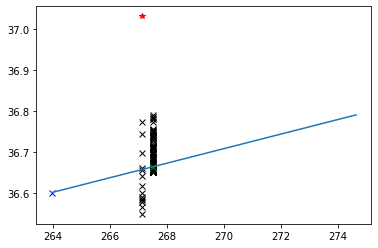

  6%|███████▋                                                                                                              | 13/200 [00:14<04:20,  1.39s/it]

pid -22468.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     59381       1    52  5105  310104  310104   56711  -9.099682  -7.819070   
      59207       1    52  5105  310104  310104   56536 -11.360429   3.850523   
      59705       1    52  5105  310104  310104   57037   8.906616  -7.957242   
      63217       1    52  5105  310104  310104   60562 -14.363976   8.056566   
      68767       1    52  5105  310104  310104   66143 -18.306721  -7.497769   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      60356       1    52  5105  310104  310104   57689  -6.870649  -9.780737   
      58807       1    52  5105  310104  310104   56133  11.936203   0.086225   
      63586       1    52  5105  310104  310104   60931   8.460310 -13.941525   
      63310       1    52  5105  310104  310104   60655 -16.069647  -2.776176   
      634

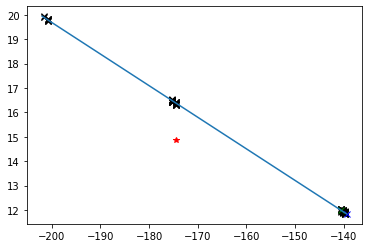

  7%|████████▎                                                                                                             | 14/200 [00:15<03:32,  1.14s/it]/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


pid -22467.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     302426      1    52  5105  310104  310104  302311 -67.720764  49.878338   
      299629      1    52  5105  310104  310104  299482  82.144157  18.064835   
      302425      1    52  5105  310104  310104  302310 -68.403183  48.939068   
      304251      1    52  5105  310104  310104  304173 -41.431263 -73.195740   
      301807      1    52  5105  310104  310104  301686 -26.740585  79.744690   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      304088      1    52  5105  310104  310104  304010 -55.098774 -63.805500   
      303221      1    52  5105  310104  310104  303117 -84.285004  -1.846845   
      303220      1    52  5105  310104  310104  303116 -84.285004  -1.909845   
      304086      1    52  5105  310104  310104  304008 -54.921532 -63.965088   
      302

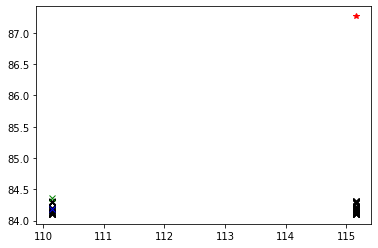

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


pid -22467.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     302426      1    52  5105  310104  310104  302311 -67.720764  49.878338   
      299629      1    52  5105  310104  310104  299482  82.144157  18.064835   
      302425      1    52  5105  310104  310104  302310 -68.403183  48.939068   
      304251      1    52  5105  310104  310104  304173 -41.431263 -73.195740   
      301807      1    52  5105  310104  310104  301686 -26.740585  79.744690   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      302103      1    52  5105  310104  310104  301986 -48.666077  72.507500   
      304405      1    52  5105  310104  310104  304327 -32.462414 -81.070236   
      304845      1    52  5105  310104  310104  304769  -3.755655 -87.264999   
      305862      1    52  5105  310104  310104  305792  67.411194 -55.547783   
      302

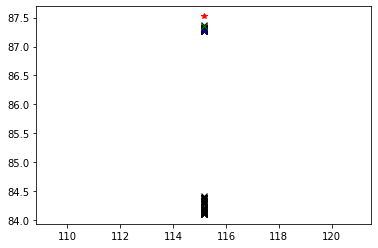

pid -22467.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     302426      1    52  5105  310104  310104  302311 -67.720764  49.878338   
      299629      1    52  5105  310104  310104  299482  82.144157  18.064835   
      302425      1    52  5105  310104  310104  302310 -68.403183  48.939068   
      304251      1    52  5105  310104  310104  304173 -41.431263 -73.195740   
      301807      1    52  5105  310104  310104  301686 -26.740585  79.744690   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      302103      1    52  5105  310104  310104  301986 -48.666077  72.507500   
      304405      1    52  5105  310104  310104  304327 -32.462414 -81.070236   
      304845      1    52  5105  310104  310104  304769  -3.755655 -87.264999   
      305862      1    52  5105  310104  310104  305792  67.411194 -55.547783   
      302

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


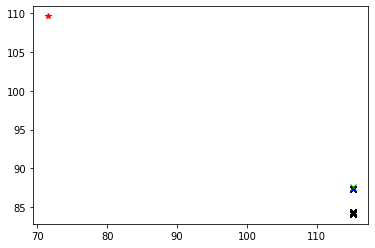

  8%|████████▊                                                                                                             | 15/200 [00:16<03:12,  1.04s/it]

pid -22464.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     25721       1    52  5105  310104  310104   22719 -2.230338  3.719231   
      30987       1    52  5105  310104  310104   28060 -2.051445  4.726302   
      25787       1    52  5105  310104  310104   22787 -2.791451  3.383653   
      25605       1    52  5105  310104  310104   22602 -1.391639  4.159926   
      29244       1    52  5105  310104  310104   26292  4.400022  2.866217   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      31031       1    52  5105  310104  310104   28104 -4.293511  2.768429   
      30947       1    52  5105  310104  310104   28019 -2.007767  4.642212   
      25751       1    52  5105  310104  310104   22750 -2.699850  3.451249   
      30295       1    52  5105  310104  310104   27357  0.513044 -5.180942   
      26175       1    52  5105  

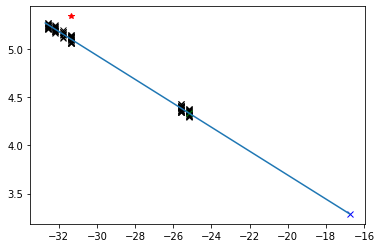

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
  8%|█████████▍                                                                                                            | 16/200 [00:16<02:37,  1.16it/s]

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     83647       1    52  5105  310104  310104   81131   8.999292  -8.891006   
      83623       1    52  5105  310104  310104   81107   9.224060  -9.105622   
      236249      1    52  5105  310104  310104  235293  -3.926605 -24.066227   
      83668       1    52  5105  310104  310104   81153  11.988763  -4.931048   
      235731      1    52  5105  310104  310104  234765  20.573513  11.443573   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      236453      1    52  5105  310104  310104  235505  22.013760  -9.786718   
      237160      1    52  5105  310104  310104  236223 -12.525721 -24.857189   
      83522       1    52  5105  310104  310104   80994  -2.848012 -12.648369   
      237418      1    52  5105  310104  310104  236495  27.150440  -0.600072   
      235

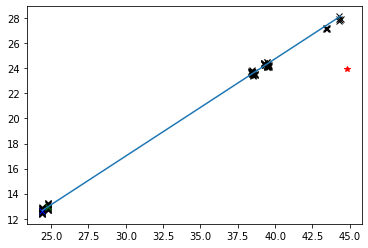

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     237348      1    52  5105  310104  310104  236418  17.290010 -16.539286   
      261890      1    52  5105  310104  310104  261307  38.830936   6.151396   
      261571      1    52  5105  310104  310104  260978 -35.330486  -3.809777   
      236944      1    52  5105  310104  310104  236006 -21.899065   9.636972   
      237389      1    52  5105  310104  310104  236465  19.556358 -15.059429   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      236861      1    52  5105  310104  310104  235920  -9.815280  21.737543   
      261915      1    52  5105  310104  310104  261332  37.149387  11.290987   
      237249      1    52  5105  310104  310104  236314   1.738668 -23.783632   
      262151      1    52  5105  310104  310104  261568 -30.693304  24.696463   
      237

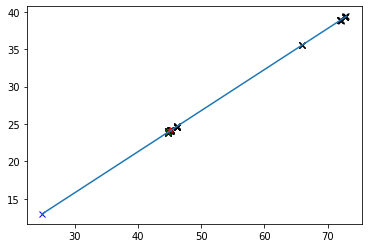

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     237348      1    52  5105  310104  310104  236418  17.290010 -16.539286   
      237316      1    52  5105  310104  310104  236382  17.482382 -16.721872   
      236974      1    52  5105  310104  310104  236037 -23.722258   7.821827   
      236676      1    52  5105  310104  310104  235735  18.827400  16.815752   
      236944      1    52  5105  310104  310104  236006 -21.899065   9.636972   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      237067      1    52  5105  310104  310104  236130 -23.979080  -0.972364   
      237229      1    52  5105  310104  310104  236294   3.543669 -23.920109   
      236902      1    52  5105  310104  310104  235962 -12.915578  21.776361   
      237256      1    52  5105  310104  310104  236321  -1.791332 -23.783632   
      236

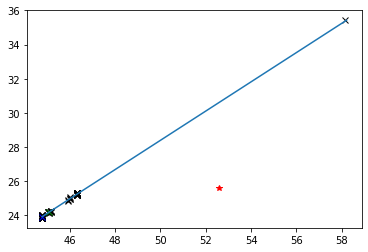

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     238123      1    52  5105  310104  310104  237218  18.599005 -17.609228   
      237550      1    52  5105  310104  310104  236627  19.130070  17.378702   
      181500      1    52  5105  310104  310104  179841 -38.945530  12.494024   
      181291      1    52  5105  310104  310104  179632  17.549461  36.710289   
      182437      1    52  5105  310104  310104  180785 -29.616674 -27.022436   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      237587      1    52  5105  310104  310104  236664   4.618540  25.126232   
      181651      1    52  5105  310104  310104  179992 -19.820589 -35.660564   
      238658      1    52  5105  310104  310104  237765 -24.516691  11.453564   
      264998      1    52  5105  310104  310104  264458 -16.698906  34.225021   
      265

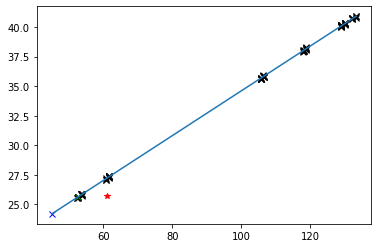

pid -22463.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     239069      1    52  5105  310104  310104  238186  18.762085 -17.608183   
      242709      1    52  5105  310104  310104  241869   4.417048  26.138641   
      178821      1    52  5105  310104  310104  177152   7.146753 -25.689734   
      238732      1    52  5105  310104  310104  237841 -24.440638   8.091265   
      241668      1    52  5105  310104  310104  240819 -11.881540  23.421789   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      239750      1    52  5105  310104  310104  238876 -25.916042  -0.151848   
      239620      1    52  5105  310104  310104  238744 -20.835072  15.292007   
      177908      1    52  5105  310104  310104  176232  25.988718   6.196820   
      243306      1    52  5105  310104  310104  242470   3.964274 -26.253773   
      240

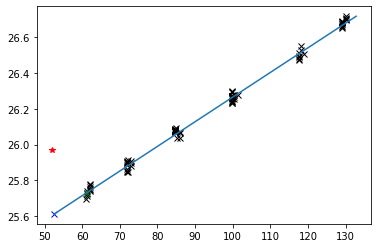

  8%|██████████                                                                                                            | 17/200 [00:17<02:46,  1.10it/s]

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     26314       1    52  5105  310104  310104   23316 -0.213002 -3.661606   
      26399       1    52  5105  310104  310104   23403 -0.218600 -3.750498   
      29553       1    52  5105  310104  310104   26606 -1.710358  4.932827   
      25401       1    52  5105  310104  310104   22395  3.626315  0.979300   
      31321       1    52  5105  310104  310104   28395 -3.504139 -3.627703   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      31264       1    52  5105  310104  310104   28338 -4.517153 -2.357785   
      25570       1    52  5105  310104  310104   22567  0.532149  3.591583   
      26463       1    52  5105  310104  310104   23467  2.228928 -2.865999   
      29844       1    52  5105  310104  310104   26900 -5.182443 -0.119575   
      25858       1    52  5105  

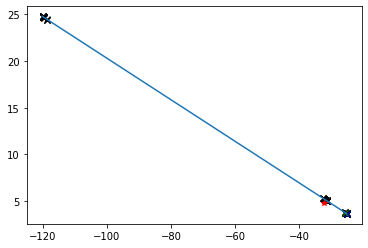

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     35730       1    52  5105  310104  310104   32863 -0.368989 -6.029172   
      34428       1    52  5105  310104  310104   31543 -0.382326 -6.225413   
      39490       1    52  5105  310104  310104   36665 -2.719602  8.418451   
      2911        1    52  5105  310104  310104   37737  6.286325  6.634020   
      40499       1    52  5105  310104  310104   37685  8.836076  1.913312   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      39599       1    52  5105  310104  310104   36777 -7.357909  5.173356   
      36053       1    52  5105  310104  310104   33191  6.089824 -0.116217   
      35727       1    52  5105  310104  310104   32860 -0.664182 -6.054948   
      40394       1    52  5105  310104  310104   37579  8.436641 -3.122219   
      33800       1    52  5105  

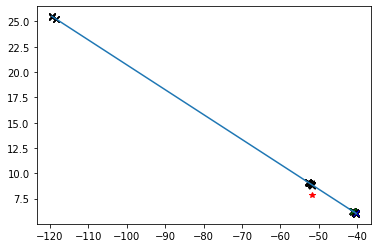

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     40116       1    52  5105  310104  310104   37298  -0.504765  -7.866833   
      45296       1    52  5105  310104  310104   42524  -9.045990   4.863029   
      39759       1    52  5105  310104  310104   36937  -7.886603   0.099753   
      45187       1    52  5105  310104  310104   42414  -0.648239  10.306016   
      45279       1    52  5105  310104  310104   42507  -8.212086   6.180035   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      45044       1    52  5105  310104  310104   42271   6.582189   7.688975   
      40392       1    52  5105  310104  310104   37577   7.579483  -2.843916   
      45408       1    52  5105  310104  310104   42637 -10.149486  -0.800371   
      45059       1    52  5105  310104  310104   42286   5.376886   8.929317   
      399

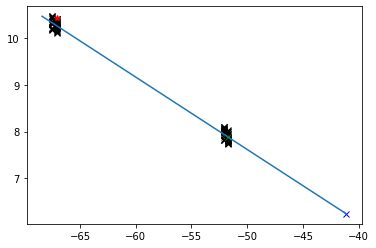

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     45625       1    52  5105  310104  310104   42855  -0.707305 -10.419395   
      45821       1    52  5105  310104  310104   43055   9.651092  -4.170780   
      45846       1    52  5105  310104  310104   43080  10.288263  -1.817184   
      51203       1    52  5105  310104  310104   48487  13.419439   0.141597   
      45760       1    52  5105  310104  310104   42991   5.083999  -9.204535   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      45619       1    52  5105  310104  310104   42849  -0.907171 -10.539342   
      50954       1    52  5105  310104  310104   48232  -2.546130 -13.100053   
      45053       1    52  5105  310104  310104   42280   5.876656   8.798216   
      51011       1    52  5105  310104  310104   48290   2.576942 -13.373005   
      508

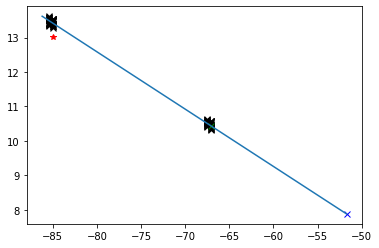

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     50996       1    52  5105  310104  310104   48275  -0.932182 -12.971642   
      51018       1    52  5105  310104  310104   48297   1.833999 -12.933121   
      51192       1    52  5105  310104  310104   48476  12.948081  -1.263970   
      50757       1    52  5105  310104  310104   48034 -12.785372   2.414858   
      50989       1    52  5105  310104  310104   48268  -1.594961 -12.916424   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      50481       1    52  5105  310104  310104   47756   9.489145   9.252599   
      51162       1    52  5105  310104  310104   48446  12.495228  -2.835520   
      50984       1    52  5105  310104  310104   48263  -2.524200 -13.016042   
      50879       1    52  5105  310104  310104   48157 -11.804501  -4.963168   
      511

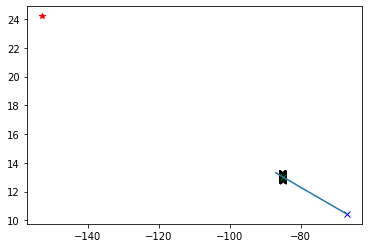

pid -22462.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     144056      1    52  5105  310104  310104  142134  -2.122610 -24.109022   
      143858      1    52  5105  310104  310104  141936 -19.436628 -14.712618   
      143737      1    52  5105  310104  310104  141815 -23.654770   5.928416   
      143912      1    52  5105  310104  310104  141990 -19.125504 -14.812160   
      143913      1    52  5105  310104  310104  141991 -19.093683 -14.843979   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      144145      1    52  5105  310104  310104  142223   3.539505 -24.552986   
      143879      1    52  5105  310104  310104  141957 -22.262053 -10.944650   
      143483      1    52  5105  310104  310104  141559  -4.245702  24.441135   
      143768      1    52  5105  310104  310104  141846 -24.440351   4.250652   
      143

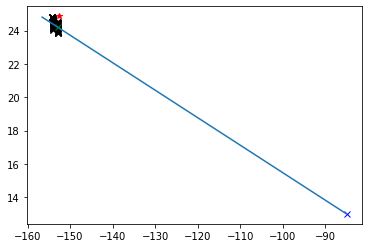

  9%|██████████▌                                                                                                           | 18/200 [00:19<03:21,  1.11s/it]

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     25272       1    52  5105  310104  310104   22265  3.482618  0.292148   
      29242       1    52  5105  310104  310104   26290  3.089170  2.231975   
      29723       1    52  5105  310104  310104   26778 -3.262503  1.935895   
      29332       1    52  5105  310104  310104   26381  2.411743  2.928013   
      25578       1    52  5105  310104  310104   22575  0.323007  3.477731   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      25545       1    52  5105  310104  310104   22541  1.075323  3.393330   
      29446       1    52  5105  310104  310104   26497  0.426035  3.704684   
      26392       1    52  5105  310104  310104   23394  0.013550 -3.577425   
      26466       1    52  5105  310104  310104   23470  2.230427 -2.775346   
      26338       1    52  5105  

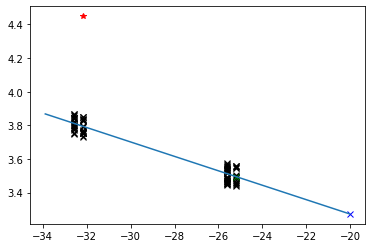

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     34812       1    52  5105  310104  310104   31932   5.552934   0.450200   
      33359       1    52  5105  310104  310104   30465   5.645859   0.457591   
      33923       1    52  5105  310104  310104   31033  -4.774297   3.048502   
      40560       1    52  5105  310104  310104   37748   6.605387   5.215021   
      40633       1    52  5105  310104  310104   37824   3.140638   7.807554   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      222991      1    52  5105  310104  310104  221834  18.536694 -15.175791   
      40616       1    52  5105  310104  310104   37806   1.739434   8.290424   
      33636       1    52  5105  310104  310104   30744   0.979682   5.634122   
      40311       1    52  5105  310104  310104   37494   6.427446  -5.053332   
      352

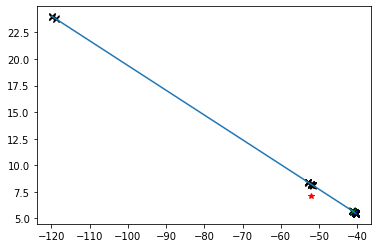

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     39160       1    52  5105  310104  310104   36332  7.106597   0.563029   
      37703       1    52  5105  310104  310104   34866  7.199267   0.569475   
      45192       1    52  5105  310104  310104   42419 -0.317801  10.697717   
      40013       1    52  5105  310104  310104   37195 -3.569576  -6.060362   
      37956       1    52  5105  310104  310104   35122  1.366130   7.083226   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      45219       1    52  5105  310104  310104   42446 -4.573842   9.706271   
      39291       1    52  5105  310104  310104   36465  4.166799   5.930436   
      40006       1    52  5105  310104  310104   37188 -3.832099  -6.044911   
      45496       1    52  5105  310104  310104   42726 -8.952784  -5.642327   
      40304       1  

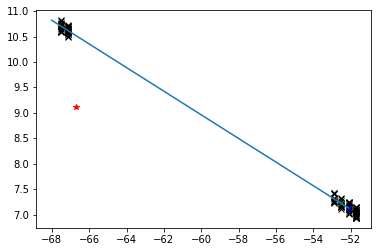

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     43636       1    52  5105  310104  310104   40855  9.080338   0.694624   
      44939       1    52  5105  310104  310104   42164  9.253221   0.705070   
      45663       1    52  5105  310104  310104   42893  0.986460  -9.226274   
      50473       1    52  5105  310104  310104   47748  9.786586   8.654209   
      45832       1    52  5105  310104  310104   43066  8.760914  -2.797041   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      45537       1    52  5105  310104  310104   42767 -4.702205  -7.768659   
      51106       1    52  5105  310104  310104   48385  9.018443  -9.603824   
      45779       1    52  5105  310104  310104   43011  7.432515  -5.600756   
      50955       1    52  5105  310104  310104   48233 -2.726036 -12.978307   
      50494       1  

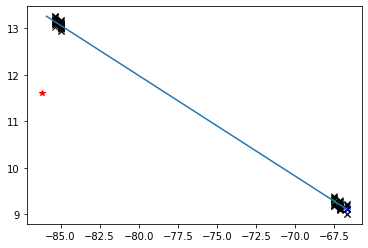

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     49464       1    52  5105  310104  310104   46731  11.572586   0.846518   
      55161       1    52  5105  310104  310104   52470  10.668234   9.710872   
      55218       1    52  5105  310104  310104   52527   6.193043  13.031541   
      49537       1    52  5105  310104  310104   46804   9.485020   6.691949   
      50295       1    52  5105  310104  310104   47569   9.731165  -6.239601   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      55770       1    52  5105  310104  310104   53080   8.397598 -11.946755   
      49578       1    52  5105  310104  310104   46845   5.989934  10.086792   
      49763       1    52  5105  310104  310104   47030  -8.023429   8.062971   
      51174       1    52  5105  310104  310104   48458  10.930188  -4.132040   
      553

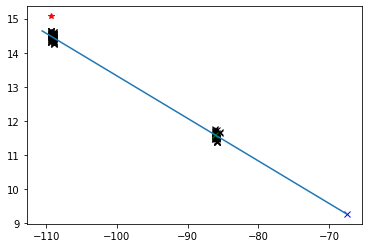

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     55080       1    52  5105  310104  310104   52389  15.034621   1.027348   
      64749       1    52  5105  310104  310104   62100 -17.034649  18.099117   
      64991       1    52  5105  310104  310104   62344  -3.449049 -24.727144   
      55205       1    52  5105  310104  310104   52514   7.833746  12.812980   
      55707       1    52  5105  310104  310104   53017   1.003449 -15.047035   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      64582       1    52  5105  310104  310104   61932  20.526457  14.602345   
      55567       1    52  5105  310104  310104   52876 -11.158280  -9.705545   
      65145       1    52  5105  310104  310104   62498  24.602840  -5.431639   
      64579       1    52  5105  310104  310104   61929  20.643534  13.652254   
      645

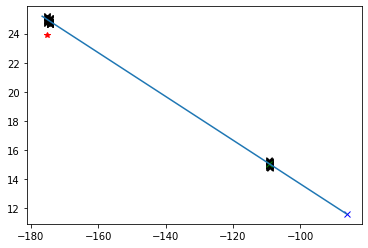

pid -22461.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     168921      1    52  5105  310104  310104  167180  36.213783   1.358222   
      169090      1    52  5105  310104  310104  167349  21.517025  29.159914   
      169173      1    52  5105  310104  310104  167432   1.477419  36.200348   
      169252      1    52  5105  310104  310104  167511 -14.347318  33.266327   
      169878      1    52  5105  310104  310104  168145  21.781361 -29.167074   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      170061      1    52  5105  310104  310104  168329  36.603642  -2.483940   
      169902      1    52  5105  310104  310104  168169  20.926546 -30.137331   
      169233      1    52  5105  310104  310104  167492  -2.389510  36.614281   
      3030        1    52  5105  310104  310104  167570 -27.260078  24.261913   
      169

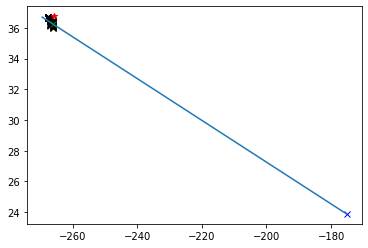

 10%|███████████▏                                                                                                          | 19/200 [00:20<03:57,  1.31s/it]

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     92528       1    52  5105  310104  310104   90132  2.039907  2.569043   
      92455       1    52  5105  310104  310104   90057  2.063171  2.596980   
      92445       1    52  5105  310104  310104   90047  2.262922  2.425547   
      92432       1    52  5105  310104  310104   90034  2.452057  2.236411   
      93133       1    52  5105  310104  310104   90747 -2.514816 -2.159494   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      92621       1    52  5105  310104  310104   90226 -0.253777  3.224450   
      96934       1    52  5105  310104  310104   94591  1.608165  4.227259   
      93112       1    52  5105  310104  310104   90723 -2.871781 -1.823495   
      93186       1    52  5105  310104  310104   90800 -0.826156 -3.086354   
      92779       1    52  5105  

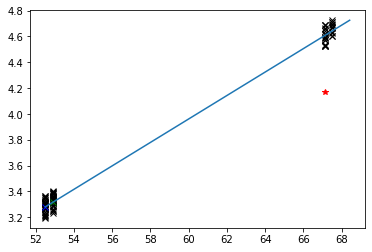

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     96985       1    52  5105  310104  310104   94643  2.597943  3.262259   
      96906       1    52  5105  310104  310104   94562  2.618055  3.288038   
      103383      1    52  5105  310104  310104  101098 -5.494840  1.231861   
      97170       1    52  5105  310104  310104   94831 -1.724637  3.830828   
      101834      1    52  5105  310104  310104   99540 -2.947866  4.915463   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      102869      1    52  5105  310104  310104  100580  5.134155  2.248433   
      102904      1    52  5105  310104  310104  100615  5.100671  2.243046   
      97110       1    52  5105  310104  310104   94770 -0.688798  4.053251   
      103024      1    52  5105  310104  310104  100737  1.900991  5.272151   
      98068       1    52  5105  

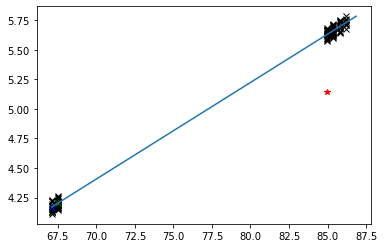

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     102970      1    52  5105  310104  310104  100682  3.210988  4.020971   
      103248      1    52  5105  310104  310104  100962 -2.029088  4.726901   
      108086      1    52  5105  310104  310104  105868 -6.404671 -0.642109   
      108485      1    52  5105  310104  310104  106273  3.609765 -5.329435   
      107239      1    52  5105  310104  310104  105011  4.148250 -4.978769   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      107016      1    52  5105  310104  310104  104786 -0.538280 -6.514938   
      106064      1    52  5105  310104  310104  103826  5.752373  2.893101   
      103646      1    52  5105  310104  310104  101368 -3.519920 -3.806291   
      102343      1    52  5105  310104  310104  100051 -1.605343 -4.997802   
      101847      1    52  5105  

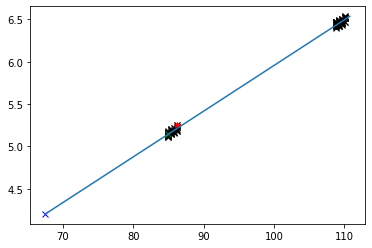

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     101510      1    52  5105  310104  310104   99212  3.276511  4.102058   
      103268      1    52  5105  310104  310104  100982 -2.970530  4.244213   
      101795      1    52  5105  310104  310104   99500 -2.059231  4.828908   
      101847      1    52  5105  310104  310104   99553 -3.015580  4.296679   
      108403      1    52  5105  310104  310104  106190  1.261552 -7.108218   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      107671      1    52  5105  310104  310104  105448  1.184044  7.226512   
      102233      1    52  5105  310104  310104   99940 -3.819026 -3.501354   
      107956      1    52  5105  310104  310104  105738 -6.165697  3.691077   
      106355      1    52  5105  310104  310104  104119 -1.248877  7.253841   
      107126      1    52  5105  

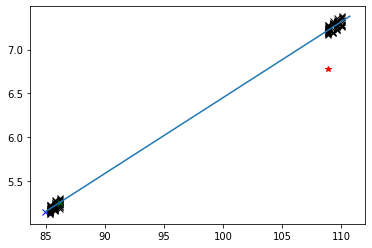

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     106158      1    52  5105  310104  310104  103920  4.310215  5.376178   
      113391      1    52  5105  310104  310104  111216  9.568241  1.724913   
      106318      1    52  5105  310104  310104  104082  0.282712  6.874963   
      106290      1    52  5105  310104  310104  104054  0.946533  6.815185   
      114076      1    52  5105  310104  310104  111906 -3.106736 -9.208654   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      106048      1    52  5105  310104  310104  103810  5.858661  3.334461   
      114231      1    52  5105  310104  310104  112065  5.472204 -7.909734   
      107457      1    52  5105  310104  310104  105230  6.336119  2.183305   
      114079      1    52  5105  310104  310104  111910 -3.409821 -9.234822   
      113798      1    52  5105  

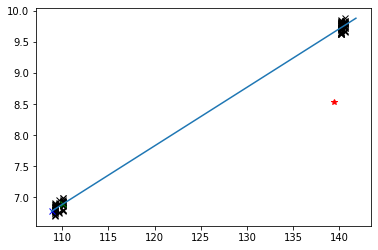

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     113532      1    52  5105  310104  310104  111357  5.422633   6.736323   
      113924      1    52  5105  310104  310104  111750 -8.581798  -0.742754   
      114348      1    52  5105  310104  310104  112182  8.640029  -0.415429   
      114051      1    52  5105  310104  310104  111880 -5.025956  -7.040704   
      113393      1    52  5105  310104  310104  111218  8.499592   1.367171   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      116679      1    52  5105  310104  310104  114540  4.522095  10.921326   
      112807      1    52  5105  310104  310104  110629 -8.017870  -3.295623   
      113713      1    52  5105  310104  310104  111538 -3.724031   7.701406   
      112599      1    52  5105  310104  310104  110420 -7.694581   3.995198   
      114271      1  

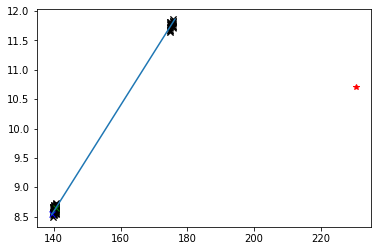

pid -22460.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     125623      1    52  5105  310104  310104  123558   6.946054  8.144607   
      125872      1    52  5105  310104  310104  123810  -6.671196  8.391157   
      130724      1    52  5105  310104  310104  128697  -7.003845  9.100145   
      131011      1    52  5105  310104  310104  128984  -9.086476 -7.063225   
      131018      1    52  5105  310104  310104  128991  -9.077683 -7.032385   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      131397      1    52  5105  310104  310104  129370  10.030178 -5.787151   
      125331      1    52  5105  310104  310104  123265   7.221165 -7.762103   
      125669      1    52  5105  310104  310104  123604   4.279444  9.913739   
      126204      1    52  5105  310104  310104  124142  -4.504075 -9.813925   
      130941      1  

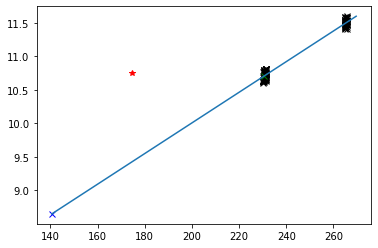

 10%|███████████▊                                                                                                          | 20/200 [00:22<04:12,  1.40s/it]

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     10978       1    52  5105  310104  310104    7677   5.893280   2.496371   
      226360      1    52  5105  310104  310104  225221 -22.183207   8.726458   
      27984       1    52  5105  310104  310104   25009   5.288197   7.125828   
      12903       1    52  5105  310104  310104    9625  -5.042619   3.941481   
      226184      1    52  5105  310104  310104  225043   3.829062  23.543673   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      14379       1    52  5105  310104  310104   11135  -4.352048  -4.727580   
      15765       1    52  5105  310104  310104   12555   5.426639  -3.441016   
      28144       1    52  5105  310104  310104   25171  -6.602260   6.041383   
      28288       1    52  5105  310104  310104   25328  -7.597575  -4.432412   
      280

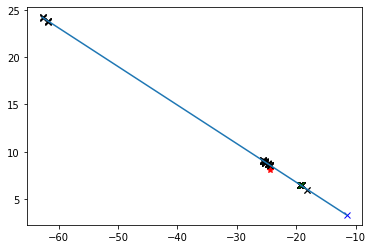

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     26723       1    52  5105  310104  310104   23731   7.479725  2.949504   
      32714       1    52  5105  310104  310104   29805  10.288536 -1.968514   
      32611       1    52  5105  310104  310104   29700   6.084421 -8.676649   
      27231       1    52  5105  310104  310104   24248  -7.911989  1.408543   
      26718       1    52  5105  310104  310104   23726   7.593412  2.660042   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      225976      1    52  5105  310104  310104  224833  21.732569 -8.447895   
      32727       1    52  5105  310104  310104   29818  10.368722 -0.208927   
      32610       1    52  5105  310104  310104   29699   6.163225 -8.754992   
      26879       1    52  5105  310104  310104   23887   3.976683  6.864433   
      27130       1  

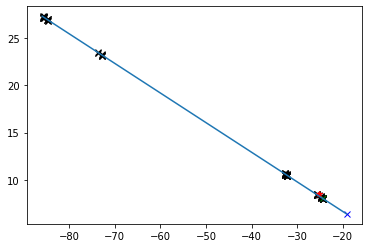

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     26723       1    52  5105  310104  310104   23731   7.479725   2.949504   
      27907       1    52  5105  310104  310104   24931   7.952752   3.142589   
      227649      1    52  5105  310104  310104  226533  25.786589  -2.481829   
      28526       1    52  5105  310104  310104   25567   5.992951  -6.104469   
      26779       1    52  5105  310104  310104   23787   7.504019   3.544670   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      226972      1    52  5105  310104  310104  225839  11.591025  23.129253   
      227595      1    52  5105  310104  310104  226479  23.939259 -11.533493   
      32804       1    52  5105  310104  310104   29895  11.925232   4.742788   
      27404       1    52  5105  310104  310104   24424  -6.315505  -4.840203   
      274

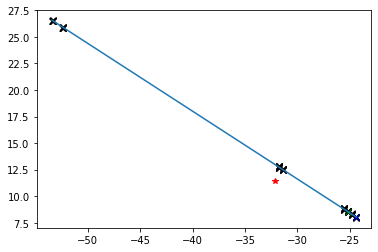

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     31905       1    52  5105  310104  310104   28987  10.597922   4.234210   
      225947      1    52  5105  310104  310104  224804  26.111177  -9.953354   
      37606       1    52  5105  310104  310104   34767  10.348526 -10.497175   
      32198       1    52  5105  310104  310104   29284 -11.229238   2.833016   
      225117      1    52  5105  310104  310104  223970  27.945684   0.394440   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      37331       1    52  5105  310104  310104   34489 -14.573574   0.499273   
      37073       1    52  5105  310104  310104   34223   9.032804  12.064601   
      226733      1    52  5105  310104  310104  225598  11.493672 -20.761749   
      226519      1    52  5105  310104  310104  225382 -19.268463 -13.908326   
      303

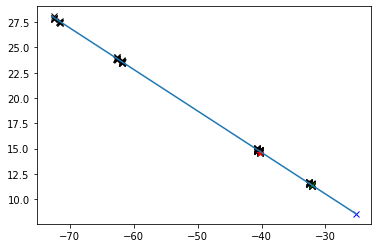

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     37035       1    52  5105  310104  310104   34185  13.697678   5.548444   
      37006       1    52  5105  310104  310104   34156  13.491875   5.460355   
      226638      1    52  5105  310104  310104  225503  -7.956923 -25.606071   
      226634      1    52  5105  310104  310104  225498 -10.428313 -24.706558   
      37124       1    52  5105  310104  310104   34274   4.024738  14.216423   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      226179      1    52  5105  310104  310104  225038  14.840653  22.510283   
      226336      1    52  5105  310104  310104  225197 -17.840832  19.572779   
      226640      1    52  5105  310104  310104  225505  -6.241983 -26.230257   
      1269        1    52  5105  310104  310104  225480  -8.265030 -25.151497   
      376

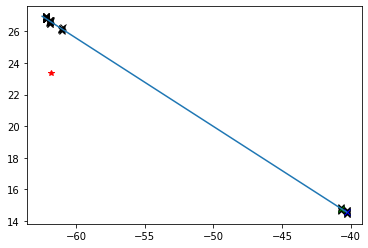

pid -22457.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     226083      1    52  5105  310104  310104  224942  21.517565   9.033280   
      139550      1    52  5105  310104  310104  137591 -43.531811 -26.831173   
      139276      1    52  5105  310104  310104  137315  35.316761  36.151157   
      252009      1    52  5105  310104  310104  251267   7.712916  35.111389   
      225170      1    52  5105  310104  310104  224023  25.107046  10.713072   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      139393      1    52  5105  310104  310104  137432 -23.413994  45.408104   
      252543      1    52  5105  310104  310104  251807  35.424664  -6.392668   
      139394      1    52  5105  310104  310104  137433 -23.391336  45.418671   
      226122      1    52  5105  310104  310104  224981  18.350508  15.095245   
      139

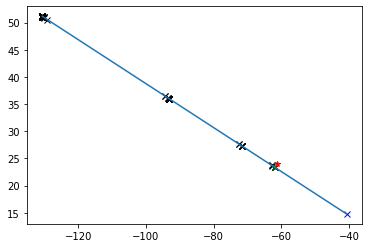

 10%|████████████▍                                                                                                         | 21/200 [00:24<04:30,  1.51s/it]

pid -22454.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     11348       1    52  5105  310104  310104    8050   4.921407   3.278108   
      237169      1    52  5105  310104  310104  236232  -6.195827 -25.403490   
      15224       1    52  5105  310104  310104   11988   0.416640  -5.896059   
      20434       1    52  5105  310104  310104   17321   4.575666  -9.677472   
      19568       1    52  5105  310104  310104   16440  -7.615786  -7.516299   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      237219      1    52  5105  310104  310104  236284  -3.526332 -25.444660   
      236537      1    52  5105  310104  310104  235596  24.522158   9.138393   
      12158       1    52  5105  310104  310104    8872   1.504330   6.257177   
      16944       1    52  5105  310104  310104   13770   8.475095   5.834119   
      140

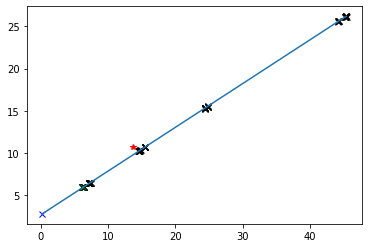

pid -22454.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     17197       1    52  5105  310104  310104   14026   7.077110   8.054975   
      18855       1    52  5105  310104  310104   15710 -10.233130   0.593577   
      19563       1    52  5105  310104  310104   16435  -7.398049  -7.734036   
      235850      1    52  5105  310104  310104  234888  -1.456332  26.625797   
      236431      1    52  5105  310104  310104  235479  22.336784 -14.563152   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      22498       1    52  5105  310104  310104   19433  -4.210188  14.312641   
      18606       1    52  5105  310104  310104   15458  -9.158213   5.594770   
      21910       1    52  5105  310104  310104   18837   7.201780  13.072052   
      236274      1    52  5105  310104  310104  235318  -1.061332 -26.079891   
      186

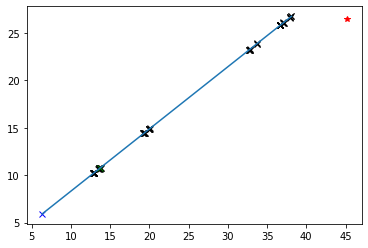

pid -22454.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     236636      1    52  5105  310104  310104  235695  19.603500  17.810680   
      236964      1    52  5105  310104  310104  236027 -26.519842   0.003850   
      261440      1    52  5105  310104  310104  260845 -12.698551  34.331966   
      236529      1    52  5105  310104  310104  235588  25.584461   6.771907   
      236876      1    52  5105  310104  310104  235935 -14.009585  22.504532   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      261525      1    52  5105  310104  310104  260930 -32.618397  15.976479   
      261536      1    52  5105  310104  310104  260941 -36.277542   8.221191   
      261747      1    52  5105  310104  310104  261156   6.683727 -36.679527   
      261811      1    52  5105  310104  310104  261225  29.084452 -21.894079   
      261

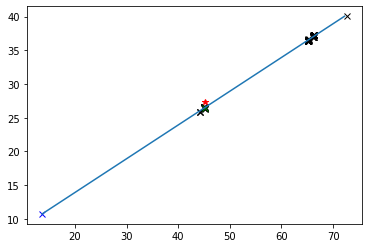

pid -22454.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     236636      1    52  5105  310104  310104  235695  19.603500  17.810680   
      236657      1    52  5105  310104  310104  235716  20.111036  18.392200   
      236562      1    52  5105  310104  310104  235621  25.983168   8.223190   
      236892      1    52  5105  310104  310104  235952 -14.589895  23.024988   
      236672      1    52  5105  310104  310104  235731  14.664460  22.962421   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      236595      1    52  5105  310104  310104  235654  23.048613   8.172941   
      236795      1    52  5105  310104  310104  235854   0.818669  27.016367   
      236987      1    52  5105  310104  310104  236050 -26.475056   5.433562   
      237399      1    52  5105  310104  310104  236476  23.035027 -14.134899   
      236

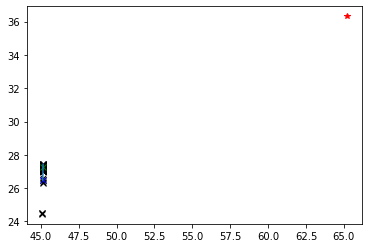

pid -22454.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     261348      1    52  5105  310104  310104  260753  26.527365  24.813501   
      280731      1    52  5105  310104  310104  280413 -29.051603  42.311497   
      262390      1    52  5105  310104  310104  261807   8.379722 -38.819977   
      261525      1    52  5105  310104  310104  260930 -32.618397  15.976479   
      261811      1    52  5105  310104  310104  261225  29.084452 -21.894079   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      261287      1    52  5105  310104  310104  260691  32.977642  15.280388   
      280540      1    52  5105  310104  310104  280222  49.315414  14.308449   
      261414      1    52  5105  310104  310104  260819  -3.046525  36.643486   
      280663      1    52  5105  310104  310104  280345  11.264954  49.971676   
      261

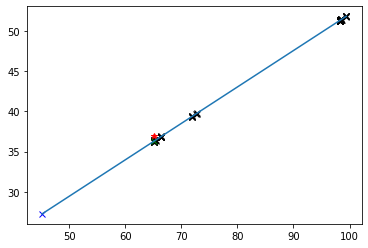

 12%|█████████████▌                                                                                                        | 23/200 [00:25<03:10,  1.08s/it]

pid -22453.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     26889       1    52  5105  310104  310104   23897   3.330801   6.244749   
      223218      1    52  5105  310104  310104  222061  18.183195  17.812824   
      30972       1    52  5105  310104  310104   28044  -4.393752   7.663180   
      27007       1    52  5105  310104  310104   24015  -0.609250   7.142284   
      223388      1    52  5105  310104  310104  222235 -11.965040  22.233158   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      32037       1    52  5105  310104  310104   29119   4.486502   7.754906   
      32210       1    52  5105  310104  310104   29296  -8.690245   2.675525   
      30590       1    52  5105  310104  310104   27660   8.773969   1.508513   
      27776       1    52  5105  310104  310104   24800   5.973771  -3.667862   
      223

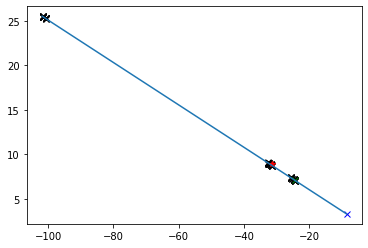

pid -22453.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     30810       1    52  5105  310104  310104   27881   4.193991   7.912697   
      224917      1    52  5105  310104  310104  223770  13.032142 -19.654905   
      30619       1    52  5105  310104  310104   27689   9.047977   0.462836   
      36400       1    52  5105  310104  310104   33547 -11.162784   3.426380   
      224848      1    52  5105  310104  310104  223701  10.961892 -21.168575   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      36393       1    52  5105  310104  310104   33540 -11.335690   3.116457   
      224307      1    52  5105  310104  310104  223156  -4.450730  23.359108   
      224263      1    52  5105  310104  310104  223112   4.928500  23.143509   
      32062       1    52  5105  310104  310104   29144   0.107185   9.251150   
      364

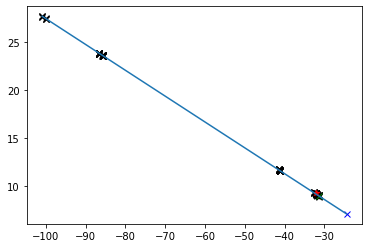

pid -22453.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     32002       1    52  5105  310104  310104   29084   4.347555   8.212049   
      32030       1    52  5105  310104  310104   29112   4.414573   8.341839   
      225174      1    52  5105  310104  310104  224027  19.683764  13.540193   
      225304      1    52  5105  310104  310104  224157   9.917810  21.735453   
      36117       1    52  5105  310104  310104   33257  11.305797   5.447453   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      225955      1    52  5105  310104  310104  224812  21.111362 -12.488029   
      225540      1    52  5105  310104  310104  224395 -24.108480   4.519321   
      225359      1    52  5105  310104  310104  224212   0.309269  24.526989   
      225236      1    52  5105  310104  310104  224089  16.025541  18.570686   
      225

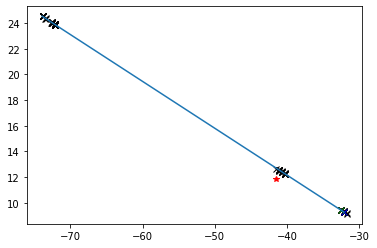

pid -22453.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     36234       1    52  5105  310104  310104   33374   5.503468  10.480701   
      223887      1    52  5105  310104  310104  222734   7.685609 -26.712996   
      36370       1    52  5105  310104  310104   33515  -6.017607  10.196056   
      41633       1    52  5105  310104  310104   38837  -5.365130  13.553025   
      224920      1    52  5105  310104  310104  223773  15.488583 -17.961876   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      36668       1    52  5105  310104  310104   33816  -3.715192 -11.102229   
      41435       1    52  5105  310104  310104   38634  14.654034   2.235863   
      223548      1    52  5105  310104  310104  222395 -27.546547   2.658062   
      41644       1    52  5105  310104  310104   38848  -7.680029  12.367785   
      362

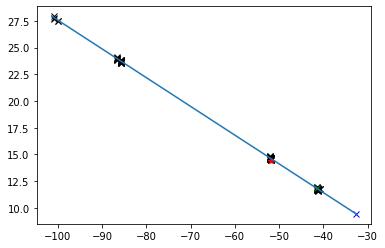

pid -22453.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     41553       1    52  5105  310104  310104   38753   6.658566  12.794065   
      41746       1    52  5105  310104  310104   38952 -14.144437   2.841608   
      225054      1    52  5105  310104  310104  223907  22.944590  -2.386268   
      41640       1    52  5105  310104  310104   38844  -8.172195  12.013762   
      223717      1    52  5105  310104  310104  222564 -21.387123 -16.522943   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      224913      1    52  5105  310104  310104  223766  17.073040 -15.711934   
      223715      1    52  5105  310104  310104  222562 -21.982124 -15.492374   
      224783      1    52  5105  310104  310104  223636  -1.700730 -22.869364   
      41642       1    52  5105  310104  310104   38846  -8.080709  12.238249   
      223

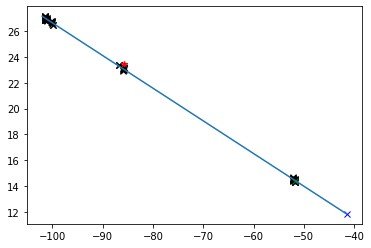

pid -22453.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     224262      1    52  5105  310104  310104  223111  10.565410  20.941774   
      136506      1    52  5105  310104  310104  134524  23.319614  26.546833   
      223681      1    52  5105  310104  310104  222528 -23.198324 -14.716531   
      136947      1    52  5105  310104  310104  134967  -6.897177 -34.653301   
      137019      1    52  5105  310104  310104  135039  11.224178 -33.512802   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      137017      1    52  5105  310104  310104  135037  13.058079 -32.753178   
      136668      1    52  5105  310104  310104  134686 -28.254408  21.094259   
      136572      1    52  5105  310104  310104  134590   5.013432  34.901302   
      224306      1    52  5105  310104  310104  223155   4.509271  23.359108   
      224

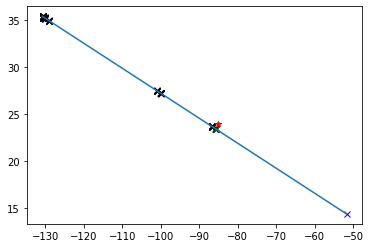

 12%|██████████████▏                                                                                                       | 24/200 [00:27<03:39,  1.25s/it]

pid -22451.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     16501       1    52  5105  310104  310104   13321  10.791190   0.266354   
      228159      1    52  5105  310104  310104  227059 -22.075329 -13.745548   
      18394       1    52  5105  310104  310104   15244  -9.771611   4.390908   
      20266       1    52  5105  310104  310104   17146   5.330168  -9.293035   
      18881       1    52  5105  310104  310104   15737 -10.447618  -2.435586   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      28648       1    52  5105  310104  310104   25689  12.991590   4.635717   
      17923       1    52  5105  310104  310104   14764  -3.527202  10.211691   
      19604       1    52  5105  310104  310104   16476  -5.821475  -8.481538   
      19365       1    52  5105  310104  310104   16236  -6.827984  -8.304101   
      198

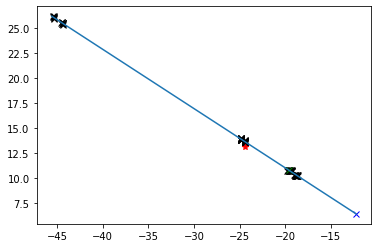

pid -22451.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     28645       1    52  5105  310104  310104   25686  12.585443   3.791632   
      28831       1    52  5105  310104  310104   25873 -10.749091   7.900081   
      227422      1    52  5105  310104  310104  226306 -13.317158 -23.903170   
      228288      1    52  5105  310104  310104  227188   1.403669 -23.411926   
      227456      1    52  5105  310104  310104  226340   1.243670 -26.588074   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      227153      1    52  5105  310104  310104  226026 -21.637781  15.698410   
      28653       1    52  5105  310104  310104   25694  10.864345   7.544689   
      28720       1    52  5105  310104  310104   25761   3.519433  12.988720   
      227850      1    52  5105  310104  310104  226738   9.811646  21.208105   
      290

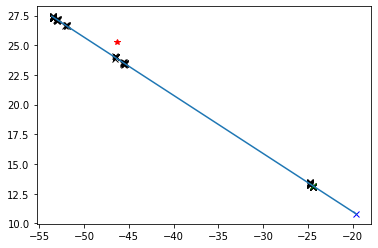

pid -22451.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     227741      1    52  5105  310104  310104  226626  23.984787   7.850513   
      253423      1    52  5105  310104  310104  252693  -5.454569  38.974331   
      228174      1    52  5105  310104  310104  227074 -19.858295 -15.571690   
      141008      1    52  5105  310104  310104  139058  63.679222  32.607479   
      228270      1    52  5105  310104  310104  227170  -5.212444 -24.689854   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      141502      1    52  5105  310104  310104  139560  35.351028 -62.122391   
      141246      1    52  5105  310104  310104  139302 -63.325958  33.360077   
      1536        1    52  5105  310104  310104  139273 -47.555111  53.492710   
      141215      1    52  5105  310104  310104  139270 -53.489506  47.558315   
      254

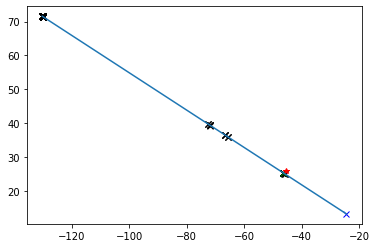

 13%|███████████████▎                                                                                                      | 26/200 [00:28<02:35,  1.12it/s]

pid -22450.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     48029       1    52  5105  310104  310104   45281  4.284852 -0.474895   
      51487       1    52  5105  310104  310104   48775  0.754731  5.284571   
      53982       1    52  5105  310104  310104   51287  5.151576 -1.263486   
      46955       1    52  5105  310104  310104   44200  0.248396  4.285079   
      52601       1    52  5105  310104  310104   49896  5.027144 -1.802485   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      48059       1    52  5105  310104  310104   45311  4.128533 -1.077865   
      51470       1    52  5105  310104  310104   48758  1.106687  5.269372   
      52579       1    52  5105  310104  310104   49874  4.817333 -2.192210   
      53994       1    52  5105  310104  310104   51299  5.185221 -0.868673   
      47175       1    52  5105  

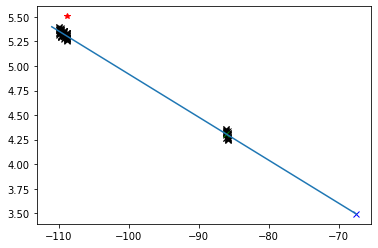

pid -22450.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     52634       1    52  5105  310104  310104   49929  5.561891  -0.603755   
      58640       1    52  5105  310104  310104   55966  6.983030  -3.393758   
      1843        1    52  5105  310104  310104   49815  3.676320  -4.211953   
      53445       1    52  5105  310104  310104   50743 -4.732227  -2.879516   
      61791       1    52  5105  310104  310104   59130  9.248456  -4.623941   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      62589       1    52  5105  310104  310104   59931 -0.488635 -10.421227   
      61036       1    52  5105  310104  310104   58373 -4.367236   9.311836   
      62141       1    52  5105  310104  310104   59481 -1.979783  10.303593   
      52786       1    52  5105  310104  310104   50081  4.978186   2.281057   
      53791       1  

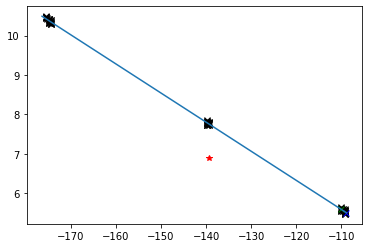

pid -22450.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     57340       1    52  5105  310104  310104   54660   6.939377 -0.738399   
      61416       1    52  5105  310104  310104   58753  -7.031435 -6.451602   
      66969       1    52  5105  310104  310104   64330 -11.390030 -2.212595   
      61072       1    52  5105  310104  310104   58409  -5.755967  7.609970   
      61721       1    52  5105  310104  310104   59059   5.969741 -7.520072   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      61828       1    52  5105  310104  310104   59167   9.303136 -2.622240   
      56444       1    52  5105  310104  310104   53760  -5.053716  4.901687   
      67292       1    52  5105  310104  310104   64656   7.512386 -8.682631   
      66783       1    52  5105  310104  310104   64144  -9.709404  6.467017   
      67034       1  

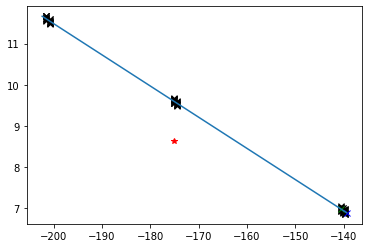

 14%|███████████████▉                                                                                                      | 27/200 [00:28<02:34,  1.12it/s]

pid -22448.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     43198       1    52  5105  310104  310104   40416 -1.124528 -3.735962   
      43109       1    52  5105  310104  310104   40325 -1.135964 -3.771214   
      48892       1    52  5105  310104  310104   46151 -5.262722 -1.897394   
      47598       1    52  5105  310104  310104   44846 -2.019390 -5.298656   
      43354       1    52  5105  310104  310104   40573  2.043717 -3.319927   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      47482       1    52  5105  310104  310104   44729 -4.973237 -2.613956   
      47593       1    52  5105  310104  310104   44841 -1.972972 -5.367251   
      48220       1    52  5105  310104  310104   45474  4.244534  3.664514   
      42983       1    52  5105  310104  310104   40197 -3.381539 -1.918140   
      48580       1    52  5105  

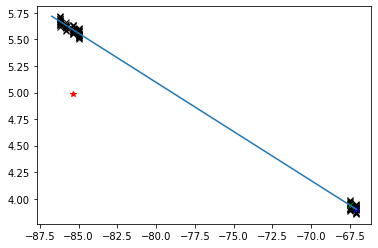

pid -22448.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     47665       1    52  5105  310104  310104   44914 -1.443151 -4.820765   
      49026       1    52  5105  310104  310104   46289 -1.429155 -4.775884   
      52795       1    52  5105  310104  310104   50091  7.177481  3.029966   
      817         1    52  5105  310104  310104   45763 -2.740692  4.164909   
      49292       1    52  5105  310104  310104   46559  4.106620 -2.743553   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      48210       1    52  5105  310104  310104   45464  4.017682  2.962496   
      49211       1    52  5105  310104  310104   46478  2.549104 -4.292187   
      46836       1    52  5105  310104  310104   44080  1.584580  4.767378   
      53821       1    52  5105  310104  310104   51125  4.965278 -5.870903   
      48807       1    52  5105  

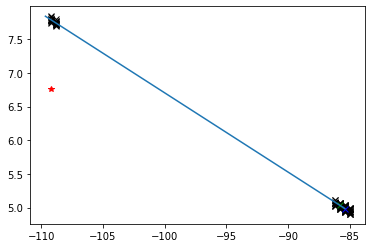

pid -22448.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     53629       1    52  5105  310104  310104   50928  -1.922533 -6.488458   
      52890       1    52  5105  310104  310104   50187   3.121836  5.970477   
      59321       1    52  5105  310104  310104   56650  -9.051250 -0.781864   
      58448       1    52  5105  310104  310104   55771   1.983739 -8.771534   
      51569       1    52  5105  310104  310104   48858  -0.984672  6.756942   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      51577       1    52  5105  310104  310104   48866  -0.835418  6.832784   
      61915       1    52  5105  310104  310104   59254  11.657777  0.512222   
      58865       1    52  5105  310104  310104   56192   7.043332  5.828372   
      53749       1    52  5105  310104  310104   51048   2.091356 -6.343088   
      59338       1  

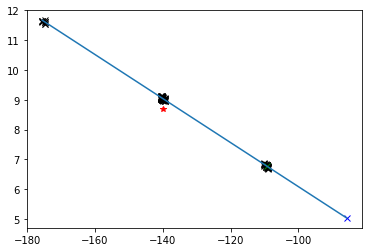

pid -22448.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     59512       1    52  5105  310104  310104   56843  -2.454303 -8.366566   
      59471       1    52  5105  310104  310104   56802  -2.463009 -8.402493   
      67526       1    52  5105  310104  310104   64893  10.835009  9.289974   
      59539       1    52  5105  310104  310104   56870  -0.494260 -8.705394   
      67511       1    52  5105  310104  310104   64878  11.414473  8.691371   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      66863       1    52  5105  310104  310104   64224 -14.222096  1.716987   
      67985       1    52  5105  310104  310104   65356 -10.790941 -9.364171   
      61937       1    52  5105  310104  310104   59277  11.040247  4.514670   
      59274       1    52  5105  310104  310104   56603  -8.776292  0.223700   
      61970       1  

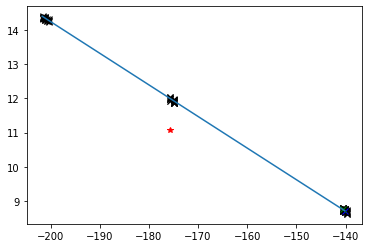

 14%|█████████████████                                                                                                     | 29/200 [00:30<02:13,  1.29it/s]

pid -22447.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     15574       1    52  5105  310104  310104   12351   3.233264  -4.955816   
      227144      1    52  5105  310104  310104  226017 -20.425081  15.766133   
      227309      1    52  5105  310104  310104  226193 -23.350378 -12.045280   
      13888       1    52  5105  310104  310104   10630  -6.007719  -2.220089   
      227556      1    52  5105  310104  310104  226440  15.100639 -20.876400   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      227593      1    52  5105  310104  310104  226477  23.721684 -11.148069   
      16258       1    52  5105  310104  310104   13075   6.436343  -0.143424   
      16038       1    52  5105  310104  310104   12846   5.295156  -2.633804   
      227364      1    52  5105  310104  310104  226248 -16.199350 -20.120317   
      227

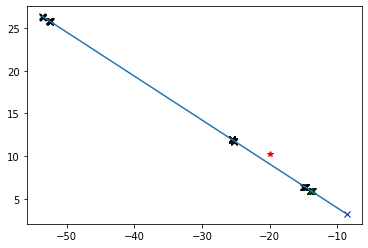

pid -22447.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     20476       1    52  5105  310104  310104   17367   7.698703  -6.726275   
      28845       1    52  5105  310104  310104   25887 -11.462242   6.920243   
      228775      1    52  5105  310104  310104  227675 -11.485328  20.463734   
      19126       1    52  5105  310104  310104   15988  -8.784469  -5.226939   
      19612       1    52  5105  310104  310104   16484  -4.621461  -9.092976   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      28976       1    52  5105  310104  310104   26021  -9.892293  -9.677508   
      28632       1    52  5105  310104  310104   25673  13.490965   0.664295   
      228082      1    52  5105  310104  310104  226976 -27.291040   4.409702   
      28834       1    52  5105  310104  310104   25876 -10.331236   9.214083   
      228

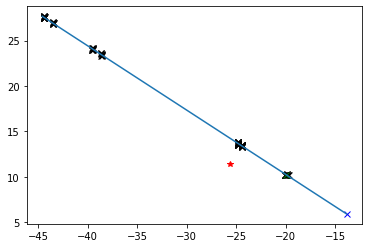

pid -22447.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     28500       1    52  5105  310104  310104   25541   7.361437  -8.718919   
      224178      1    52  5105  310104  310104  223027  19.801264  13.336678   
      224637      1    52  5105  310104  310104  223490 -22.407715  -9.035053   
      225080      1    52  5105  310104  310104  223933  23.742168  -2.506594   
      223451      1    52  5105  310104  310104  222298 -17.979971  20.376450   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      33167       1    52  5105  310104  310104   30271  -1.255983 -12.497112   
      32973       1    52  5105  310104  310104   30066 -11.086397   5.903123   
      33199       1    52  5105  310104  310104   30303  -0.013818 -12.763016   
      224456      1    52  5105  310104  310104  223307 -19.040331  14.452110   
      224

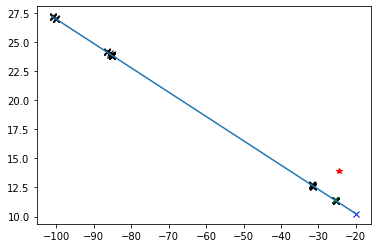

 15%|█████████████████▋                                                                                                    | 30/200 [00:30<02:11,  1.29it/s]

pid -22445.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     16739       1    52  5105  310104  310104   13563   9.448174   3.924345   
      228656      1    52  5105  310104  310104  227556  14.459225  23.122320   
      229752      1    52  5105  310104  310104  228664 -23.143991  -2.104553   
      229076      1    52  5105  310104  310104  227980  -5.674230 -26.674931   
      229751      1    52  5105  310104  310104  228663 -23.136177  -2.148869   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      17256       1    52  5105  310104  310104   14085   4.123065   9.346921   
      228899      1    52  5105  310104  310104  227803 -20.099464  16.819441   
      19131       1    52  5105  310104  310104   15993  -8.410182  -5.961518   
      228832      1    52  5105  310104  310104  227732 -15.820993  21.979660   
      206

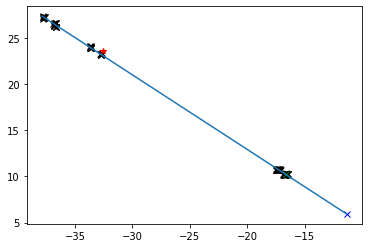

pid -22445.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     229393      1    52  5105  310104  310104  228299  19.968513  12.491464   
      254982      1    52  5105  310104  310104  254279  36.493702   9.736961   
      255036      1    52  5105  310104  310104  254333  25.154919  28.074896   
      229394      1    52  5105  310104  310104  228300  20.943514  10.802713   
      229868      1    52  5105  310104  310104  228782 -11.901064 -21.298962   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      255468      1    52  5105  310104  310104  254771  14.349854 -34.768639   
      229524      1    52  5105  310104  310104  228430   2.748668  24.338972   
      229912      1    52  5105  310104  310104  228826   3.433668 -23.538973   
      229439      1    52  5105  310104  310104  228345  13.498844  20.445396   
      228

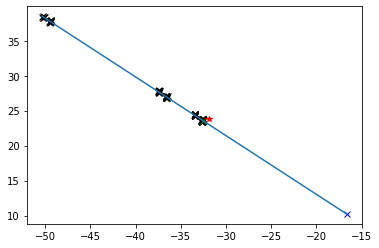

 16%|██████████████████▎                                                                                                   | 31/200 [00:31<01:57,  1.43it/s]

pid -22444.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     16421       1    52  5105  310104  310104   13240   6.342483  -0.856369   
      13800       1    52  5105  310104  310104   10542  -5.769479  -1.378107   
      13805       1    52  5105  310104  310104   10547  -5.758191  -1.463853   
      234456      1    52  5105  310104  310104  233449 -26.291735  -0.445461   
      234249      1    52  5105  310104  310104  233240   3.503182  27.446976   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      234605      1    52  5105  310104  310104  233621 -12.124914 -24.795353   
      234612      1    52  5105  310104  310104  233628  -6.660601 -26.784201   
      234691      1    52  5105  310104  310104  233707  13.529354 -24.038391   
      13112       1    52  5105  310104  310104    9843  -5.211654   3.721190   
      234

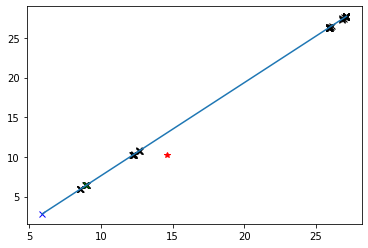

pid -22444.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     21117       1    52  5105  310104  310104   18034  10.022890  -1.920986   
      18596       1    52  5105  310104  310104   15448  -9.626112   4.676467   
      17209       1    52  5105  310104  310104   14038   8.655949   6.476136   
      236133      1    52  5105  310104  310104  235177 -21.965353 -14.190124   
      236025      1    52  5105  310104  310104  235065 -25.970245   3.120765   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      236027      1    52  5105  310104  310104  235067 -25.975277   1.628975   
      21123       1    52  5105  310104  310104   18040  10.130304  -1.242795   
      17662       1    52  5105  310104  310104   14501   2.221754  10.481485   
      236486      1    52  5105  310104  310104  235542  24.710661  -7.120469   
      235

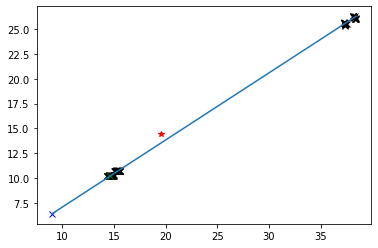

pid -22444.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     25244       1    52  5105  310104  310104   22237  14.328512  -1.443158   
      22646       1    52  5105  310104  310104   19582  -8.842218  11.450785   
      22644       1    52  5105  310104  310104   19580  -8.835011  11.455313   
      22643       1    52  5105  310104  310104   19579  -8.828585  11.459351   
      235492      1    52  5105  310104  310104  234520  11.117656 -23.071293   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      235064      1    52  5105  310104  310104  234086 -10.295348  22.384047   
      23526       1    52  5105  310104  310104   20484 -13.797704  -4.167923   
      24946       1    52  5105  310104  310104   21928  12.391396  -7.345244   
      234989      1    52  5105  310104  310104  234011   8.211700  23.683229   
      252

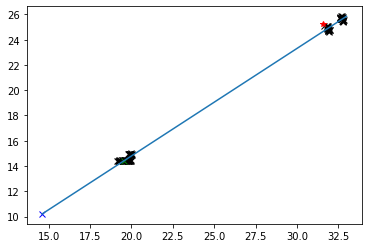

pid -22444.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     235650      1    52  5105  310104  310104  234684  25.081131  -2.824537   
      259552      1    52  5105  310104  310104  258912  20.375757  30.961149   
      235182      1    52  5105  310104  310104  234208 -25.452684   5.324369   
      235186      1    52  5105  310104  310104  234212 -26.126261   0.041069   
      259971      1    52  5105  310104  310104  259353  33.212708 -16.439140   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      259649      1    52  5105  310104  310104  259009 -16.175091  33.537827   
      235336      1    52  5105  310104  310104  234363 -12.966930 -21.837561   
      259894      1    52  5105  310104  310104  259276  10.208249 -35.810810   
      259939      1    52  5105  310104  310104  259321  23.663834 -28.752005   
      259

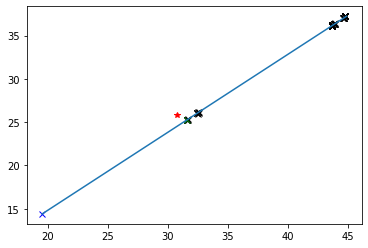

 16%|██████████████████▉                                                                                                   | 32/200 [00:32<02:03,  1.36it/s]

pid -22443.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     11623       1    52  5105  310104  310104    8329   3.805691   5.146814   
      232651      1    52  5105  310104  310104  231593  -3.481819  25.606668   
      19981       1    52  5105  310104  310104   16858  -2.377315 -10.456847   
      11151       1    52  5105  310104  310104    7851   6.171604   1.824435   
      10889       1    52  5105  310104  310104    7586   5.829928   0.918950   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      232901      1    52  5105  310104  310104  231846 -24.339840  -1.629506   
      232604      1    52  5105  310104  310104  231546  10.602798  22.196213   
      11620       1    52  5105  310104  310104    8326   3.703092   5.225541   
      12119       1    52  5105  310104  310104    8832   0.672028   6.366751   
      125

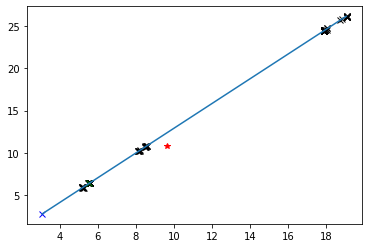

pid -22443.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     21897       1    52  5105  310104  310104   18822   6.653222  13.416733   
      21899       1    52  5105  310104  310104   18824   6.835682  13.302086   
      233945      1    52  5105  310104  310104  232930  14.404611 -19.573170   
      233699      1    52  5105  310104  310104  232675 -14.430379 -19.551548   
      233919      1    52  5105  310104  310104  232903  13.358023 -20.612808   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      3434        1    52  5105  310104  310104  232605 -23.651371  -9.604225   
      23257       1    52  5105  310104  310104   20201 -14.481207   0.087957   
      234046      1    52  5105  310104  310104  233035  28.025185   2.734890   
      22773       1    52  5105  310104  310104   19712 -11.594971   9.476810   
      250

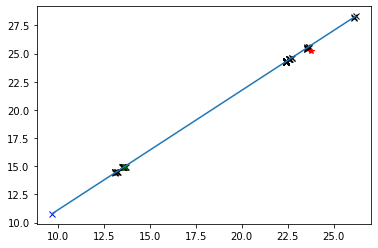

pid -22443.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     233308      1    52  5105  310104  310104  232263  15.236334  20.082104   
      233581      1    52  5105  310104  310104  232536 -25.407963  -0.339937   
      3360        1    52  5105  310104  310104  233459 -25.580927 -11.197456   
      234231      1    52  5105  310104  310104  233222  -4.601819  27.645170   
      233579      1    52  5105  310104  310104  232534 -24.550478   5.758817   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      258914      1    52  5105  310104  310104  258260  32.903313  21.960640   
      234399      1    52  5105  310104  310104  233392 -27.423187   4.295425   
      259286      1    52  5105  310104  310104  258640  -8.779387 -38.573803   
      258947      1    52  5105  310104  310104  258293  28.451445  25.634876   
      234

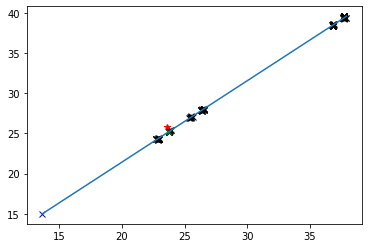

 16%|███████████████████▍                                                                                                  | 33/200 [00:32<02:00,  1.38it/s]

pid -22442.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     125091      1    52  5105  310104  310104  123025  -0.002670  -9.469695   
      131015      1    52  5105  310104  310104  128988  -8.665476  -7.423183   
      125177      1    52  5105  310104  310104  123111   2.237399  -9.156248   
      131154      1    52  5105  310104  310104  129127  -1.157145 -11.353390   
      124949      1    52  5105  310104  310104  122883  -8.903481  -3.095764   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      125059      1    52  5105  310104  310104  122993  -4.133321  -8.359385   
      131294      1    52  5105  310104  310104  129267   6.576318  -9.392426   
      130869      1    52  5105  310104  310104  128842 -11.259574   0.343200   
      131484      1    52  5105  310104  310104  129459  11.459365  -0.484835   
      130

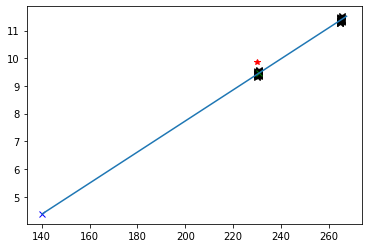

 17%|████████████████████                                                                                                  | 34/200 [00:33<01:38,  1.69it/s]

pid -22441.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     195346      1    52  5105  310104  310104  193886  32.643585 -57.887264   
      195337      1    52  5105  310104  310104  193876  32.635883 -57.891922   
      195414      1    52  5105  310104  310104  193961  61.433189 -25.354189   
      195412      1    52  5105  310104  310104  193959  59.710072 -29.182800   
      195408      1    52  5105  310104  310104  193955  61.416569 -25.391121   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      195421      1    52  5105  310104  310104  193968  64.766991 -15.435802   
      195341      1    52  5105  310104  310104  193881  38.246815 -54.500000   
      194749      1    52  5105  310104  310104  193284  64.979607  -0.501888   
      194750      1    52  5105  310104  310104  193285  64.756950  -1.558696   
      194

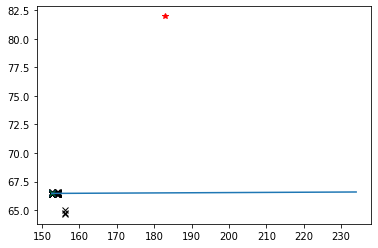

pid -22441.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     212253      1    52  5105  310104  310104  210981  39.757599 -71.705910   
      221140      1    52  5105  310104  310104  219947  58.791229 -57.153984   
      221110      1    52  5105  310104  310104  219914  39.695847 -71.742920   
      221123      1    52  5105  310104  310104  219929  57.170658 -58.776119   
      212269      1    52  5105  310104  310104  210997  51.069191 -64.145088   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      220876      1    52  5105  310104  310104  219678 -79.069183  21.582512   
      221082      1    52  5105  310104  310104  219884   8.413672 -81.592270   
      221038      1    52  5105  310104  310104  219840 -21.560686 -79.074654   
      212288      1    52  5105  310104  310104  211018  53.889721 -61.749786   
      220

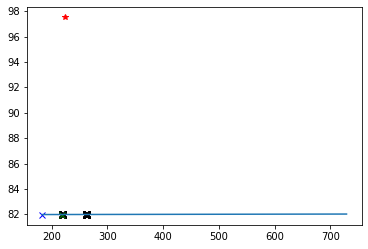

 18%|████████████████████▋                                                                                                 | 35/200 [00:33<01:42,  1.61it/s]

pid -22440.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     14536       1    52  5105  310104  310104   11294  -3.925478  -5.054898   
      12144       1    52  5105  310104  310104    8857   0.342368   6.410152   
      15261       1    52  5105  310104  310104   12025   1.293221  -5.780655   
      248986      1    52  5105  310104  310104  248211  -2.432668 -21.885250   
      17180       1    52  5105  310104  310104   14009   8.412616   6.719470   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      14753       1    52  5105  310104  310104   11513  -2.209790  -5.470789   
      244429      1    52  5105  310104  310104  243606  19.644516   9.745199   
      20848       1    52  5105  310104  310104   17758   8.817719  -6.263025   
      12158       1    52  5105  310104  310104    8872   1.504330   6.257177   
      195

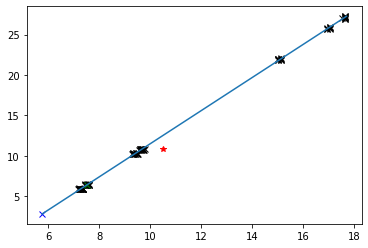

pid -22440.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     233687      1    52  5105  310104  310104  232663 -15.181429 -21.162249   
      233369      1    52  5105  310104  310104  232324   7.027962  25.078363   
      233690      1    52  5105  310104  310104  232666 -18.207304 -18.623236   
      233617      1    52  5105  310104  310104  232572 -25.227272  -6.482332   
      234000      1    52  5105  310104  310104  232987  25.532236  -6.082858   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      233494      1    52  5105  310104  310104  232449 -21.282681  17.971193   
      233461      1    52  5105  310104  310104  232416 -17.878551  20.666151   
      233292      1    52  5105  310104  310104  232247  17.366346  21.095943   
      233272      1    52  5105  310104  310104  232227  23.956293  10.445799   
      233

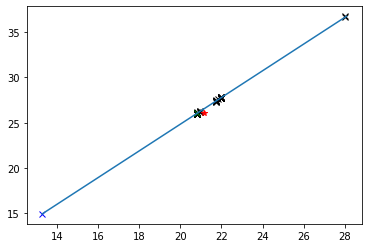

pid -22440.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     233687      1    52  5105  310104  310104  232663 -15.181429 -21.162249   
      233665      1    52  5105  310104  310104  232640 -15.172811 -21.190870   
      233369      1    52  5105  310104  310104  232324   7.027962  25.078363   
      233690      1    52  5105  310104  310104  232666 -18.207304 -18.623236   
      234791      1    52  5105  310104  310104  233809  23.692345 -11.679049   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      179942      1    52  5105  310104  310104  178279 -15.058640 -28.319393   
      238179      1    52  5105  310104  310104  237286  23.962009 -14.035007   
      179818      1    52  5105  310104  310104  178155 -30.160101 -10.614779   
      233200      1    52  5105  310104  310104  232155  26.172464   0.885066   
      236

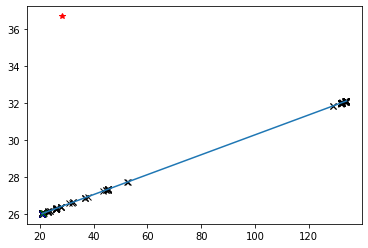

pid -22440.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     258140      1    52  5105  310104  310104  257471 -20.816442 -30.200567   
      258118      1    52  5105  310104  310104  257449 -21.344303 -31.085474   
      258258      1    52  5105  310104  310104  257591  29.531385 -21.486301   
      257931      1    52  5105  310104  310104  257259 -13.253035  35.306904   
      277724      1    52  5105  310104  310104  277315 -29.376488 -45.417736   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      258267      1    52  5105  310104  310104  257600  31.086742 -19.297369   
      258027      1    52  5105  310104  310104  257356 -34.817539  11.255003   
      257836      1    52  5105  310104  310104  257163  22.828913  28.600357   
      257879      1    52  5105  310104  310104  257206   6.883911  35.943054   
      258

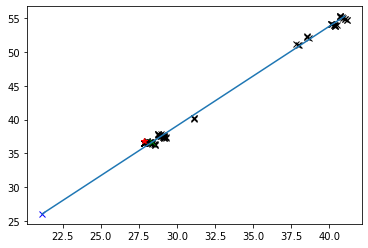

 18%|█████████████████████▏                                                                                                | 36/200 [00:34<02:04,  1.32it/s]

pid -22438.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     94380       1    52  5105  310104  310104   92008 -4.565282 -2.088930   
      93076       1    52  5105  310104  310104   90687 -4.638767 -2.123672   
      92855       1    52  5105  310104  310104   90462 -4.785197  1.990652   
      93107       1    52  5105  310104  310104   90718 -4.193901 -3.043085   
      98341       1    52  5105  310104  310104   96009  4.940211  6.169409   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      94356       1    52  5105  310104  310104   91984 -4.961677 -1.161565   
      98439       1    52  5105  310104  310104   96107  1.618182  7.898010   
      93068       1    52  5105  310104  310104   90679 -4.632383 -2.312619   
      98780       1    52  5105  310104  310104   96451 -7.822558  1.158574   
      94102       1    52  5105  

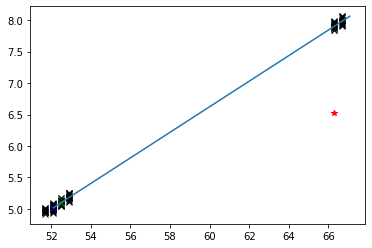

pid -22438.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     97551       1    52  5105  310104  310104   95214 -6.044689 -2.782497   
      98936       1    52  5105  310104  310104   96608 -5.921784 -2.724461   
      99124       1    52  5105  310104  310104   96806 -1.263436 -6.464195   
      98551       1    52  5105  310104  310104   96219 -2.146444  6.227572   
      98314       1    52  5105  310104  310104   95982  4.547944  4.762465   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      97531       1    52  5105  310104  310104   95193 -5.819374 -3.070337   
      97387       1    52  5105  310104  310104   95049 -6.638311  1.103294   
      97208       1    52  5105  310104  310104   94869 -5.151411  4.081912   
      105005      1    52  5105  310104  310104  102751  7.587666 -6.220845   
      98771       1    52  5105  

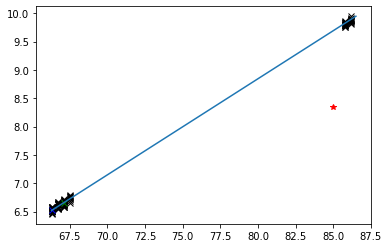

pid -22438.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     104664      1    52  5105  310104  310104  102397 -7.740917  -3.589289   
      108914      1    52  5105  310104  310104  106702  5.883856  10.745759   
      109821      1    52  5105  310104  310104  107622  7.892434   9.201207   
      104576      1    52  5105  310104  310104  102309 -8.489922   0.867847   
      109438      1    52  5105  310104  310104  107236 -2.662360 -12.024912   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      104813      1    52  5105  310104  310104  102555 -4.099397  -7.486278   
      110351      1    52  5105  310104  310104  108158 -1.507942 -12.160438   
      103525      1    52  5105  310104  310104  101242 -7.954122  -2.505600   
      105091      1    52  5105  310104  310104  102837  8.152953  -2.733812   
      109419      1  

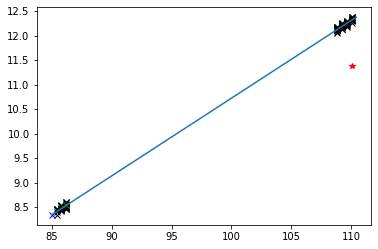

pid -22438.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     109305      1    52  5105  310104  310104  107097 -10.304128  -4.830977   
      114776      1    52  5105  310104  310104  112615 -14.928089  -0.088090   
      109149      1    52  5105  310104  310104  106938  -9.913074   5.591389   
      109427      1    52  5105  310104  310104  107225  -5.523314  -9.898152   
      109341      1    52  5105  310104  310104  107136  -9.362289  -6.391415   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      114937      1    52  5105  310104  310104  112784  -6.015714 -13.534995   
      114558      1    52  5105  310104  310104  112392   0.512409  15.035039   
      114978      1    52  5105  310104  310104  112825  -3.022676 -14.496060   
      109625      1    52  5105  310104  310104  107426   9.649631  -5.803150   
      114

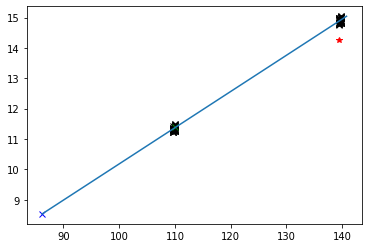

pid -22438.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     114857      1    52  5105  310104  310104  112698 -12.882621  -6.110608   
      117786      1    52  5105  310104  310104  115656 -17.677595   0.736033   
      118353      1    52  5105  310104  310104  116232   5.310542  16.996149   
      118591      1    52  5105  310104  310104  116470 -17.711996   0.749221   
      118360      1    52  5105  310104  310104  116239   5.262429  16.928507   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      118502      1    52  5105  310104  310104  116381 -11.861808  13.184353   
      117899      1    52  5105  310104  310104  115772 -12.373130 -12.650669   
      117639      1    52  5105  310104  310104  115505  -7.662817  15.862117   
      118458      1    52  5105  310104  310104  116337  -7.667347  15.903406   
      118

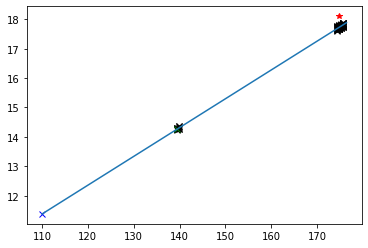

 18%|█████████████████████▊                                                                                                | 37/200 [00:36<02:37,  1.04it/s]

pid -22435.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     22253       1    52  5105  310104  310104   19188  -0.194876  14.469160   
      23610       1    52  5105  310104  310104   20568 -12.764194  -7.691732   
      21834       1    52  5105  310104  310104   18758   8.178954  12.458053   
      22263       1    52  5105  310104  310104   19198  -2.472828  14.212497   
      22271       1    52  5105  310104  310104   19206  -3.086445  14.143358   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      245705      1    52  5105  310104  310104  244907 -10.005764  19.647997   
      247236      1    52  5105  310104  310104  246452 -22.016867  -1.168269   
      248040      1    52  5105  310104  310104  247260 -15.977062 -15.162817   
      22699       1    52  5105  310104  310104   19637 -11.635221   9.436560   
      248

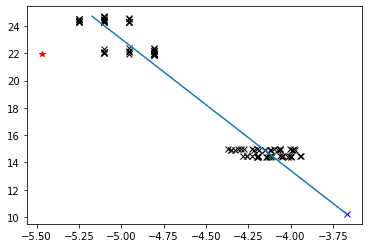

pid -22435.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     245740      1    52  5105  310104  310104  244942  -4.057856  21.536173   
      248078      1    52  5105  310104  310104  247298 -16.587473 -14.311217   
      249460      1    52  5105  310104  310104  248688  10.675777 -19.611124   
      244162      1    52  5105  310104  310104  243337  20.546850   7.662313   
      250105      1    52  5105  310104  310104  249347  20.665041  -7.337588   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      245739      1    52  5105  310104  310104  244941  -6.181561  20.763206   
      249480      1    52  5105  310104  310104  248708  12.937014 -17.374315   
      583         1    52  5105  310104  310104  244219   8.573394  19.892651   
      248745      1    52  5105  310104  310104  247968   1.232332 -21.625250   
      245

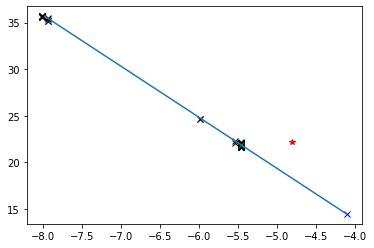

 20%|███████████████████████                                                                                               | 39/200 [00:37<01:48,  1.48it/s]

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     79804       1    52  5105  310104  310104   77223  5.547755   3.581366   
      81243       1    52  5105  310104  310104   78686  5.402480   3.484490   
      81818       1    52  5105  310104  310104   79266 -5.397722  -3.490288   
      81935       1    52  5105  310104  310104   79387 -1.548923  -6.057766   
      81289       1    52  5105  310104  310104   78732  3.519049   5.166896   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      79837       1    52  5105  310104  310104   77256  5.955233   2.693436   
      86674       1    52  5105  310104  310104   84198 -0.356657   9.884179   
      239376      1    52  5105  310104  310104  238500  8.280221  25.525196   
      81830       1    52  5105  310104  310104   79280 -5.133698  -3.985597   
      85790       1  

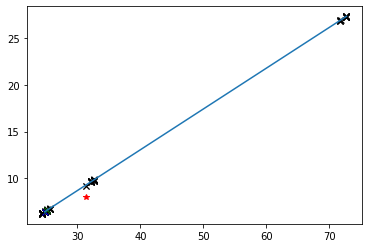

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     85225       1    52  5105  310104  310104   82733   6.734145   4.369102   
      241940      1    52  5105  310104  310104  241097 -22.974028  -6.862933   
      90770       1    52  5105  310104  310104   88362   8.981215   4.980337   
      242481      1    52  5105  310104  310104  241640  23.934917  -1.413456   
      242480      1    52  5105  310104  310104  241639  23.938391  -1.393761   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      86299       1    52  5105  310104  310104   83819   6.722341  -4.433661   
      242482      1    52  5105  310104  310104  241641  23.820311  -2.063430   
      242334      1    52  5105  310104  310104  241493  12.776768 -20.369558   
      241718      1    52  5105  310104  310104  240870 -18.300539  15.873514   
      912

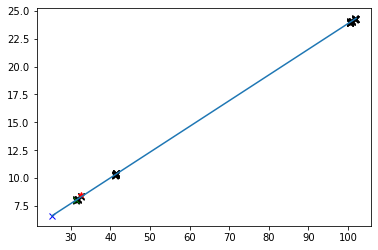

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     86491       1    52  5105  310104  310104   84014   7.107871   4.620532   
      91172       1    52  5105  310104  310104   88766 -10.862188  -4.676507   
      91292       1    52  5105  310104  310104   88886  -4.533775 -10.759315   
      87216       1    52  5105  310104  310104   84745   7.481859  -3.990551   
      239885      1    52  5105  310104  310104  239011 -16.664312 -16.607153   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      91396       1    52  5105  310104  310104   88990   4.229891 -10.904425   
      86512       1    52  5105  310104  310104   84035   6.865443   4.941893   
      86845       1    52  5105  310104  310104   84373  -8.330631   0.502918   
      87211       1    52  5105  310104  310104   84740   6.952426  -4.614739   
      860

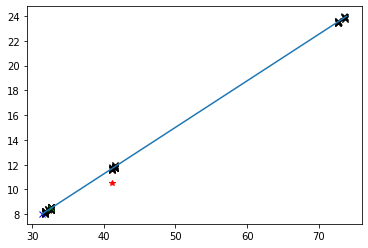

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     96945       1    52  5105  310104  310104   94602  1.395254  2.785148   
      92574       1    52  5105  310104  310104   90179  0.593464  3.059851   
      97247       1    52  5105  310104  310104   94909 -2.115145  2.290154   
      97527       1    52  5105  310104  310104   95189 -2.689810 -1.582366   
      92592       1    52  5105  310104  310104   90197  0.433788  3.090453   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      93656       1    52  5105  310104  310104   91280  3.115517 -0.881983   
      97133       1    52  5105  310104  310104   94794 -0.162537  3.239603   
      96946       1    52  5105  310104  310104   94603  1.483299  2.886358   
      93154       1    52  5105  310104  310104   90768 -2.097566 -2.477635   
      98083       1    52  5105  

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


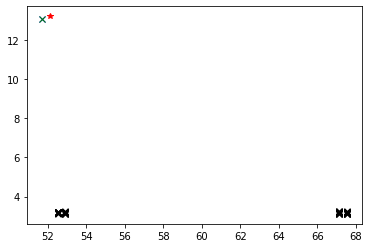

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


pid -22434.0
final 

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


                run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     96945       1    52  5105  310104  310104   94602  1.395254  2.785148   
      92574       1    52  5105  310104  310104   90179  0.593464  3.059851   
      97247       1    52  5105  310104  310104   94909 -2.115145  2.290154   
      97527       1    52  5105  310104  310104   95189 -2.689810 -1.582366   
      92592       1    52  5105  310104  310104   90197  0.433788  3.090453   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      97470       1    52  5105  310104  310104   95132 -3.101718 -0.905109   
      97055       1    52  5105  310104  310104   94714  0.173317  3.227759   
      92621       1    52  5105  310104  310104   90226 -0.253777  3.224450   
      96970       1    52  5105  310104  310104   94628  1.843796  2.657731   
      92982       1    52  5105  310104  310104   90

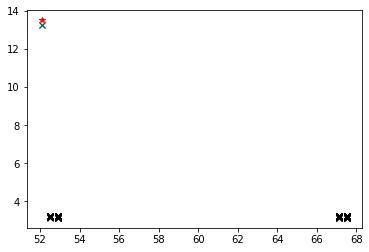

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     96945       1    52  5105  310104  310104   94602  1.395254  2.785148   
      92574       1    52  5105  310104  310104   90179  0.593464  3.059851   
      97247       1    52  5105  310104  310104   94909 -2.115145  2.290154   
      97527       1    52  5105  310104  310104   95189 -2.689810 -1.582366   
      92592       1    52  5105  310104  310104   90197  0.433788  3.090453   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      97470       1    52  5105  310104  310104   95132 -3.101718 -0.905109   
      97055       1    52  5105  310104  310104   94714  0.173317  3.227759   
      92621       1    52  5105  310104  310104   90226 -0.253777  3.224450   
      96970       1    52  5105  310104  310104   94628  1.843796  2.657731   
      92982       1    52  5105  

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:147: RuntimeWarning: invalid value encountered in true_divide
/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


particle id is -22434
is in mapping True
hit 2 z 52.111000061035156 hit3 z 100.59294128417969
hit 1 layer 20.0 hit 2 lauer 20.0
dm is  inf db is -inf
distance line and correct hit nan
m inf  b  -inf
hit3  100.59294128417969 25.209474563598633


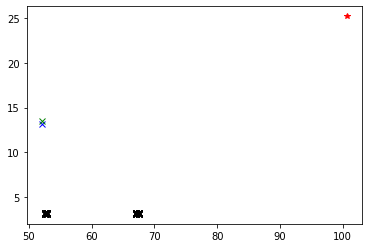

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     241377      1    52  5105  310104  310104  240524  20.732304  14.341869   
      181094      1    52  5105  310104  310104  179433  28.801819 -14.738918   
      179504      1    52  5105  310104  310104  177837  -9.902659  31.328398   
      180269      1    52  5105  310104  310104  178606  32.307999   1.671332   
      241706      1    52  5105  310104  310104  240858 -14.580070  20.836205   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      180165      1    52  5105  310104  310104  178502  29.672974 -14.282556   
      242157      1    52  5105  310104  310104  241316  -3.685728 -25.125637   
      180924      1    52  5105  310104  310104  179262  -0.078568 -32.538376   
      180635      1    52  5105  310104  310104  178972 -28.882502  14.160787   
      180

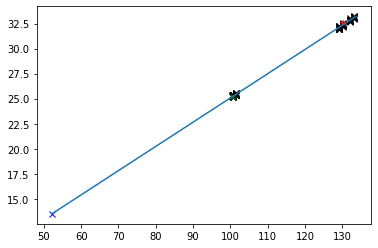

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     180324      1    52  5105  310104  310104  178661  26.533516  18.878820   
      191093      1    52  5105  310104  310104  189583 -28.644506 -26.480759   
      190835      1    52  5105  310104  310104  189325 -13.433495  36.907154   
      180551      1    52  5105  310104  310104  178888 -22.355637  23.680748   
      191274      1    52  5105  310104  310104  189764  27.794840 -27.745356   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      180125      1    52  5105  310104  310104  178462  23.465424 -23.671471   
      180653      1    52  5105  310104  310104  178990 -30.201958  13.083735   
      180343      1    52  5105  310104  310104  178680  26.434870  19.609829   
      180576      1    52  5105  310104  310104  178913 -20.466650  25.777409   
      180

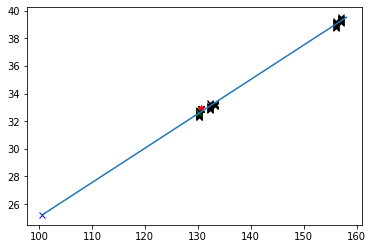

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     180324      1    52  5105  310104  310104  178661  26.533516  18.878820   
      180341      1    52  5105  310104  310104  178678  26.824478  19.102083   
      180404      1    52  5105  310104  310104  178741  11.480804  30.865913   
      180551      1    52  5105  310104  310104  178888 -22.355637  23.680748   
      180493      1    52  5105  310104  310104  178830  -5.396102  32.483467   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      181006      1    52  5105  310104  310104  179345  22.616638 -24.127665   
      180467      1    52  5105  310104  310104  178804  -5.492672  31.952875   
      181115      1    52  5105  310104  310104  179454  31.696337  -9.475986   
      180470      1    52  5105  310104  310104  178807  -7.416756  31.551600   
      180

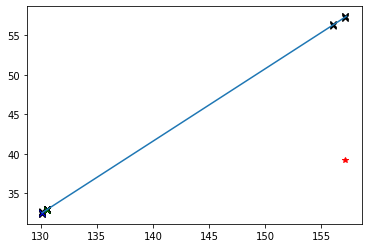

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     190656      1    52  5105  310104  310104  189146  31.689917  23.106749   
      200072      1    52  5105  310104  310104  198665   7.777260  44.735256   
      200334      1    52  5105  310104  310104  198927 -30.764193 -33.710995   
      199224      1    52  5105  310104  310104  197817  24.607456  39.005039   
      199980      1    52  5105  310104  310104  198573  35.183578  28.738602   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      200382      1    52  5105  310104  310104  198975 -10.934437 -44.692650   
      199982      1    52  5105  310104  310104  198575  34.636410  28.942841   
      199983      1    52  5105  310104  310104  198576  34.671299  28.900326   
      200223      1    52  5105  310104  310104  198816 -44.715874  10.857882   
      200

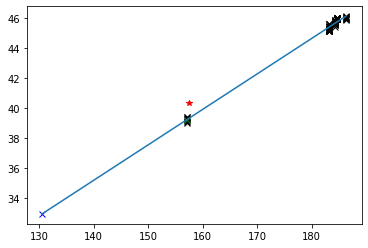

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     190656      1    52  5105  310104  310104  189146  31.689917  23.106749   
      190667      1    52  5105  310104  310104  189157  32.616203  23.700584   
      190780      1    52  5105  310104  310104  189270   1.825882  40.275208   
      191028      1    52  5105  310104  310104  189518 -40.281925  -1.766241   
      190664      1    52  5105  310104  310104  189154  35.526421  19.069002   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      190597      1    52  5105  310104  310104  189087  39.381172   6.485060   
      190838      1    52  5105  310104  310104  189328 -15.280679  35.328266   
      191338      1    52  5105  310104  310104  189828  36.681561 -15.854884   
      191015      1    52  5105  310104  310104  189505 -38.957165  -8.938009   
      190

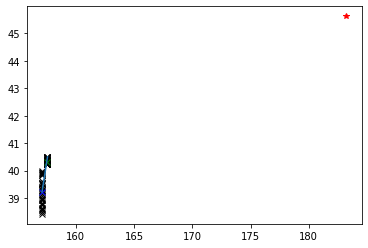

pid -22434.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     199979      1    52  5105  310104  310104  198572  36.565765  27.285645   
      200425      1    52  5105  310104  310104  199018  11.253813 -44.212517   
      209541      1    52  5105  310104  310104  208237  20.442492 -49.261127   
      209201      1    52  5105  310104  310104  207896  -4.697960  53.129532   
      200390      1    52  5105  310104  310104  198983  -6.278410 -45.177700   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      208545      1    52  5105  310104  310104  207240  24.969292  48.092678   
      208801      1    52  5105  310104  310104  207496 -51.677219 -14.048765   
      200063      1    52  5105  310104  310104  198656   9.255007  45.202099   
      208514      1    52  5105  310104  310104  207209  34.858646  41.498356   
      200

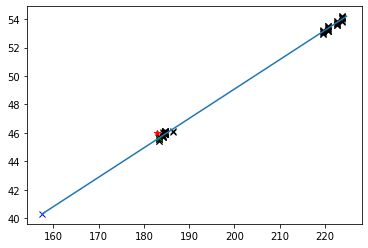

 20%|███████████████████████▌                                                                                              | 40/200 [00:39<03:15,  1.22s/it]

pid -22433.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     14798       1    52  5105  310104  310104   11559  -0.611114  -6.374771   
      11974       1    52  5105  310104  310104    8687   0.556261   6.381992   
      227188      1    52  5105  310104  310104  226064 -24.338886   5.788006   
      227011      1    52  5105  310104  310104  225879  -3.201331  24.847155   
      227324      1    52  5105  310104  310104  226208 -23.460796  -9.331975   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      13848       1    52  5105  310104  310104   10590  -5.604668  -3.193141   
      227612      1    52  5105  310104  310104  226496  20.179626 -15.015129   
      28204       1    52  5105  310104  310104   25240 -10.419642   2.583388   
      28165       1    52  5105  310104  310104   25192 -10.626540   2.576473   
      227

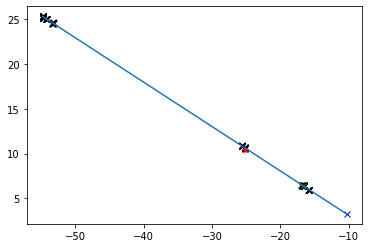

pid -22433.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     33160       1    52  5105  310104  310104   30264  -2.396858 -12.998404   
      33142       1    52  5105  310104  310104   30246  -2.452341 -13.264546   
      227367      1    52  5105  310104  310104  226251 -20.788898 -17.430157   
      33149       1    52  5105  310104  310104   30253  -4.372460 -12.768867   
      33243       1    52  5105  310104  310104   30347   7.069880 -11.158442   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      227369      1    52  5105  310104  310104  226253 -20.649637 -17.878704   
      226937      1    52  5105  310104  310104  225804  15.880095  22.427608   
      228111      1    52  5105  310104  310104  227007 -22.923458  -3.355260   
      227848      1    52  5105  310104  310104  226736   7.278007  21.995075   
      228

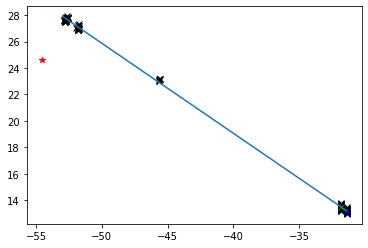

pid -22433.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     227392      1    52  5105  310104  310104  226276  -4.907386 -24.114851   
      227583      1    52  5105  310104  310104  226467  22.891335  -9.028992   
      226622      1    52  5105  310104  310104  225486  -5.748471 -27.418056   
      252883      1    52  5105  310104  310104  252151 -37.441185   8.569527   
      252829      1    52  5105  310104  310104  252095 -29.181429  24.971266   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      140915      1    52  5105  310104  310104  138965  33.556919 -52.305092   
      226207      1    52  5105  310104  310104  225066  11.986349  24.626478   
      252767      1    52  5105  310104  310104  252033  -4.491662  37.950867   
      226852      1    52  5105  310104  310104  225717  24.374712   4.121571   
      227

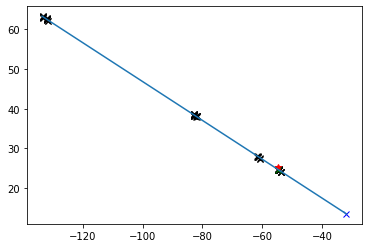

pid -22433.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     227392      1    52  5105  310104  310104  226276  -4.907386 -24.114851   
      227420      1    52  5105  310104  310104  226304  -5.109079 -24.727474   
      227324      1    52  5105  310104  310104  226208 -23.460796  -9.331975   
      227583      1    52  5105  310104  310104  226467  22.891335  -9.028992   
      227617      1    52  5105  310104  310104  226501  23.472126  -9.312351   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      226877      1    52  5105  310104  310104  225743  24.414568   5.413113   
      227218      1    52  5105  310104  310104  226098 -24.790977   3.278384   
      226939      1    52  5105  310104  310104  225806  15.265295  19.804714   
      227524      1    52  5105  310104  310104  226408   7.634654 -23.808241   
      227

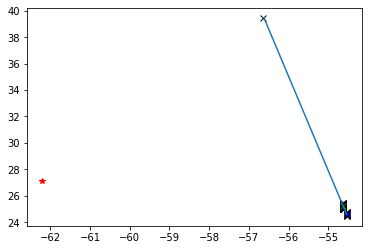

pid -22433.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     226641      1    52  5105  310104  310104  225506  -5.415053 -26.531235   
      226728      1    52  5105  310104  310104  225593  12.905779 -23.804834   
      226078      1    52  5105  310104  310104  224937  25.684250   8.576044   
      138146      1    52  5105  310104  310104  136176 -22.777222  36.715797   
      138501      1    52  5105  310104  310104  136531  10.510612 -42.175964   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      137949      1    52  5105  310104  310104  135979  42.855991   5.522221   
      138196      1    52  5105  310104  310104  136226 -32.565483  28.401058   
      251705      1    52  5105  310104  310104  250961   7.503071 -36.934723   
      226564      1    52  5105  310104  310104  225427 -21.574621 -16.198189   
      226

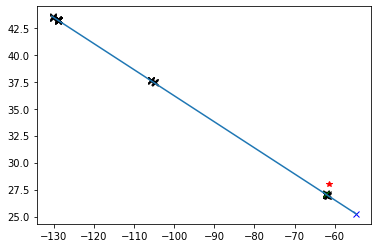

 20%|████████████████████████▏                                                                                             | 41/200 [00:41<03:25,  1.29s/it]

pid -22432.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     27753       1    52  5105  310104  310104   24776  4.486409 -4.437065   
      26492       1    52  5105  310104  310104   23499  4.737860 -4.679523   
      26290       1    52  5105  310104  310104   23292 -0.996568 -6.411943   
      32439       1    52  5105  310104  310104   29526 -4.606865 -8.337004   
      32033       1    52  5105  310104  310104   29115  4.620200  8.527575   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      32060       1    52  5105  310104  310104   29142  0.636790  9.615637   
      32333       1    52  5105  310104  310104   29420 -8.987935 -2.828598   
      32312       1    52  5105  310104  310104   29399 -9.596189  0.059202   
      32507       1    52  5105  310104  310104   29594 -1.336260 -9.326339   
      26546       1    52  5105  

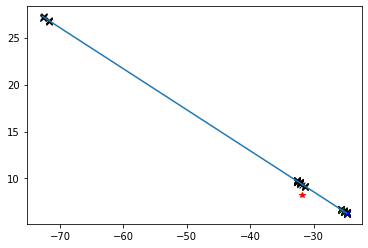

pid -22432.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     32640       1    52  5105  310104  310104   29729   6.029108  -5.916706   
      32590       1    52  5105  310104  310104   29679   6.138740  -6.022785   
      32548       1    52  5105  310104  310104   29636  -0.101821  -8.602107   
      225470      1    52  5105  310104  310104  224325 -19.185331  14.200965   
      36896       1    52  5105  310104  310104   34045  11.272004  -4.100815   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      32703       1    52  5105  310104  310104   29793   7.603963  -4.246940   
      32555       1    52  5105  310104  310104   29644   2.382893  -8.218949   
      225664      1    52  5105  310104  310104  224519 -13.626932 -19.708071   
      32299       1    52  5105  310104  310104   29386  -8.344751  -1.546186   
      325

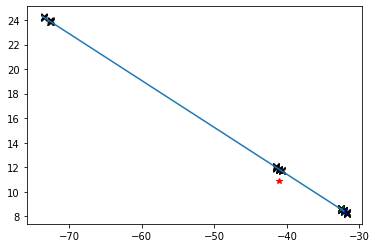

pid -22432.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     36848       1    52  5105  310104  310104   33997   7.830156  -7.615181   
      36816       1    52  5105  310104  310104   33964   7.941186  -7.718815   
      41618       1    52  5105  310104  310104   38822  -3.352939  14.566679   
      224285      1    52  5105  310104  310104  223134   6.193141  26.735033   
      36912       1    52  5105  310104  310104   34061   9.880752  -4.989774   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      42117       1    52  5105  310104  310104   39325  13.664918  -6.515976   
      225012      1    52  5105  310104  310104  223865  23.621178 -14.266162   
      36500       1    52  5105  310104  310104   33648 -10.759955  -1.634691   
      224765      1    52  5105  310104  310104  223618  -9.722127 -25.821695   
      224

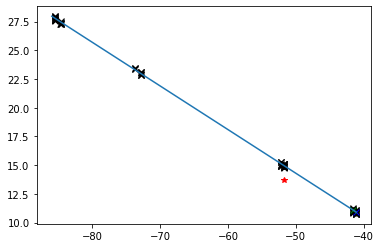

pid -22432.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     42079       1    52  5105  310104  310104   39285   9.895589  -9.525864   
      42095       1    52  5105  310104  310104   39302  10.010135  -9.630028   
      224809      1    52  5105  310104  310104  223662   4.154271 -26.253773   
      224305      1    52  5105  310104  310104  223154  13.043430  22.998896   
      225035      1    52  5105  310104  310104  223888  21.247852 -16.764170   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      224871      1    52  5105  310104  310104  223724   8.656661 -25.609224   
      41897       1    52  5105  310104  310104   39103  -8.398216 -11.259828   
      225040      1    52  5105  310104  310104  223893  21.912853 -15.612355   
      225000      1    52  5105  310104  310104  223853  22.990179 -14.230946   
      224

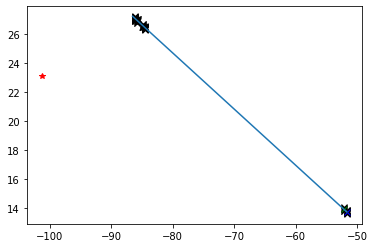

pid -22432.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     223920      1    52  5105  310104  310104  222767  17.162418 -15.452852   
      222579      1    52  5105  310104  310104  221418 -25.268087  -6.846038   
      223085      1    52  5105  310104  310104  221928  26.093533  -2.164707   
      222242      1    52  5105  310104  310104  221075  11.196932  23.670967   
      223923      1    52  5105  310104  310104  222770  13.407519 -18.787672   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      222974      1    52  5105  310104  310104  221817  19.168060 -17.951982   
      222473      1    52  5105  310104  310104  221310 -21.002026  15.769444   
      222577      1    52  5105  310104  310104  221416 -25.126564  -7.648656   
      222848      1    52  5105  310104  310104  221691  -3.170726 -26.073009   
      136

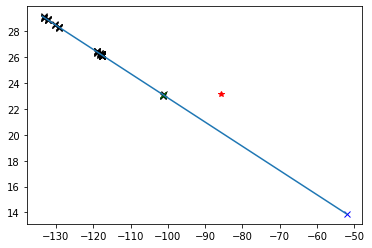

 21%|████████████████████████▊                                                                                             | 42/200 [00:42<03:19,  1.26s/it]

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     29796       1    52  5105  310104  310104   26852 -4.564980  0.463578   
      29626       1    52  5105  310104  310104   26681 -3.729301  2.672337   
      34009       1    52  5105  310104  310104   31120 -5.596249  0.578822   
      29279       1    52  5105  310104  310104   26327  4.267002  1.684531   
      34574       1    52  5105  310104  310104   31689  3.107744 -4.631750   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      33411       1    52  5105  310104  310104   30517  5.382551  1.608064   
      34812       1    52  5105  310104  310104   31932  5.552934  0.450200   
      30454       1    52  5105  310104  310104   27519  3.673701 -2.738689   
      30532       1    52  5105  310104  310104   27600  4.532043 -0.374366   
      29651       1    52  5105  

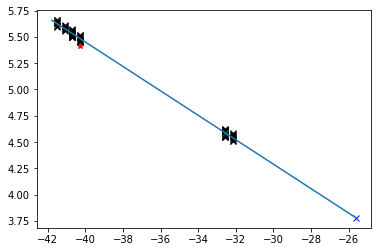

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     35378       1    52  5105  310104  310104   32510 -5.387188  0.554457   
      35693       1    52  5105  310104  310104   32826 -1.754742 -5.168833   
      34871       1    52  5105  310104  310104   31991  4.918965  2.268047   
      35314       1    52  5105  310104  310104   32444 -5.010674  2.050371   
      39876       1    52  5105  310104  310104   37055 -5.537465 -3.740802   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      40081       1    52  5105  310104  310104   37263 -1.475899 -6.427878   
      36051       1    52  5105  310104  310104   33189  5.456285 -0.159327   
      34172       1    52  5105  310104  310104   31284 -4.802589 -2.682921   
      35735       1    52  5105  310104  310104   32868 -0.255971 -5.366286   
      35409       1    52  5105  

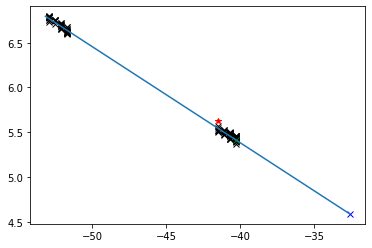

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     34009       1    52  5105  310104  310104   31120 -5.596249  0.578822   
      34290       1    52  5105  310104  310104   31404 -3.591434 -4.240205   
      35339       1    52  5105  310104  310104   32470 -5.292274  1.451276   
      39695       1    52  5105  310104  310104   36873 -6.855545  2.825222   
      35445       1    52  5105  310104  310104   32577 -5.478636  0.212774   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      34384       1    52  5105  310104  310104   31499 -1.359633 -5.300263   
      33560       1    52  5105  310104  310104   30667  2.086915  5.315541   
      34812       1    52  5105  310104  310104   31932  5.552934  0.450200   
      34789       1    52  5105  310104  310104   31909  5.464506 -1.666606   
      34074       1    52  5105  

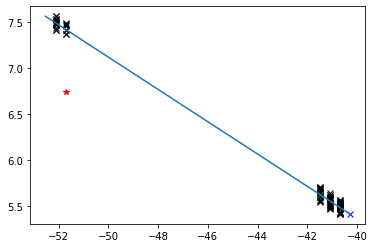

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     39748       1    52  5105  310104  310104   36926 -6.700140  0.706380   
      44626       1    52  5105  310104  310104   41850  0.853892 -8.325385   
      45621       1    52  5105  310104  310104   42851 -0.544287 -8.395870   
      38463       1    52  5105  310104  310104   35630 -6.570818 -1.849422   
      38066       1    52  5105  310104  310104   35232 -0.611680  6.842477   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      44342       1    52  5105  310104  310104   41564 -7.789667 -2.771825   
      40154       1    52  5105  310104  310104   37336  0.788344 -6.792666   
      39813       1    52  5105  310104  310104   36991 -6.838290  0.024847   
      45269       1    52  5105  310104  310104   42497 -6.300484  5.661716   
      45353       1    52  5105  

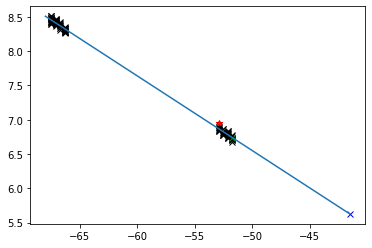

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     38335       1    52  5105  310104  310104   35502 -6.910293  0.730037   
      45657       1    52  5105  310104  310104   42887  1.518502 -9.398579   
      39789       1    52  5105  310104  310104   36967 -6.758366 -0.830183   
      45746       1    52  5105  310104  310104   42977  5.058724 -8.062958   
      45263       1    52  5105  310104  310104   42491 -4.568885  8.356773   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      40252       1    52  5105  310104  310104   37434  2.886888 -6.050652   
      39055       1    52  5105  310104  310104   36226  7.040833 -0.417823   
      38749       1    52  5105  310104  310104   35918 -0.654445 -6.952674   
      45403       1    52  5105  310104  310104   42632 -9.545214 -1.248408   
      45156       1    52  5105  

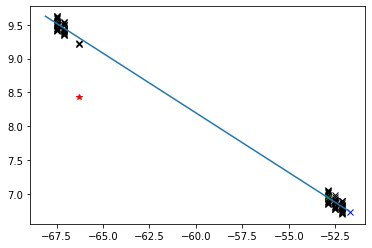

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     44250       1    52  5105  310104  310104   41472 -8.380385   0.908301   
      45366       1    52  5105  310104  310104   42595 -8.521749   0.926488   
      50654       1    52  5105  310104  310104   47930 -6.279752  10.022337   
      49626       1    52  5105  310104  310104   46893  2.887340  11.540886   
      49684       1    52  5105  310104  310104   46951  0.026585  11.969953   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      44924       1    52  5105  310104  310104   42149  8.538813   1.759570   
      45358       1    52  5105  310104  310104   42587 -8.361203   1.497921   
      50649       1    52  5105  310104  310104   47925 -4.967661  10.739477   
      50104       1    52  5105  310104  310104   47375 -3.055211 -11.417807   
      44102       1  

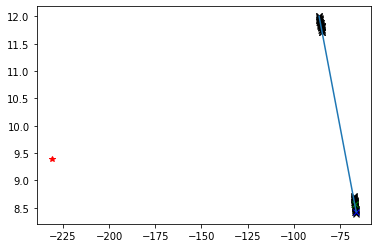

pid -22430.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     70451       1    52  5105  310104  310104   67835 -9.361339  0.838509   
      75965       1    52  5105  310104  310104   73366  8.536621 -4.322971   
      71064       1    52  5105  310104  310104   68449  8.678846 -3.602792   
      75434       1    52  5105  310104  310104   72834 -9.426131 -1.653681   
      70236       1    52  5105  310104  310104   67619 -4.679811  8.149390   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      70963       1    52  5105  310104  310104   68348  5.508950 -7.494123   
      75592       1    52  5105  310104  310104   72992 -5.874176 -7.431578   
      70508       1    52  5105  310104  310104   67892 -9.289886 -0.401957   
      70632       1    52  5105  310104  310104   68016 -7.261734 -5.803326   
      75573       1    52  5105  

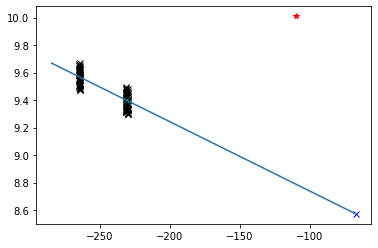

 22%|█████████████████████████▉                                                                                            | 44/200 [00:44<02:45,  1.06s/it]

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     38097       1    52  5105  310104  310104   35263 -0.905529  3.214455   
      38020       1    52  5105  310104  310104   35186 -0.913462  3.242303   
      43064       1    52  5105  310104  310104   40278 -3.313859 -2.889561   
      42545       1    52  5105  310104  310104   39756 -0.981029  4.316188   
      43366       1    52  5105  310104  310104   40585  2.606878 -3.538610   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      42581       1    52  5105  310104  310104   39792 -0.284267  4.477225   
      43392       1    52  5105  310104  310104   40611  3.376671 -2.954175   
      38456       1    52  5105  310104  310104   35623 -3.076408 -1.128905   
      38288       1    52  5105  310104  310104   35455 -2.869990  1.581580   
      39126       1    52  5105  

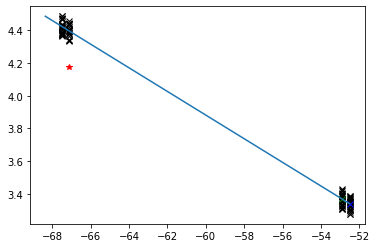

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     42602       1    52  5105  310104  310104   39813 -1.139010  4.016858   
      42528       1    52  5105  310104  310104   39739 -1.145917  4.046801   
      47625       1    52  5105  310104  310104   44873 -2.533946 -5.036477   
      48661       1    52  5105  310104  310104   45920 -5.495847  0.952630   
      48772       1    52  5105  310104  310104   46031 -5.532878 -0.709483   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      49309       1    52  5105  310104  310104   46576  5.095340 -2.316733   
      42346       1    52  5105  310104  310104   39555  2.969881  3.007004   
      49398       1    52  5105  310104  310104   46665  5.417408 -0.914151   
      47530       1    52  5105  310104  310104   44777 -4.355093 -3.448229   
      48018       1    52  5105  

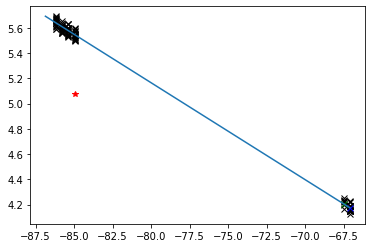

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     48465       1    52  5105  310104  310104   45721 -1.393110  4.880977   
      48925       1    52  5105  310104  310104   46184 -3.477493 -3.699625   
      51771       1    52  5105  310104  310104   49061 -5.248090  3.497542   
      51935       1    52  5105  310104  310104   49225 -6.297929 -0.244473   
      48512       1    52  5105  310104  310104   45769 -2.654012  4.347463   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      48607       1    52  5105  310104  310104   45866 -3.981513  3.243287   
      46964       1    52  5105  310104  310104   44209  0.254976  5.069771   
      51236       1    52  5105  310104  310104   48521  6.145014  1.209938   
      47535       1    52  5105  310104  310104   44782 -3.935750 -3.202127   
      46863       1    52  5105  

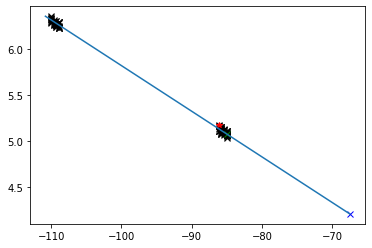

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     46994       1    52  5105  310104  310104   44239 -1.422967  4.980987   
      53154       1    52  5105  310104  310104   50452 -5.126418  4.987481   
      51730       1    52  5105  310104  310104   49020 -5.174032  5.087942   
      46858       1    52  5105  310104  310104   44102  2.223525  4.677779   
      51529       1    52  5105  310104  310104   48817 -1.842018  7.017989   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      47819       1    52  5105  310104  310104   45068  1.999742 -4.803038   
      47883       1    52  5105  310104  310104   45133  3.944735 -3.447993   
      53872       1    52  5105  310104  310104   51177  5.167769 -5.080330   
      48593       1    52  5105  310104  310104   45852 -4.354219  2.789144   
      51966       1    52  5105  

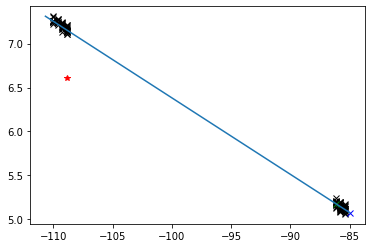

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     51520       1    52  5105  310104  310104   48808  -1.862728  6.447075   
      58785       1    52  5105  310104  310104   56111   9.282075  1.022812   
      62383       1    52  5105  310104  310104   59724 -12.214466 -1.251701   
      52796       1    52  5105  310104  310104   50092   6.174487  2.442829   
      51960       1    52  5105  310104  310104   49250  -6.643120 -0.688945   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      52217       1    52  5105  310104  310104   49508  -3.249169 -5.806908   
      51497       1    52  5105  310104  310104   48785   0.802049  6.686024   
      59819       1    52  5105  310104  310104   57151   9.245521  0.080153   
      59163       1    52  5105  310104  310104   56492  -6.703190  6.534785   
      53162       1  

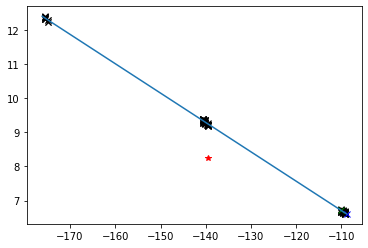

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     57752       1    52  5105  310104  310104   55074 -2.314372   7.917972   
      62558       1    52  5105  310104  310104   59900 -2.963298  -9.706056   
      61581       1    52  5105  310104  310104   58918 -0.762156 -10.053879   
      62164       1    52  5105  310104  310104   59504  0.099801  10.144976   
      61544       1    52  5105  310104  310104   58881 -2.969788  -9.633269   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      59401       1    52  5105  310104  310104   56731 -6.860397  -4.794701   
      57742       1    52  5105  310104  310104   55064 -2.056175   8.048605   
      59037       1    52  5105  310104  310104   56365 -0.768400   8.336071   
      62473       1    52  5105  310104  310104   59814 -6.792793  -7.618268   
      66763       1  

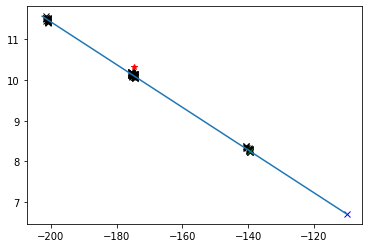

pid -22428.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     62196       1    52  5105  310104  310104   59536  -2.928842   9.887818   
      61003       1    52  5105  310104  310104   58340  -2.935529   9.912376   
      61554       1    52  5105  310104  310104   58891  -2.207772 -10.047915   
      825         1    52  5105  310104  310104   64071  -2.367695  11.728215   
      61036       1    52  5105  310104  310104   58373  -4.367236   9.311836   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      62098       1    52  5105  310104  310104   59438   0.079334  10.416969   
      61492       1    52  5105  310104  310104   58829  -4.814598  -9.029399   
      67097       1    52  5105  310104  310104   64459  -3.161101 -11.482416   
      62351       1    52  5105  310104  310104   59692 -10.276029   1.998772   
      612

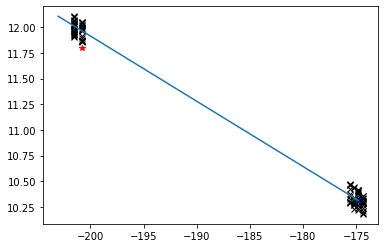

 22%|██████████████████████████▌                                                                                           | 45/200 [00:45<03:09,  1.22s/it]

pid -22427.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     97875       1    52  5105  310104  310104   95543 -0.259220 -3.245584   
      97772       1    52  5105  310104  310104   95438 -0.260506 -3.274767   
      97588       1    52  5105  310104  310104   95252 -2.668655 -1.914085   
      102379      1    52  5105  310104  310104  100087 -0.861489 -4.568256   
      97546       1    52  5105  310104  310104   95209 -2.970187 -1.340828   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      102787      1    52  5105  310104  310104  100497  4.315512 -1.497279   
      96809       1    52  5105  310104  310104   94465  2.899584  1.589654   
      101873      1    52  5105  310104  310104   99579 -3.277750  3.180522   
      97833       1    52  5105  310104  310104   95500  0.631872 -3.246358   
      102629      1    52  5105  

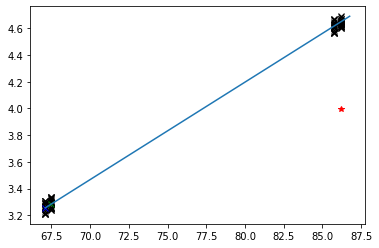

pid -22427.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     102398      1    52  5105  310104  310104  100106 -0.321071 -3.984853   
      102757      1    52  5105  310104  310104  100467  3.939487 -0.607501   
      106922      1    52  5105  310104  310104  104692 -2.348987 -4.288003   
      102555      1    52  5105  310104  310104  100264  2.428324 -3.168905   
      107290      1    52  5105  310104  310104  105062  4.467972 -2.016360   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      106480      1    52  5105  310104  310104  104245 -3.889690  3.078285   
      101880      1    52  5105  310104  310104   99586 -2.784013  2.753961   
      102094      1    52  5105  310104  310104   99800 -3.875463 -0.658108   
      102012      1    52  5105  310104  310104   99718 -4.006381  0.601646   
      107935      1    52  5105  

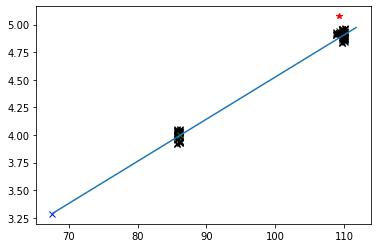

pid -22427.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     108380      1    52  5105  310104  310104  106166 -0.416598 -5.058727   
      107010      1    52  5105  310104  310104  104780 -0.419934 -5.104462   
      106039      1    52  5105  310104  310104  103801  4.263568  2.793884   
      106364      1    52  5105  310104  310104  104128 -0.771466  5.038649   
      112577      1    52  5105  310104  310104  110398 -4.839941  4.785415   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      108205      1    52  5105  310104  310104  105988 -4.272702 -2.809566   
      106930      1    52  5105  310104  310104  104700 -2.605086 -4.427183   
      110764      1    52  5105  310104  310104  108574  4.974944  4.796400   
      112276      1    52  5105  310104  310104  110092  1.550017  6.664231   
      106750      1    52  5105  

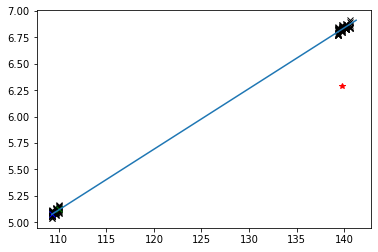

pid -22427.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     113017      1    52  5105  310104  310104  110840 -0.527871 -6.265023   
      111650      1    52  5105  310104  310104  109464 -0.532892 -6.313066   
      115472      1    52  5105  310104  310104  113327  4.581327  7.011694   
      113182      1    52  5105  310104  310104  111006  3.994938 -4.854053   
      116329      1    52  5105  310104  310104  114188  5.834445 -6.012990   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      115301      1    52  5105  310104  310104  113154  8.353603 -0.342395   
      115392      1    52  5105  310104  310104  113245  6.403740  5.571121   
      115859      1    52  5105  310104  310104  113716 -8.022376 -2.772865   
      112909      1    52  5105  310104  310104  110731 -3.700224 -5.161837   
      115973      1    52  5105  

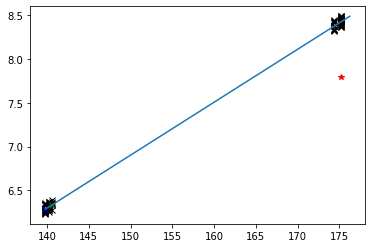

pid -22427.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     125115      1    52  5105  310104  310104  123049  -0.920038 -10.099827   
      126257      1    52  5105  310104  310104  124195  -0.922632 -10.120454   
      126233      1    52  5105  310104  310104  124171  -2.556018  -9.835675   
      130960      1    52  5105  310104  310104  128933 -11.011369  -4.507263   
      125134      1    52  5105  310104  310104  123068  -1.883697  -9.967470   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      131167      1    52  5105  310104  310104  129140  -0.517499 -12.040024   
      126377      1    52  5105  310104  310104  124316   6.467751  -7.929725   
      130769      1    52  5105  310104  310104  128742  -9.548103   7.288254   
      130450      1    52  5105  310104  310104  128418   9.572007   7.325469   
      130

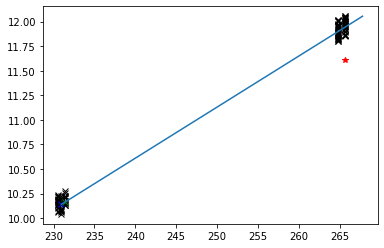

 23%|███████████████████████████▏                                                                                          | 46/200 [00:47<03:04,  1.20s/it]

pid -22426.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     27262       1    52  5105  310104  310104   24280 -5.091318  0.085699   
      30024       1    52  5105  310104  310104   27080 -4.990731 -4.278321   
      25946       1    52  5105  310104  310104   22947 -5.155068  1.316387   
      27209       1    52  5105  310104  310104   24224 -4.882292  1.699170   
      29189       1    52  5105  310104  310104   26237  6.512476  0.909983   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      26719       1    52  5105  310104  310104   23727  4.726275  1.799627   
      27220       1    52  5105  310104  310104   24237 -4.744677  2.136694   
      30971       1    52  5105  310104  310104   28043 -3.324786  5.623607   
      31125       1    52  5105  310104  310104   28199 -5.919128  2.592258   
      31144       1    52  5105  

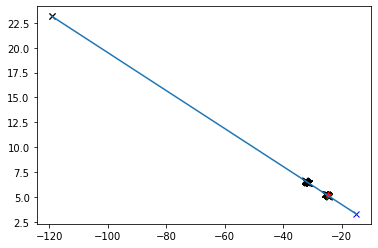

pid -22426.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x         y  \
entry subentry                                                                 
4     27298       1    52  5105  310104  310104   24317  -5.229256  0.089122   
      25885       1    52  5105  310104  310104   22886  -5.530555  0.097621   
      31440       1    52  5105  310104  310104   28517  -1.902201 -7.624522   
      27144       1    52  5105  310104  310104   24155  -3.839430  3.550862   
      25562       1    52  5105  310104  310104   22559   1.002979  5.285798   
...             ...   ...   ...     ...     ...     ...        ...       ...   
      27063       1    52  5105  310104  310104   24072  -3.123873  4.266597   
      26040       1    52  5105  310104  310104   23041  -4.910156 -2.671601   
      30870       1    52  5105  310104  310104   27941   0.794436  7.606924   
      225977      1    52  5105  310104  310104  224834  22.446175 -6.025001   
      27209       1  

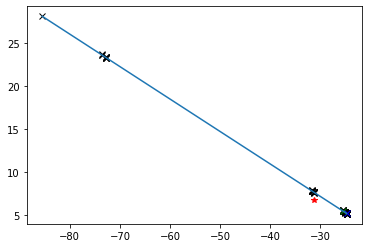

pid -22426.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x          y  \
entry subentry                                                                 
4     31160       1    52  5105  310104  310104   28234 -6.792521   0.132672   
      31206       1    52  5105  310104  310104   28280 -6.924166   0.138229   
      1264        1    52  5105  310104  310104   27346  1.009583  -7.117376   
      36258       1    52  5105  310104  310104   33398  1.259007   9.917441   
      30606       1    52  5105  310104  310104   27676  6.898510   0.632970   
...             ...   ...   ...     ...     ...     ...       ...        ...   
      36767       1    52  5105  310104  310104   33915  0.331779 -10.190982   
      36778       1    52  5105  310104  310104   33926 -0.245916 -10.054980   
      31107       1    52  5105  310104  310104   28181 -6.492240   2.203218   
      31204       1    52  5105  310104  310104   28278 -6.996385   0.054356   
      36188       1  

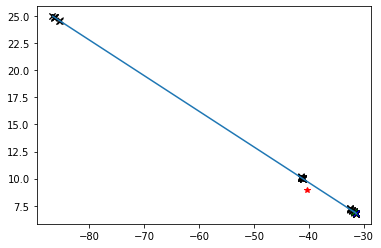

pid -22426.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     35401       1    52  5105  310104  310104   32533  -8.962151   0.210709   
      36934       1    52  5105  310104  310104   34083   9.038066  -1.465996   
      41606       1    52  5105  310104  310104   38810  -1.067241  11.742493   
      36453       1    52  5105  310104  310104   33601  -9.065394   1.288041   
      36687       1    52  5105  310104  310104   33835  -4.861935  -7.870433   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      223330      1    52  5105  310104  310104  222177   0.204272  23.782158   
      223925      1    52  5105  310104  310104  222772  15.491146 -17.591555   
      40659       1    52  5105  310104  310104   37850   2.862814  11.468668   
      223095      1    52  5105  310104  310104  221938  23.366028   4.440660   
      223

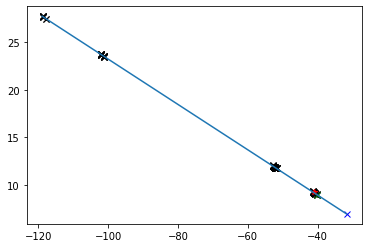

pid -22426.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     36467       1    52  5105  310104  310104   33615  -9.261665   0.223361   
      36519       1    52  5105  310104  310104   33667  -9.396420   0.229232   
      36678       1    52  5105  310104  310104   33826  -3.791763  -8.599815   
      224539      1    52  5105  310104  310104  223391 -24.623346   1.599368   
      224526      1    52  5105  310104  310104  223378 -23.684778   6.922254   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      36498       1    52  5105  310104  310104   33646  -9.326467  -1.606039   
      224788      1    52  5105  310104  310104  223641   3.029271 -23.997499   
      224525      1    52  5105  310104  310104  223377 -23.591877   7.449126   
      224435      1    52  5105  310104  310104  223286 -14.230287  20.077085   
      224

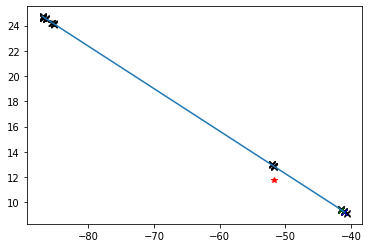

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars
 24%|███████████████████████████▋                                                                                          | 47/200 [00:48<03:00,  1.18s/it]

pid -22425.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     43353       1    52  5105  310104  310104   40572  2.117340 -3.574555   
      47075       1    52  5105  310104  310104   44320 -1.573296  4.896725   
      47867       1    52  5105  310104  310104   45117  4.192117 -3.016552   
      48786       1    52  5105  310104  310104   46045 -5.121249  0.116058   
      48764       1    52  5105  310104  310104   46023 -5.041445 -0.898490   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      46698       1    52  5105  310104  310104   43941  4.988363  1.408948   
      48967       1    52  5105  310104  310104   46227 -3.067932 -4.024051   
      43328       1    52  5105  310104  310104   40546  1.482018 -3.836507   
      48797       1    52  5105  310104  310104   46056 -5.079031 -0.809188   
      42807       1    52  5105  

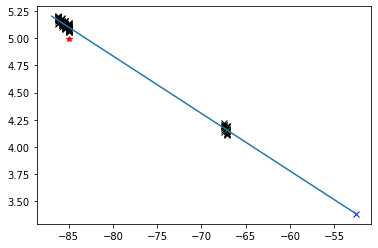

pid -22425.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     49182       1    52  5105  310104  310104   46448  2.563652 -4.316298   
      47850       1    52  5105  310104  310104   45100  2.584318 -4.347875   
      53957       1    52  5105  310104  310104   51262  6.891279 -2.319040   
      51342       1    52  5105  310104  310104   48628  5.595732  4.699474   
      48707       1    52  5105  310104  310104   45966 -4.860102  1.105446   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      52560       1    52  5105  310104  310104   49855  6.413153 -3.448639   
      52073       1    52  5105  310104  310104   49363 -6.673896 -3.135370   
      2243        1    52  5105  310104  310104   50084  6.612832  3.088164   
      52726       1    52  5105  310104  310104   50021  7.137653  1.334411   
      48336       1    52  5105  

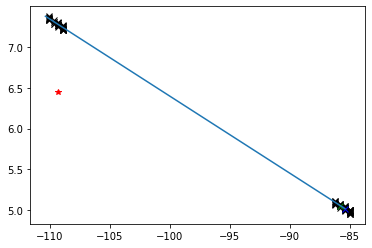

pid -22425.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     53773       1    52  5105  310104  310104   51073  3.302155 -5.533536   
      52460       1    52  5105  310104  310104   49754  3.318738 -5.557973   
      59501       1    52  5105  310104  310104   56832 -4.334260 -7.605722   
      59167       1    52  5105  310104  310104   56496 -6.312712  6.024032   
      59471       1    52  5105  310104  310104   56802 -2.463009 -8.402493   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      53814       1    52  5105  310104  310104   51118  3.918201 -5.020640   
      59489       1    52  5105  310104  310104   56820 -3.625751 -8.018396   
      57758       1    52  5105  310104  310104   55080 -2.606623  8.312985   
      59595       1    52  5105  310104  310104   56926  2.184094 -8.398822   
      53463       1    52  5105  

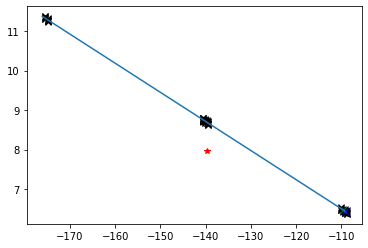

pid -22425.0
final                 run  lumi   evt    nhit   hit_n  hit_id         x         y  \
entry subentry                                                                
4     58500       1    52  5105  310104  310104   55824  4.101081 -6.831997   
      61692       1    52  5105  310104  310104   59030  5.005402 -8.290031   
      61432       1    52  5105  310104  310104   58769 -6.556753 -7.131278   
      57497       1    52  5105  310104  310104   54817  7.251541  3.294931   
      67001       1    52  5105  310104  310104   64362 -9.869447 -4.829473   
...             ...   ...   ...     ...     ...     ...       ...       ...   
      58447       1    52  5105  310104  310104   55770  1.543169 -7.696670   
      60800       1    52  5105  310104  310104   58134  7.291332  6.524125   
      61684       1    52  5105  310104  310104   59022  4.362455 -8.533101   
      58150       1    52  5105  310104  310104   55473 -7.226208 -3.059360   
      60866       1    52  5105  

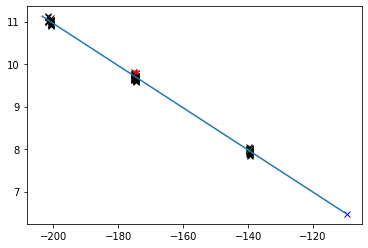

 24%|████████████████████████████▎                                                                                         | 48/200 [00:49<02:57,  1.17s/it]

pid -22423.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     17657       1    52  5105  310104  310104   14496   1.328419  10.622975   
      24440       1    52  5105  310104  310104   21410   0.605892 -14.422850   
      20423       1    52  5105  310104  310104   17308   5.825318  -9.040743   
      19321       1    52  5105  310104  310104   16191  -9.441792  -3.936870   
      17191       1    52  5105  310104  310104   14020   6.786270   8.345815   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      17407       1    52  5105  310104  310104   14244   6.017885   8.381462   
      235468      1    52  5105  310104  310104  234496   3.848668 -23.783632   
      235586      1    52  5105  310104  310104  234616  12.341362 -20.691694   
      235343      1    52  5105  310104  310104  234370 -11.714878 -21.395536   
      235

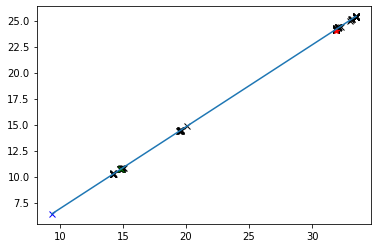

pid -22423.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     235014      1    52  5105  310104  310104  234036   5.208591  23.414240   
      235259      1    52  5105  310104  310104  234285 -22.881624  -7.196348   
      234874      1    52  5105  310104  310104  233892  24.693445   3.045573   
      235087      1    52  5105  310104  310104  234109 -11.041578  21.291206   
      260004      1    52  5105  310104  310104  259386  38.243992   0.998611   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      235318      1    52  5105  310104  310104  234344 -20.433294 -14.575762   
      235124      1    52  5105  310104  310104  234146 -13.202845  21.535315   
      235636      1    52  5105  310104  310104  234670  22.837128 -10.412201   
      235585      1    52  5105  310104  310104  234615  12.460099 -20.592062   
      234

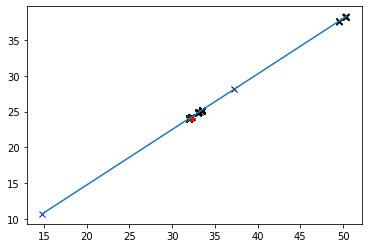

pid -22423.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     235014      1    52  5105  310104  310104  234036   5.208591  23.414240   
      234996      1    52  5105  310104  310104  234018   5.193023  23.429943   
      235259      1    52  5105  310104  310104  234285 -22.881624  -7.196348   
      178695      1    52  5105  310104  310104  177026 -10.748268 -24.255533   
      238844      1    52  5105  310104  310104  237955 -23.068132  -9.098806   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      240825      1    52  5105  310104  310104  239965 -25.406561   0.207074   
      242593      1    52  5105  310104  310104  241752  21.242752  15.352493   
      235469      1    52  5105  310104  310104  234497   3.293668 -23.783632   
      242512      1    52  5105  310104  310104  241671  24.762371   8.702883   
      238

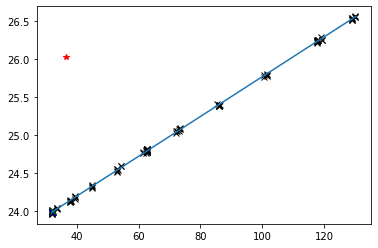

pid -22423.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     235820      1    52  5105  310104  310104  234858   5.664205  25.411602   
      235760      1    52  5105  310104  310104  234796  18.078928  19.587488   
      236303      1    52  5105  310104  310104  235347   3.358668 -25.816366   
      236011      1    52  5105  310104  310104  235050 -20.689465  15.797531   
      261058      1    52  5105  310104  310104  260453  -4.036623 -35.892605   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      236009      1    52  5105  310104  310104  235048 -21.216965  14.883875   
      261772      1    52  5105  310104  310104  261181  28.628263 -27.124748   
      261326      1    52  5105  310104  310104  260730  29.642553  25.948765   
      236334      1    52  5105  310104  310104  235378   7.283641 -25.548355   
      235

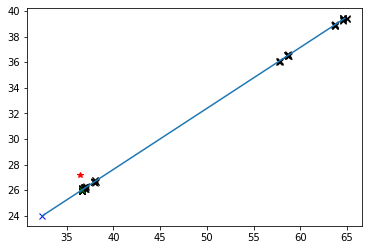

 24%|████████████████████████████▉                                                                                         | 49/200 [00:50<02:56,  1.17s/it]

pid -22422.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     12704       1    52  5105  310104  310104    9424  -3.757629   4.553457   
      28646       1    52  5105  310104  310104   25687  11.433976   3.981813   
      227674      1    52  5105  310104  310104  226558  25.970921  -1.382131   
      28994       1    52  5105  310104  310104   26039  -3.146244 -11.904503   
      226862      1    52  5105  310104  310104  225727  26.471115   3.206708   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      227652      1    52  5105  310104  310104  226536  25.882275  -3.402431   
      14604       1    52  5105  310104  310104   11363  -2.163123  -5.490119   
      28783       1    52  5105  310104  310104   25824  -3.329305  11.707257   
      227491      1    52  5105  310104  310104  226375  -3.656330 -25.816366   
      160

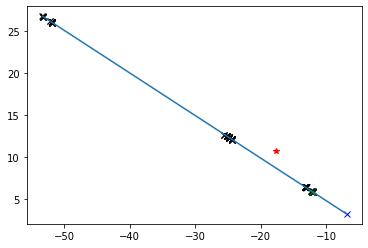

pid -22422.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     17921       1    52  5105  310104  310104   14762  -3.625180  10.161769   
      20040       1    52  5105  310104  310104   16918   0.880012 -10.187764   
      228659      1    52  5105  310104  310104  227559  20.357479  19.168177   
      229912      1    52  5105  310104  310104  228826   3.433668 -23.538973   
      229167      1    52  5105  310104  310104  228071  13.810904 -24.389421   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      18156       1    52  5105  310104  310104   14999  -6.865819   7.559159   
      229573      1    52  5105  310104  310104  228480  -9.198308  21.972139   
      20671       1    52  5105  310104  310104   17576   9.693453  -4.544302   
      18397       1    52  5105  310104  310104   15247  -9.554802   4.816421   
      179

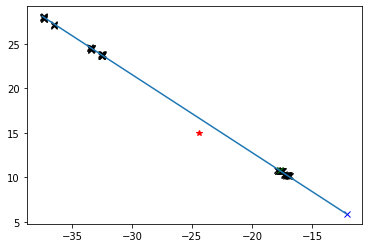

pid -22422.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     28811       1    52  5105  310104  310104   25852  -8.240858  12.484277   
      28792       1    52  5105  310104  310104   25833  -8.442324  12.808651   
      28877       1    52  5105  310104  310104   25921 -14.906794   1.220750   
      29147       1    52  5105  310104  310104   26195  14.857673  -1.671826   
      228988      1    52  5105  310104  310104  227892 -22.545603 -15.726020   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      229270      1    52  5105  310104  310104  228174  25.684460 -10.543452   
      29107       1    52  5105  310104  310104   26153  12.729278  -7.156438   
      29086       1    52  5105  310104  310104   26132  12.607436  -9.352166   
      228789      1    52  5105  310104  310104  227689  -5.104610  26.030912   
      228

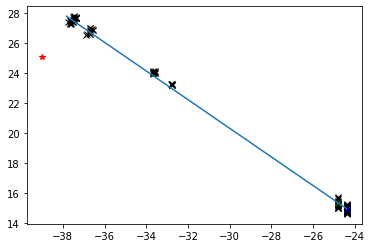

pid -22422.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     228818      1    52  5105  310104  310104  227718 -13.410044  21.183294   
      228842      1    52  5105  310104  310104  227742 -13.467130  21.313553   
      228176      1    52  5105  310104  310104  227076 -25.466194  -9.923991   
      227965      1    52  5105  310104  310104  226854  -7.890766  25.557632   
      228914      1    52  5105  310104  310104  227818 -24.013035   7.690321   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      228283      1    52  5105  310104  310104  227183  -4.775350 -27.012133   
      227777      1    52  5105  310104  310104  226664  24.086613  11.456910   
      228747      1    52  5105  310104  310104  227647   2.523668  24.983633   
      228248      1    52  5105  310104  310104  227148  -4.995319 -26.651636   
      228

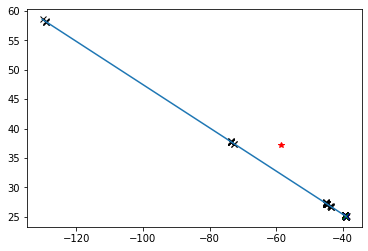

pid -22422.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     254564      1    52  5105  310104  310104  253858 -19.198921  31.950796   
      254776      1    52  5105  310104  310104  254072 -10.991749 -35.617695   
      274164      1    52  5105  310104  310104  273721  47.495579  21.932514   
      254565      1    52  5105  310104  310104  253859 -19.234339  31.932207   
      254915      1    52  5105  310104  310104  254212  34.056145 -15.144068   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      274301      1    52  5105  310104  310104  273858 -21.254602  47.706165   
      274506      1    52  5105  310104  310104  274069  21.198221 -47.726685   
      274349      1    52  5105  310104  310104  273907 -43.321903  29.161531   
      254672      1    52  5105  310104  310104  253968 -36.530434   7.874144   
      254

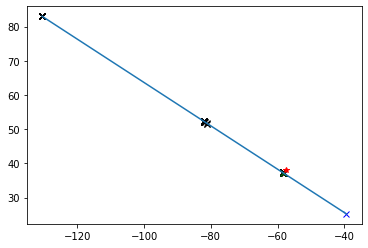

 25%|█████████████████████████████▌                                                                                        | 50/200 [00:51<02:53,  1.16s/it]

pid -22421.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     16305       1    52  5105  310104  310104   13124   6.430940  -0.184469   
      19659       1    52  5105  310104  310104   16531  -4.192118  -9.311736   
      231013      1    52  5105  310104  310104  229939  21.115080  12.610163   
      231148      1    52  5105  310104  310104  230074   1.693182  25.730343   
      14886       1    52  5105  310104  310104   11648  -0.274553  -6.419080   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      230998      1    52  5105  310104  310104  229923  25.274876   4.834197   
      231336      1    52  5105  310104  310104  230268 -25.275509   4.830615   
      231661      1    52  5105  310104  310104  230593  23.636520 -10.059106   
      231079      1    52  5105  310104  310104  230005  16.330919  19.885309   
      231

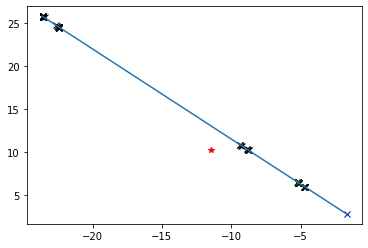

pid -22421.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     20947       1    52  5105  310104  310104   17860  10.213711  -0.716189   
      20940       1    52  5105  310104  310104   17853  10.111634  -1.360675   
      17497       1    52  5105  310104  310104   14334   3.245698  10.319308   
      20946       1    52  5105  310104  310104   17859  10.208317  -0.750243   
      18176       1    52  5105  310104  310104   15021  -6.885000   7.539979   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      229072      1    52  5105  310104  310104  227976  -9.832403 -24.620682   
      20292       1    52  5105  310104  310104   17172   4.625530  -9.652065   
      18444       1    52  5105  310104  310104   15294  -8.994776   5.915533   
      23884       1    52  5105  310104  310104   20846  -9.182791 -11.827300   
      205

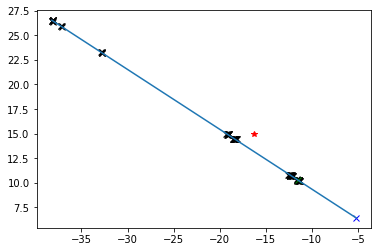

pid -22421.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     24964       1    52  5105  310104  310104   21949  13.587522  -6.282460   
      22812       1    52  5105  310104  310104   19751 -12.645040   6.941572   
      24141       1    52  5105  310104  310104   21106  -2.057030 -14.762509   
      230183      1    52  5105  310104  310104  229099  26.099869   2.532487   
      230877      1    52  5105  310104  310104  229799  24.576097  -9.504606   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      22223       1    52  5105  310104  310104   19157  -1.727087  14.296521   
      21618       1    52  5105  310104  310104   18540  10.768927   9.595749   
      24959       1    52  5105  310104  310104   21943  14.016507  -5.056489   
      230451      1    52  5105  310104  310104  229369 -16.407501  20.219830   
      234

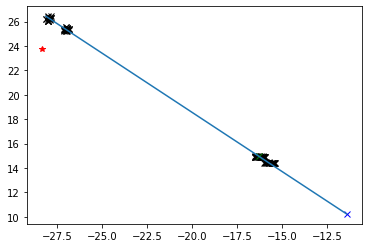

pid -22421.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     230905      1    52  5105  310104  310104  229829  23.162842  -5.309670   
      230019      1    52  5105  310104  310104  228934  19.902508 -16.681307   
      229636      1    52  5105  310104  310104  228544 -16.007589  21.159700   
      255233      1    52  5105  310104  310104  254535 -36.303463  13.288557   
      256072      1    52  5105  310104  310104  255385  35.379520  -3.405986   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      255220      1    52  5105  310104  310104  254520 -30.129982  25.242603   
      229804      1    52  5105  310104  310104  228716 -22.027952 -15.098065   
      255179      1    52  5105  310104  310104  254478 -21.394072  32.970131   
      230906      1    52  5105  310104  310104  229830  22.759979  -7.594423   
      254

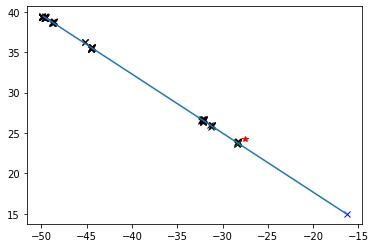

 26%|██████████████████████████████                                                                                        | 51/200 [00:52<02:49,  1.14s/it]

pid -22419.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     15034       1    52  5105  310104  310104   11797  -0.520864  -6.386652   
      10948       1    52  5105  310104  310104    7645   5.769011   1.381668   
      83265       1    52  5105  310104  310104   80735   4.033815  11.260915   
      12644       1    52  5105  310104  310104    9362  -1.677122   6.232623   
      83065       1    52  5105  310104  310104   80533  10.528824  -6.935095   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      237477      1    52  5105  310104  310104  236554  26.396891   7.285790   
      10944       1    52  5105  310104  310104    7641   5.781853   1.284120   
      83469       1    52  5105  310104  310104   80940 -11.036455  -4.409463   
      83285       1    52  5105  310104  310104   80755   0.284766  12.253940   
      126

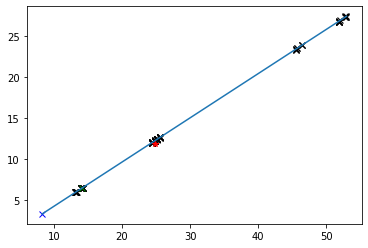

 26%|██████████████████████████████▋                                                                                       | 52/200 [00:53<02:31,  1.02s/it]

pid -22419.0
final                 run  lumi   evt    nhit   hit_n  hit_id          x          y  \
entry subentry                                                                  
4     83532       1    52  5105  310104  310104   81004  -2.307342 -11.528406   
      87767       1    52  5105  310104  310104   85303   2.983327 -14.744479   
      87684       1    52  5105  310104  310104   85219 -10.901249 -10.653988   
      83537       1    52  5105  310104  310104   81009  -1.803491 -11.615890   
      83547       1    52  5105  310104  310104   81019   0.317217 -11.749955   
...             ...   ...   ...     ...     ...     ...        ...        ...   
      238196      1    52  5105  310104  310104  237303  21.134184 -15.629750   
      238072      1    52  5105  310104  310104  237159   9.480188 -24.478479   
      237587      1    52  5105  310104  310104  236664   4.618540  25.126232   
      87352       1    52  5105  310104  310104   84883  13.480736   6.265893   
      238

KeyboardInterrupt: 

In [33]:

success = 0 
tries = 0 
num_comp = []

hitsfound = 0 
rewards = [] 
rewards_track = [] 


selected_hits_z = []
selected_hits_r = [] 

hit1_z = []
hit1_r = []

hit2_z = []
hit2_r = [] 
pids = [] 

under= []
over= [] 

not_in_comp_mod = 0 
not_allowed_pid = []

#for pid in tqdm(np.unique(hits.particle_id)): 
for pid in tqdm(np.unique(allowed_pids)[:200]): 
#for pid in rl_pids[: 
#for pid in tqdm(safe_pids):
    p = hits[hits['particle_id']==pid]
    if len(p) < 4: 
        print("nope")
        continue
        #print(p)
    start_hit = p.iloc[0]
    next_start_hit = p.iloc[1]
    
    if start_hit.unique_layer_id == next_start_hit.unique_layer_id: 
        next_start_hit = p.iloc[2]
    track_reward = 0 

    m = (next_start_hit.r - start_hit.r)/(next_start_hit.z - start_hit.z)
    b = next_start_hit.r - m*next_start_hit.z
    #print(p)
    hitids = [] 
    prev_m = m 
    prev_b = b 
    for i in range(len(p)-2):
        #print(hit1)
        hit1 = p.iloc[i]
        hit2 = p.iloc[i+1]
        hit3 = p.iloc[i+2]
        
        m = (hit2.r - hit1.r)/(hit2.z - hit1.z)
        b = hit2.r - m*hit2.z
# how much does this matter
        if hit2.unique_layer_id != hit1.unique_layer_id: 
            m = (hit2.r - hit1.r)/(hit2.z - hit1.z)
            b = hit2.r - m*hit2.z
        else: 
            #print("keeping prev vlas")
            pass 
        

        dm = m - prev_m 
        db = b - prev_b
#         m = m - dm 
#         b = b - db
#         prev_m = m 
#         prev_b = b
        #print(dm)
        
        #m = m + dm
        
        #removing inwards ones 
        if (hit1.z < 0) & (m > 0): 
            not_allowed_pid.append(pid)
            break 
        elif (hit1.z > 0) & (m < 0):
            not_allowed_pid.append(pid)
            break
        
        try: 
            comp_mod = mappings[str(int(hit2.discrete_module_id))]
            #print("hit2 mod id", hit2.discrete_module_id)
        except: 
            print("haven't seen this module", hit2.discrete_module_id)
            comp_mod = []
            
        
    
        if m > 0: 
            compy = hits[((hits['z'] > hit2.z - 1)) ] #|  (hits['z'] == hit2.z))]
        else: 
            compy = hits[((hits['z'] < hit2.z+1))] #|  (hits['z'] == hit2.z))] 
        
        #comp_hits = compy[compy['discrete_module_id'].isin(comp_mod) & 
        #            (compy['r'] > hit2.r)]# & 
                    #(np.abs(hits['z']) > np.abs(hit2.z))]
            
        comp_hits = compy[compy['discrete_module_id'].isin(comp_mod)]
        #print("is in comp hits", hit3.hit_id in comp_hits.hit_id)
        num_comp.append(len(comp_hits))
        
        #comp_hits 
        distances = calc_distance(m,b, comp_hits.z, comp_hits.r)
        num_close = 1000
        

        if len(comp_hits) > num_close: 
            idx = np.argpartition(distances, range(num_close))
            final = comp_hits.iloc[idx.values][:num_close]
        else: 
            final = comp_hits 
        
 
        #print("hit is ", hit2[['z', 'r']], "final is ", final, "and hit found is", hit3.hit_id in final.hit_id.values)

        hitids.append(final.hit_id.values)
        if hit3.hit_id in final.hit_id.values: 
            hitsfound += 1 
            
        else: 
            #print("hit1", hit1[['z', 'r']], "hit2", hit2[['z', 'r']], "hit3", hit3[['z', 'r']])
            not_allowed_pid.append(pid)
            if hit3.discrete_module_id not in comp_mod: 
                #print("it wasn't in the comp mods")
                not_in_comp_mod +=1 
                #not_allowed_pid.append(pid)
            
            hit3_line_r = eval_line_at_point(m, b, hit3.z)
            if hit3.r - hit3_line_r  < 0: 
                under.append(  hit3.r - hit3_line_r)
            else: 
                over.append(  hit3.r - hit3_line_r)

            print("pid", pid)
            print("final", final)
            print("distances", distances)
            #print("idx", idx)
            plt.plot(final.z, final.r, "kx")
            plt.plot(hit1.z, hit1.r, "bx")
            plt.plot(hit2.z, hit2.r, "gx")
            plt.plot(hit3.z, hit3.r, "r*")
            plt.plot()
            y = np.linspace(hit1.r, np.max(final.r), 1000)
            x = (y -b )/m 
            plt.plot(x, y)
            print("particle id is", p.particle_id.iloc[0])
            print("is in mapping", hit3.discrete_module_id in comp_mod)
            print("hit 2 z", hit2.z, "hit3 z", hit3.z)
            #plt.plot(p.z, p.r, "gd")
            print("hit 1 layer", hit1.unique_layer_id, "hit 2 lauer", hit2.unique_layer_id)
            print("dm is ", dm, "db is", db)
            print("distance line and correct hit", calc_distance(m, b, hit3.z, hit3.r))
            print("m", m, " b ", b)
            print("hit3 ", hit3.z, hit3.r)
#             #print("distance line and best hit ", calc_distance(m, b, final.iloc[0].z, final.iloc[0].r))
# #             for vol in hor_vol: 
# #                 v = md[md['volume_id']==vol]
# #                 for i in range(v.shape[0]): 
# #                     row = v.iloc[i]
# #                     plt.plot([row.z_min,row.z_max], [row.r_mean, row.r_mean], "r")

# #             for vol in ver_vol: 
# #                 v = md[md['volume_id']==vol]
# #                 for i in range(v.shape[0]): 
# #                     row = v.iloc[i]
# #                     plt.plot([row.z_mean,row.z_mean], [row.r_min, row.r_max], "r")
        plt.show()
        tries +=1 
        try: 
            selected_hit = final.iloc[0]
            #print("hit3", hit3[['z', 'r']], "selected_hit", selected_hit[['z', 'r']])
        except:
            #print(final)
            pass
        #reward = -np.sqrt((hit3.z - selected_hit.z)**2 + (hit3.r - selected_hit.r)**2)
        #rewards.append(reward)
        #track_reward += reward
#         selected_hits_z.append(selected_hit.z)
#         selected_hits_r.append(selected_hit.r)
#         pids.append(pid)
#         hit1_z.append(hit1.z)
#         hit1_r.append(hit1.r)
#         hit2_z.append(hit2.z)
#         hit2_r.append(hit2.r)
        #print(final)
    #rewards_track.append(track_reward)

In [34]:
hitsfound/tries

0.35

In [14]:
len(hits[hits['volume_id']==6]['layer_id'].value_counts())

5

In [29]:
not_in_comp_mod

6

In [32]:
num_comp

[9431,
 12069,
 13825,
 8839,
 13094,
 9548,
 12707,
 10066,
 12375,
 19707,
 18605,
 10684,
 1836,
 21356,
 19903,
 14340,
 29993,
 13586,
 16082,
 15863,
 23433,
 22122,
 11650,
 11615,
 1486,
 1486,
 898,
 282,
 564,
 120,
 2445,
 20628,
 19427,
 13856,
 29179,
 29093,
 13631,
 14066,
 14695,
 12950,
 12017,
 13616,
 14604,
 9461,
 9461,
 14314,
 14314,
 10498,
 10498,
 9206,
 11421,
 11421,
 6749,
 6749,
 3429,
 13234,
 13222,
 11921,
 16565,
 15470,
 25677,
 22420,
 20504,
 23657,
 21789,
 22728,
 20343,
 17209,
 17612,
 15756,
 14034,
 22555,
 22555,
 15119,
 14206,
 14091,
 13967,
 13176,
 12137,
 14481,
 21462,
 20497,
 21860,
 23834,
 5207,
 1962,
 23293,
 21909,
 21285,
 20333,
 19438,
 16187,
 371,
 183,
 183,
 183,
 13409,
 14667,
 10108,
 11351,
 20491,
 20406,
 18808,
 17333,
 14890,
 13823,
 11324,
 13952,
 11809,
 17446,
 19833,
 12684,
 12539,
 13592,
 11549,
 11549,
 10848,
 10848,
 14900,
 14129,
 21809,
 25332,
 22040,
 4238,
 11587,
 14604,
 13092,
 19881,
 19155,


In [44]:
new_allowed_pids = [pid for pid in allowed_pids if pid not in not_allowed_pid]

In [57]:
np.savetxt('new_allowed_pids.out', new_allowed_pids)

In [46]:
len(under)/(len(under)+ len(over))

0.5812854125456801

In [44]:
hit3_line_r = eval_line_at_point(m, b, hit3.z)
if hit3.r - hit3_line_r  < 0: 

[20.134414672851562]

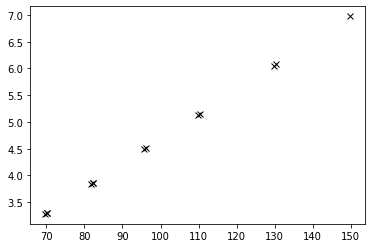

In [163]:
plotting.plot_particle(hits[hits['particle_id']==8.286641868620431e+17])

In [164]:
p = hits[hits['particle_id']== 8.286641868620431e+17]

In [165]:
p

hit_id        x        y           z         r  layer_id  volume_id  \
5189    39208  1.12280  3.08304   69.750000  3.281130         4          9   
5493    39132  1.12886  3.10050   70.199997  3.299610         4          9   
5542    39255  1.13299  3.10214   70.250000  3.302565         4          9   
8538    41349  1.29761  3.60960   81.750000  3.835753         6          9   
8622    41374  1.30616  3.63071   82.250000  3.858511         6          9   
8624    41276  1.30736  3.63104   82.199997  3.859228         6          9   
10871   43237  1.49038  4.23178   95.750000  4.486557         8          9   
10943   43308  1.50159  4.25197   96.250000  4.509326         8          9   
12965   44882  1.68118  4.84920  109.750000  5.132359        10          9   
13043   44921  1.68900  4.86931  110.250000  5.153921        10          9   
15561   46278  1.94890  5.73072  129.750000  6.053046        12          9   
15623   46315  1.95481  5.75421  130.250000  6.077188        12          9   
17722   47462  2.19815  6.61990  149.750000  6.975309        14          9   

       module_id       phi   particle_id        pt  nhits  discrete_module_id  \
5189          74  1.221540  8.286642e+17  0.246616     14                3429   
5493          71  1.221625  8.286642e+17  0.246616     14                3426   
5542          77  1.220620  8.286642e+17  0.246616     14                3432   
8538          74  1.225694  8.286642e+17  0.246616     14                3537   
8622          77  1.225459  8.286642e+17  0.246616     14                3540   
8624          71  1.225196  8.286642e+17  0.246616     14                3534   
10871         74  1.232174  8.286642e+17  0.246616     14                3645   
10943         77  1.231317  8.286642e+17  0.246616     14                3648   
12965         74  1.237071  8.286642e+17  0.246616     14                3753   
13043         77  1.236916  8.286642e+17  0.246616     14                3756   
15561         74  1.242987  8.286642e+17  0.246616     14                3861   
15623         77  1.243310  8.286642e+17  0.246616     14                3864   
17722         74  1.250200  8.286642e+17  0.246616     14                3969   

       Unnamed: 0  unique_layer_id  next_mod_id  connecting_layer_id  
5189           29             19.0       3426.0                 19.0  
5493           29             19.0       3432.0                 19.0  
5542           29             19.0       3537.0                 20.0  
8538           30             20.0       3540.0                 20.0  
8622           30             20.0       3534.0                 20.0  
8624           30             20.0       3645.0                 21.0  
10871          31             21.0       3648.0                 21.0  
10943          31             21.0       3753.0                 22.0  
12965          34             22.0       3756.0                 22.0  
13043          34             22.0       3861.0                 23.0  
15561          33             23.0       3864.0                 23.0  
15623          33             23.0       3969.0                 24.0  
17722          32             24.0       3972.0                 24.0

In [134]:
p['z_2'] = p.groupby('particle_id')['z'].shift(-1)

/home/lhv14/anaconda3/envs/garage/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


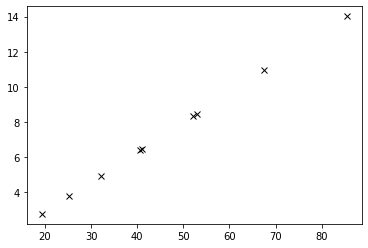

In [89]:
p = hits[hits['particle_id']==-17938.]
plt.plot(p.z, p.r, "kx")

In [90]:
p

run  lumi   evt    nhit   hit_n  hit_id          x         y  \
4735      1    89  8805  136545  136545    3869  -2.749814  0.362738   
80850     1    89  8805  136545  136545   80456  -3.734851  0.491561   
84872     1    89  8805  136545  136545   84534  -4.907141  0.641798   
90534     1    89  8805  136545  136545   90269  -6.350805  0.827724   
89104     1    89  8805  136545  136545   88819  -6.417197  0.835406   
94998     1    89  8805  136545  136545   94784  -8.283895  1.070870   
96180     1    89  8805  136545  136545   95980  -8.415209  1.087709   
100859    1    89  8805  136545  136545  100701 -10.884128  1.393838   
106465    1    89  8805  136545  136545  106353 -13.906260  1.759048   

                z  particle_id  ...   sim_eta  sim_phi  volume_id  layer_id  \
4735    19.387152       -17938  ...  2.469641  3.00885          2         1   
80850   25.200001       -17938  ...  2.469641  3.00885          3        17   
84872   32.175999       -17938  ...  2.469641  3.00885          3        18   
90534   40.699001       -17938  ...  2.469641  3.00885          3        19   
89104   41.098999       -17938  ...  2.469641  3.00885          3        19   
94998   52.111000       -17938  ...  2.469641  3.00885          3        20   
96180   52.910999       -17938  ...  2.469641  3.00885          3        20   
100859  67.508003       -17938  ...  2.469641  3.00885          3        21   
106465  85.377998       -17938  ...  2.469641  3.00885          3        22   

        module_id          r  unique_layer_id  discrete_module_id        z_2  \
4735            9   2.773636                1                 219  25.200001   
80850          10   3.767061               33               31710  32.175999   
84872          10   4.948933               34               31810  40.699001   
90534          16   6.404519               35               31916  41.098999   
89104          10   6.471346               35               31910  52.111000   
94998          16   8.352824               36               32016  52.910999   
96180          12   8.485214               36               32012  67.508003   
100859         12  10.973013               37               32112  85.377998   
106465         16  14.017072               38               32216        NaN   

           diff_z  
4735     5.812849  
80850    6.975998  
84872    8.523003  
90534    0.399998  
89104   11.012001  
94998    0.799999  
96180   14.597004  
100859  17.869995  
106465        NaN  

[9 rows x 28 columns]

In [144]:
np.where(diff > 0)[0]

array([0, 3, 6])

In [138]:
p = p.drop(labels=p.iloc[pos+1].name, axis=0)

In [139]:
p

hit_id        x        y           z         r  layer_id  volume_id  \
7250     6391 -2.59016 -2.33594  -81.800003  3.487914        10          7   
7332     6334 -2.60499 -2.35309  -82.250000  3.510414        10          7   
9404     4413 -3.04598 -2.72336  -95.800003  4.085913         8          7   
9405     4323 -3.04830 -2.72123  -95.750000  4.086224         8          7   
9492     4371 -3.06163 -2.73652  -96.250000  4.106351         8          7   
11505    2726 -3.51320 -3.10103 -109.800003  4.686039         6          7   
11510    2644 -3.51488 -3.10098 -109.750000  4.687266         6          7   
11571    2670 -3.52904 -3.11601 -110.250000  4.707828         6          7   
14136    1314 -4.17919 -3.63444 -129.800003  5.538482         4          7   
14202    1278 -4.19692 -3.64697 -130.250000  5.560083         4          7   

       module_id       phi   particle_id        pt  nhits  discrete_module_id  \
7250          14 -2.407756  5.855140e+16  0.354168     12                 445   
7332          12 -2.406957  5.855140e+16  0.354168     12                 443   
9404          14 -2.412056  5.855140e+16  0.354168     12                 337   
9405           9 -2.412823  5.855140e+16  0.354168     12                 332   
9492          12 -2.412207  5.855140e+16  0.354168     12                 335   
11505         14 -2.418430  5.855140e+16  0.354168     12                 229   
11510          9 -2.418675  5.855140e+16  0.354168     12                 224   
11571         12 -2.418271  5.855140e+16  0.354168     12                 227   
14136         14 -2.425800  5.855140e+16  0.354168     12                 121   
14202         12 -2.426192  5.855140e+16  0.354168     12                 119   

       Unnamed: 0  unique_layer_id  next_mod_id  connecting_layer_id  \
7250           27             13.0        440.0                 13.0   
7332           27             13.0        337.0                 14.0   
9404           24             14.0        332.0                 14.0   
9405           24             14.0        335.0                 14.0   
9492           24             14.0        229.0                 15.0   
11505          23             15.0        224.0                 15.0   
11510          23             15.0        227.0                 15.0   
11571          23             15.0        121.0                 16.0   
14136          22             16.0        119.0                 16.0   
14202          22             16.0         11.0                 17.0   

              z_2  
7250   -81.750000  
7332   -95.800003  
9404   -95.750000  
9405   -96.250000  
9492  -109.800003  
11505 -109.750000  
11510 -110.250000  
11571 -129.800003  
14136 -130.250000  
14202         NaN

In [130]:
-109.75  - (-109.8)

0.04999999999999716

In [158]:
np.where(p.reset_index()['z_2'] < 0)[0] + 1

array([5])

In [150]:
p.reset_index()

index  hit_id          x          y          z          r  layer_id  \
0  44191   57520  -3.767270 -25.670300  22.255299  25.945263         2   
1  46480   57510  -4.988100 -25.880701  21.740000  26.357006         2   
2  51287   62283 -26.461401 -24.301100  12.640000  35.926998         4   
3  58356   66988 -49.189499  -9.001630   1.140000  50.006363         6   
4  59994   66979 -49.846199  -8.165000   0.660000  50.510506         6   
5  63231   71595 -57.869801  31.402100 -16.782499  65.840759         8   

   volume_id  module_id       phi   particle_id        pt  nhits  \
0         13        490 -1.716512  4.504012e+15  0.281702      7   
1         13        489 -1.761196  4.504012e+15  0.281702      7   
2         13        623 -2.398726  4.504012e+15  0.281702      7   
3         13        783 -2.960596  4.504012e+15  0.281702      7   
4         13        782 -2.979231  4.504012e+15  0.281702      7   
5         13        911  2.644423  4.504012e+15  0.281702      7   

   discrete_module_id  Unnamed: 0  unique_layer_id  next_mod_id  \
0                5513           7              5.0       5512.0   
1                5512           7              5.0       6486.0   
2                6486           8              6.0       7822.0   
3                7822           9              7.0       7821.0   
4                7821           9              7.0       9588.0   
5                9588          10              8.0       9587.0   

   connecting_layer_id        z_2  
0                  5.0  21.740000  
1                  6.0  12.640000  
2                  7.0   1.140000  
3                  7.0   0.660000  
4                  8.0 -16.782499  
5                  8.0        NaN

# Radius estimates

In [48]:
hits.particle_id[100]

3.8281607008957235e+17

In [68]:
low_p = hits[hits['pt'] < 1]
high_p = hits[hits['pt'] > 2]

In [72]:
high_p['particle_id'].iloc[0]

5.719678041949471e+17

In [88]:
len(hits[hits['pt']> 10]['particle_id'])

70

In [85]:
hits[hits['pt']> 10]['particle_id'].iloc[0]

4521604130275328.0

In [86]:
p = hits[hits['particle_id']==4521604130275328.0]

In [57]:
from circle_fit import least_squares_circle

In [87]:
for i in range(len(p)-1): 
    h1 = p.iloc[i]
    h2 = p.iloc[i+1]
    
    xc, yc, R, residu = least_squares_circle([[h1.x, h1.y], [h2.x, h2.y]])
    print(R)

0.12434854814892096
1.8450060666005623
2.290366925739873
2.714868568100889
4.4210063400787805
4.952997053159806
7.166896291544502
7.778334867616047


In [59]:
R

2838.0335152463335

In [42]:
!pip install plotly

     |████████████████████████████████| 15.2 MB 4.2 MB/s eta 0:00:01


In [53]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

fig = go.Figure(data=go.Scatter3d(
    x=p.y, y=p.z, z=p.x,
    marker=dict(
        size=4,
        color=p.z,
        colorscale='Viridis',
    ),
    line=dict(
        color='darkblue',
        width=2
    )
))

fig.show()

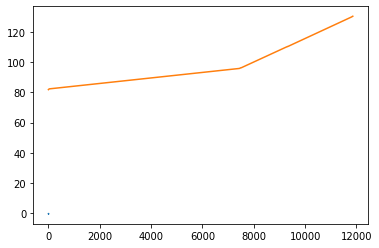

In [36]:


ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens');



# Patterns in output

In [172]:
output = pd.read_csv('../evaluation/garage_outputs.csv')

In [173]:
file0 = output.iloc[200:]

In [174]:
par_reward = file0.groupby('particle_id')['reward'].sum()

In [175]:
low_reward = par_reward[par_reward < -10]

In [176]:
np.median(hits[hits['particle_id'].isin(low_reward.index)].pt)

0.47338378

In [177]:
hits['pt'].median()

0.4639576

In [178]:
comb = hits[hits['particle_id'].isin(file0.particle_id)]

In [179]:
file0 = file0.rename(columns={'mc_z': 'z', 'mc_r':'r'})

In [180]:
merged = comb.merge(file0, on=['particle_id', 'z', 'r']).dropna()

In [181]:
merged

hit_id          x          y           z          r  layer_id  \
231     7466   2.364880   2.765070  -81.800003   3.638443        10   
233     6771   2.154000  -2.993470  -81.800003   3.687896        10   
234    41153   2.396940   2.813220   82.250000   3.695880         6   
237     7835  -0.764934   3.668090  -81.750000   3.747000        10   
238     7557   0.739935   3.674340  -81.750000   3.748103        10   
...      ...        ...        ...         ...        ...       ...   
1851   85034 -67.125702 -47.037899    7.600000  81.965988         2   
1862   84249 -55.100700  61.029305  -27.120001  82.223251         2   
1865   87089   3.201520 -82.252701  107.860001  82.314987         2   
1873   81395  74.055405 -39.389999 -214.750000  83.879524         6   
1878   93649 -16.199800  87.562096  254.449997  89.048050        10   

      volume_id  module_id       phi   particle_id  ...         z_2  \
231           7         68  0.863251  6.980656e+17  ...  -82.199997   
233           7         36 -0.947059  5.269218e+17  ...  -82.199997   
234           9         66  0.865126  4.818962e+17  ...   95.800003   
237           7         85  1.776387  4.508135e+15  ...  -82.199997   
238           7         74  1.372075  5.179264e+17  ...  -81.800003   
...         ...        ...       ...           ...  ...         ...   
1851         17       1332 -2.530368  3.467835e+17  ...    9.760000   
1862         17        944  2.305187  4.143490e+17  ...  -35.760002   
1865         17       2431 -1.531893  3.197735e+17  ...  121.449997   
1873         16         42 -0.488840  2.927483e+17  ... -255.550003   
1878         18         77  1.753737  3.512864e+17  ...  255.550003   

         diff_z  Unnamed: 0  unique_layer_id  next_mod_id  \
231   -0.399994          27             13.0        502.0   
233   -0.399994          27             13.0        470.0   
234   13.550003          30             20.0       3639.0   
237   -0.449997          27             13.0        513.0   
238   -0.050003          27             13.0        510.0   
...         ...         ...              ...          ...   
1851   2.160000          14              9.0      16631.0   
1862  -8.640001          14              9.0      16149.0   
1865  13.589996          14              9.0      18163.0   
1873 -40.800003          51             40.0      11982.0   
1878   1.100006          62             47.0      18607.0   

      connecting_layer_id  filenumber      pred_z     pred_r     reward  
231                  13.0           0  -81.800003   3.672359  -0.033916  
233                  13.0           0  -81.750000   3.760045  -0.087782  
234                  21.0           0   82.250000   3.700553  -0.004673  
237                  13.0           0  -81.750000   3.809158  -0.062157  
238                  13.0           0  -81.750000   3.725419  -0.022685  
...                   ...         ...         ...        ...        ...  
1851                 10.0           0    8.680000  81.837029  -1.087672  
1862                 10.0           0  -25.460001  82.013321  -1.673222  
1865                 43.0           0   62.340004  81.999283 -45.521091  
1873                 41.0           0 -179.550003  66.340492 -39.327566  
1878                 47.0           0  254.449997  86.044121  -3.003929  

[1183 rows x 23 columns]

In [182]:
merged.sort_values('reward')['pt']

1807    0.247806
1484    2.234375
1789    0.262993
1798    1.723281
1809    0.458678
          ...   
1385    0.645765
763     1.454185
303     0.350193
795     0.312495
793     0.454151
Name: pt, Length: 1183, dtype: float32

In [183]:
merged['residual_z'] = merged['z'] - merged['pred_z']
merged['residual_r'] = merged['r'] - merged['pred_r']

(array([3.000e+00, 7.000e+00, 5.000e+00, 2.700e+01, 1.031e+03, 6.700e+01,
        2.100e+01, 1.500e+01, 6.000e+00, 1.000e+00]),
 array([-23.73621368, -18.7730464 , -13.80987911,  -8.84671183,
         -3.88354454,   1.07962275,   6.04279003,  11.00595732,
         15.9691246 ,  20.93229189,  25.89545918]),
 <BarContainer object of 10 artists>)

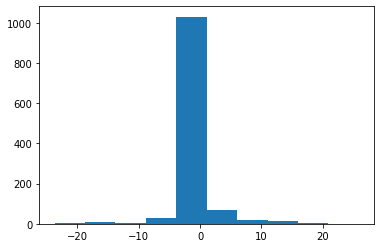

In [184]:
plt.hist(merged['residual_r'])

(array([1.000e+00, 0.000e+00, 2.000e+00, 1.800e+01, 2.300e+01, 1.019e+03,
        8.600e+01, 1.700e+01, 1.200e+01, 5.000e+00]),
 array([-113.37000275,  -93.46800308,  -73.56600342,  -53.66400375,
         -33.76200409,  -13.86000443,    6.04199524,   25.9439949 ,
          45.84599457,   65.74799423,   85.6499939 ]),
 <BarContainer object of 10 artists>)

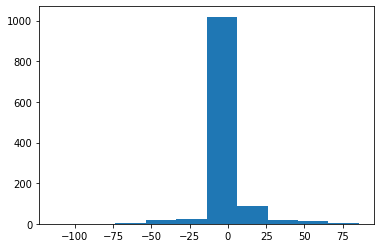

In [185]:
plt.hist(merged['residual_z'])

In [186]:
perfect = merged[merged['reward']==10]

In [191]:
awful = merged[merged['reward']< -20]

In [192]:
awful

hit_id          x          y           z          r  layer_id  \
1121   46053  17.394001   1.512430  130.199997  17.459629        12   
1126   52440  24.229801  -0.151419 -149.550003  24.230274        10   
1127   77379  12.871800  20.618900  179.550003  24.306835         6   
1128   52972 -24.182100   2.730690 -149.550003  24.335789        10   
1129   52947 -24.196899   2.710920 -149.850006  24.348286        10   
...      ...        ...        ...         ...        ...       ...   
1835   86382   8.265631  81.473404   61.259998  81.891609         2   
1841   85489 -81.496506   8.166281   17.900000  81.904625         2   
1843   86286  21.635300 -79.002602   58.020000  81.911514         2   
1865   87089   3.201520 -82.252701  107.860001  82.314987         2   
1873   81395  74.055405 -39.389999 -214.750000  83.879524         6   

      volume_id  module_id       phi   particle_id  ...  Unnamed: 0  \
1121          9         56  0.086733  3.197703e+17  ...          33   
1126         12         86 -0.006249  1.621312e+17  ...          41   
1127         14        112  1.012721  4.053287e+17  ...          44   
1128         12        168  3.029147  6.530265e+17  ...          41   
1129         12        165  3.030022  6.530265e+17  ...          41   
...         ...        ...       ...           ...  ...         ...   
1835         17       2009  1.469690  1.441157e+17  ...          14   
1841         17       1559  3.041722  7.971387e+17  ...          14   
1843         17       1956 -1.303494  5.719666e+17  ...          14   
1865         17       2431 -1.531893  3.197735e+17  ...          14   
1873         16         42 -0.488840  2.927483e+17  ...          51   

      unique_layer_id  next_mod_id  connecting_layer_id  filenumber  \
1121             23.0      11415.0                 34.0           0   
1126             26.0       4766.0                 26.0           0   
1127             33.0      11441.0                 34.0           0   
1128             26.0       4848.0                 26.0           0   
1129             26.0       4681.0                 27.0           0   
...               ...          ...                  ...         ...   
1835              9.0      14435.0                  9.0           0   
1841              9.0      13985.0                  9.0           0   
1843              9.0      14382.0                  9.0           0   
1865              9.0      18163.0                 43.0           0   
1873             40.0      11982.0                 41.0           0   

          pred_z     pred_r     reward  residual_z  residual_r  
1121  179.550003  24.306835 -49.822759  -49.350006   -6.847206  
1126 -110.199997  17.265354 -39.961645  -39.350006    6.964920  
1127  129.800003  15.957936 -50.445680   49.750000    8.348899  
1128 -109.800003  15.649282 -40.688056  -39.750000    8.686506  
1129 -129.800003  17.541908 -21.173790  -20.050003    6.806377  
...          ...        ...        ...         ...         ...  
1835   40.660000  82.209717 -20.602455   20.599998   -0.318108  
1841   46.639999  81.634232 -28.741272  -28.740000    0.270393  
1843   22.219999  81.953995 -35.800030   35.800001   -0.042480  
1865   62.340004  81.999283 -45.521091   45.519997    0.315704  
1873 -179.550003  66.340492 -39.327566  -35.199997   17.539032  

[86 rows x 25 columns]

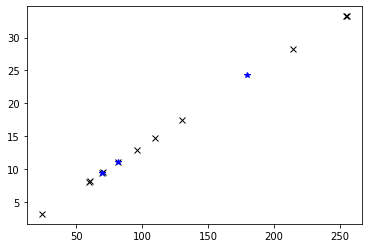

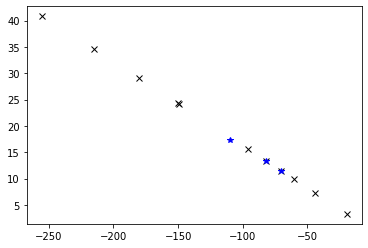

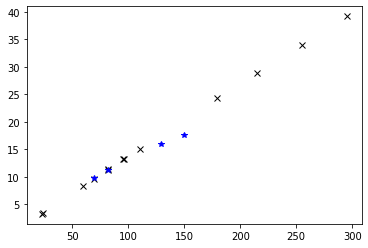

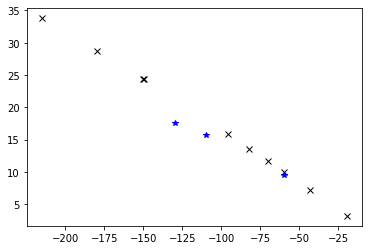

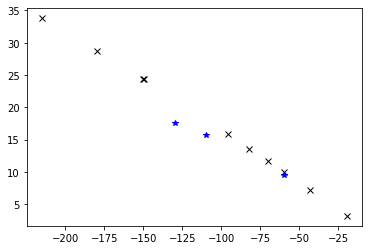

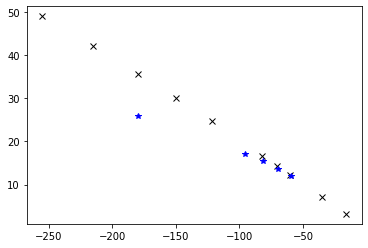

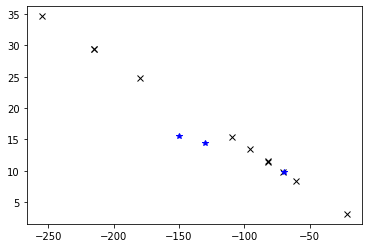

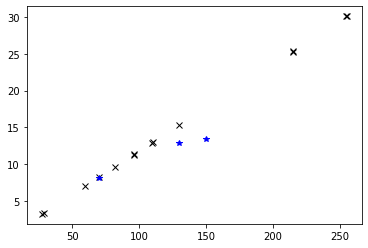

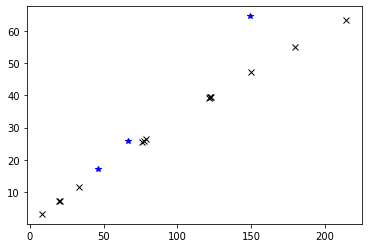

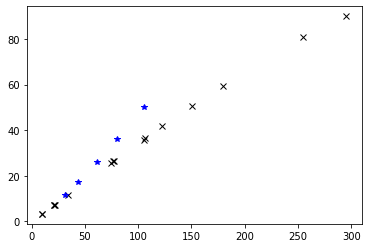

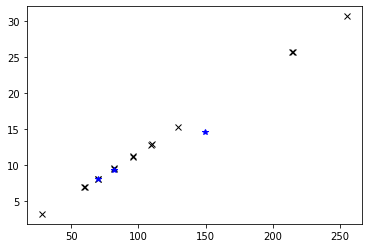

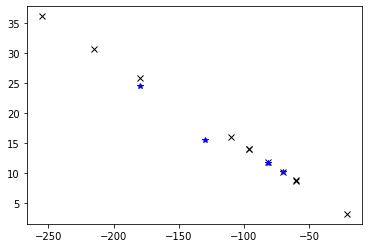

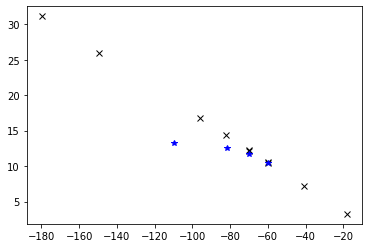

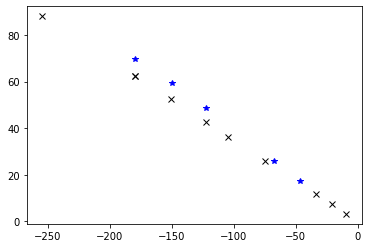

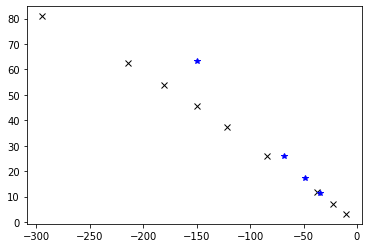

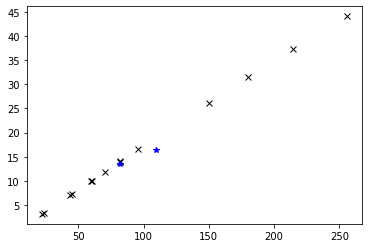

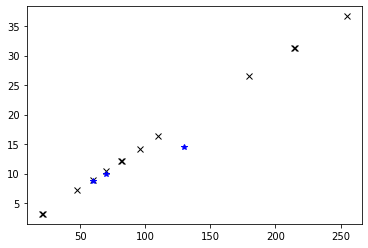

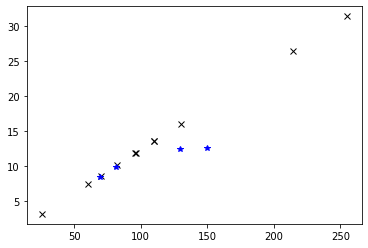

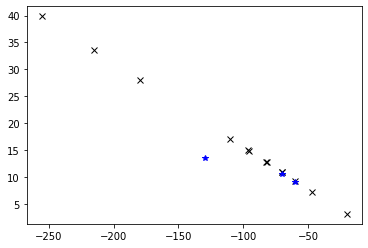

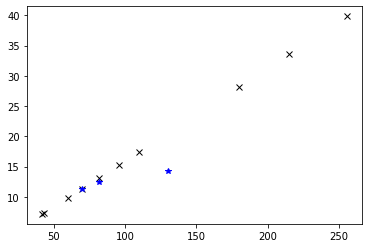

In [193]:
for pid in awful.particle_id[:20]: 
    p = hits[hits['particle_id']==pid]
    p_m = merged[merged['particle_id']==pid]
    plt.plot(p.z, p.r, "kx")
    plt.plot(p_m.pred_z, p_m.pred_r, "b*")
    plt.show() 

In [49]:
!readlink -f new_allowed_pids

/home/lhv14/DDPG/notebooks/new_allowed_pids


In [50]:
!ls

'Algo fitting-CMS.ipynb'   new_allowed_pids.npz        Untitled.ipynb
'Algo fitting.ipynb'	  'NN control.ipynb'
'Evaluation plots.ipynb'  'Quality monitoring.ipynb'


In [58]:
y = np.loadtxt('new_allowed_pids.out')

In [59]:
y

array([-17938., -17935., -17934., ...,    907.,    908.,    909.])

In [56]:
!ls

'Algo fitting-CMS.ipynb'   new_allowed_pids	 'Quality monitoring.ipynb'
'Algo fitting.ipynb'	   new_allowed_pids.npz   Untitled.ipynb
'Evaluation plots.ipynb'  'NN control.ipynb'
